# CNN + MaxPool
Run this model on all lncRNA cell lines using some theshold. This notebook tests GMM with predict().

* zero
* RCI threshold set by GMM(2).
* Antilog threshold set by GMM(2).

Show pretty pictures.

10-fold cross-validation.

Compute the sample standard deviation.

In [1]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-02-14 13:30:46.917493
Python 3.8.10
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64
FILTERSIZE=16
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=10      
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'RCI_GMM' # 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
CACHING = False   # have not worked out how to cache multiple cell lines
NUM_LINES = 15   # 15 to analyze all of them, 1 for testing

In [3]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/


In [4]:
RCI_FILE =      'CNRCI_noncoding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_noncoding_train_transcripts.gc42.csv'
CACHE_SEQUENCE = 'cache.seq.pickle'
CACHE_IDS = 'cache.id.pickle'
if CACHING:
    cache_seq = DATA_DIR+CACHE_SEQUENCE 
    cache_ids = DATA_DIR+CACHE_IDS 
    if isfile(cache_seq) and isfile(cache_ids):
        print('WARNING: this run will read sequence from cache.')
    else:
        print('INFO: this run will write sequence to cache.')

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

EXCLUSIONS = [1,7]   # use these though they are clearly different

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line]
                    if rci_str != "nan":
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
        print('Number of RCI values loaded',len(gene_to_rci.keys()))
        return gene_to_rci

    def seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        allids=[]
        allseq=[]
        cache_seq = DATA_DIR+CACHE_SEQUENCE 
        cache_ids = DATA_DIR+CACHE_IDS 
        if CACHING and isfile(cache_seq) and isfile(cache_ids):
            # Warning: the cache may represent the wrong K.
            with open(cache_seq,'rb') as fin:
                allseq = pickle.load(fin)
            with open(cache_ids,'rb') as fin:
                allids = pickle.load(fin)
            return allids,allseq           
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        if CACHING:
            with open(cache_seq,'wb') as fout:
                pickle.dump(allseq,fout)
            with open(cache_ids,'wb') as fout:
                pickle.dump(allids,fout)
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    #pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-02-14 13:31:15.188426
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4982, 64)          4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 621, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 39744)             0         
                                                                 
 dense (Dense)               (None, 16)                635920    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        
    def set_sequences(self, allids, allseq):
        # It is critical to keep IDs and sequences in same order!
        self.all_ids = allids  # pairs of (gene_id,tran_id)
        self.all_seqs = allseq  # may be vectors of K-mers
        genes = []
        for i in range(len(allids)):
            (one_gene,one_tran) = allids[i]
            genes.append(one_gene)
        self.all_genes = genes
            
    def set_rci_map(self, gene_to_rci):
        # The map is for fast lookup, not gene order!
        self.rci_map = gene_to_rci # map gene_id to RCI value
    
    def get_gene_subset(self, sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = self.all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes   # this is a set: unordered with fast lookup
    
    def _get_X_y(self, gene_index):
        cnt = len(self.all_ids)
        subsetX=[]
        subsetY=[]
        next_index = 0
        for i in range(cnt):
            if next_index==len(gene_index):
                break
            if i==gene_index[next_index]:
                gene_id,tran_id = self.all_ids[i]
                oneX = self.all_seqs[i]
                oneY = self.rci_map[gene_id]
                subsetX.append(oneX)
                subsetY.append(oneY)
                next_index += 1
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        '''Takes list of float, returns list of labels [0,1].'''
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
        else:
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values):
        if self.mechanism == 'RCI_GMM':
            self.discriminator = GaussianMixture(n_components=2, verbose=0, 
                covariance_type='spherical', n_init=100) 
            self.discriminator.fit(rci_values)
        elif RCI_THRESHOLD_MECHANISM == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        else:
            self.discriminator = 0
        
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        cv_auprc=[]
        cv_auroc=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        splits = splitter.split(self.all_genes)
        splitter = None
        for train_index,valid_index in splits:
            fold += 1
            print('Fold',fold)
            X_train,y_rci = self._get_X_y(train_index)
            self._prepare_threshold(y_rci)  # use train subset only!
            y_train = self._apply_threshold(y_rci)
            X_valid,y_rci = self._get_X_y(valid_index)
            y_valid = self._apply_threshold(y_rci) 
            y_rci = None

            #print('Training example')
            #print(X_train[0])
            #print("BUILD MODEL")
            model=build_model()
            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
              epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none
              validation_data=(X_valid,y_valid) )
            print("PREDICT")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0)             
            yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            # PRC
            prc_Y, prc_X, prc_bins = precision_recall_curve(y_valid, yhat_pred)
            auprc = auc(prc_X,prc_Y)*100.
            auroc = roc_auc_score(y_valid, yhat_pred)*100.

            if PRETTY_PICTURES:
                pd.DataFrame(history.history).plot(figsize=(8,5))
                plt.grid(True)
                plt.gca().set_ylim(0,1)
                plt.show()

                print('Train set ones/size',
                      np.count_nonzero(y_train),'/',len(y_train))
                print("Compute valiation accuracy")
                print('Valid sizes',X_valid.shape,y_valid.shape)
                print('Valid set ones/size',
                      np.count_nonzero(y_valid),'/',len(y_valid))
                print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
                print('Score threshold',self.score_threshold)
                print('Prediction set ones/size',
                      np.count_nonzero(yhat_classes),'/',len(yhat_classes))
            
                count_ones= len(y_valid[y_valid==1])
                count_zeros= len(y_valid[y_valid==0])
                guess = max(count_ones,count_zeros) / len(y_valid)
                plt.plot(prc_X, prc_Y, marker='.')
                plt.plot([0, 1], [guess,guess], linestyle='--')
                plt.xlabel('Recall')
                plt.ylabel('Precision')
                plt.show()
                # ROC
                fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
                plt.plot(fpr, tpr, marker='.')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.show()
            
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% AUPRC: %.2f%% AUROC: %.2f%%' % (f1,auprc,auroc)) 
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            cv_auprc.append(auprc)
            cv_auroc.append(auroc)
            
            print(datetime.now())
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break

            # There is a memory leak within the fit() command!
            # Each successive call to fit() consumes more memory.
            model = None
            history = None
            prc_Y = None
            prc_X = None
            prc_bins = None
            yhat_classes = None
            X_train = None
            y_train = None
            X_valid = None
            y_valid = None
            tf.keras.backend.clear_session()
            gc.collect()
            time.sleep(1)  # hope gc kicks in
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc

2023-02-14 13:31:18.643028
Start cell Line 0 A549
Number of RCI values loaded 1447
Num RCI: 1447
Load sequence...
Cross validation...
2023-02-14 13:31:34.244122
splitting
Fold 1
FIT
2023-02-14 13:31:44.969485
PREDICT
2023-02-14 13:32:06.986286


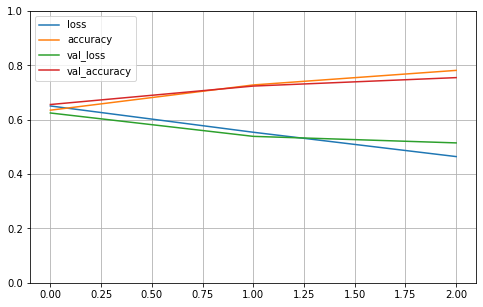

Train set ones/size 2905 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 354 / 869
Range of scores: 0.01110825 to 0.98966134
Score threshold 0.5
Prediction set ones/size 267 / 869


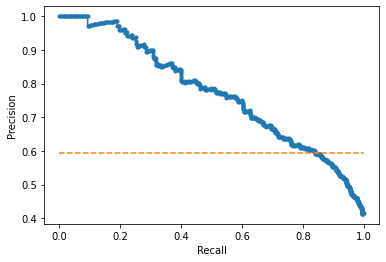

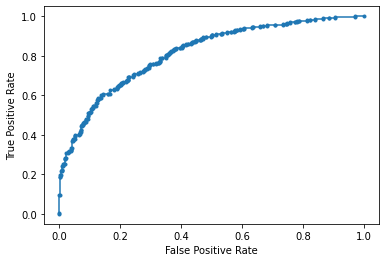

Accuracy: 75.49% Precision: 76.40% Recall: 57.63%
F1: 65.70% AUPRC: 77.32% AUROC: 81.49%
2023-02-14 13:32:07.754995
Fold 2
FIT
2023-02-14 13:32:22.915833
PREDICT
2023-02-14 13:32:34.390468


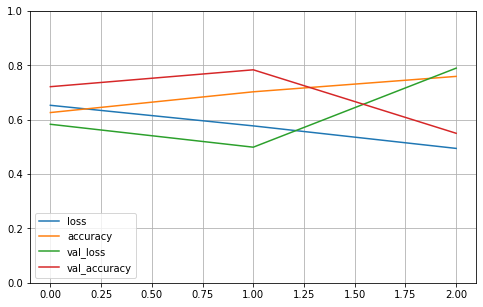

Train set ones/size 2909 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 303 / 869
Range of scores: 0.01962551 to 0.99666935
Score threshold 0.5
Prediction set ones/size 652 / 869


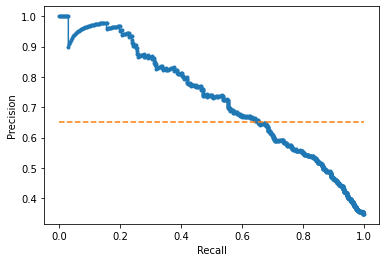

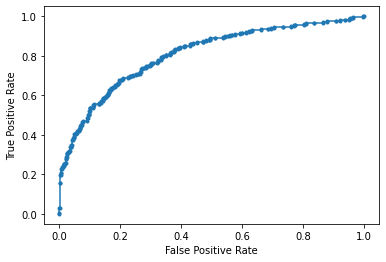

Accuracy: 55.01% Precision: 43.25% Recall: 93.07%
F1: 59.06% AUPRC: 72.91% AUROC: 80.71%
2023-02-14 13:32:35.096833
Fold 3
FIT
2023-02-14 13:32:48.480206
PREDICT
2023-02-14 13:32:57.477329


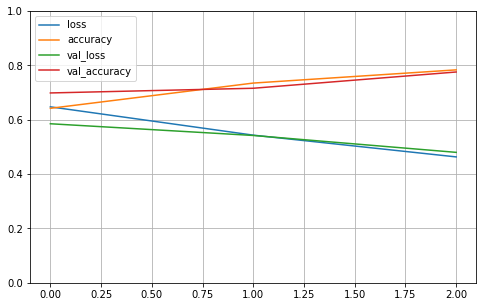

Train set ones/size 4920 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 555 / 869
Range of scores: 0.01164376 to 0.9968432
Score threshold 0.5
Prediction set ones/size 582 / 869


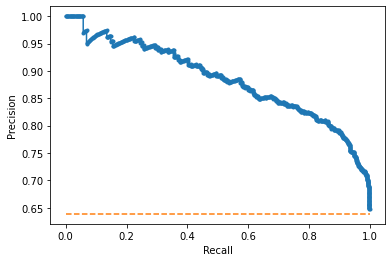

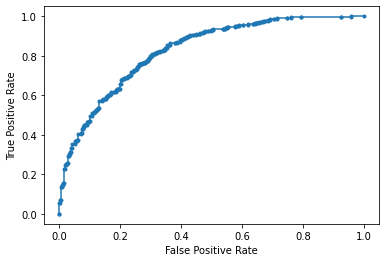

Accuracy: 77.56% Precision: 80.93% Recall: 84.86%
F1: 82.85% AUPRC: 88.43% AUROC: 82.80%
2023-02-14 13:32:58.438943
Fold 4
FIT
2023-02-14 13:33:11.178174
PREDICT
2023-02-14 13:33:19.769737


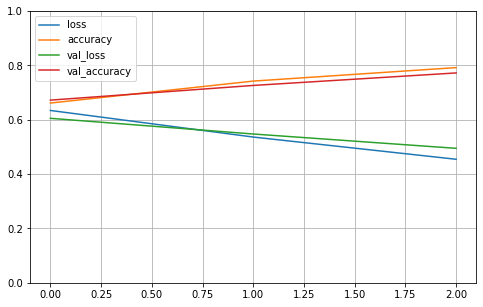

Train set ones/size 5115 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 556 / 869
Range of scores: 0.0028895945 to 0.9912513
Score threshold 0.5
Prediction set ones/size 566 / 869


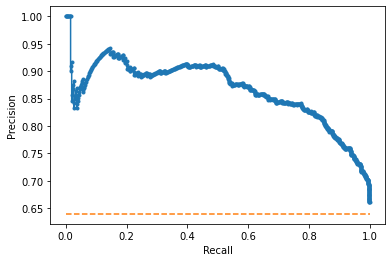

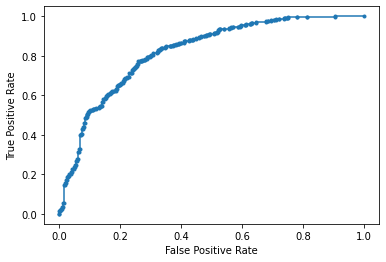

Accuracy: 77.22% Precision: 81.63% Recall: 83.09%
F1: 82.35% AUPRC: 86.56% AUROC: 82.09%
2023-02-14 13:33:20.463512
Fold 5
FIT
2023-02-14 13:33:31.713776
PREDICT
2023-02-14 13:33:43.156908


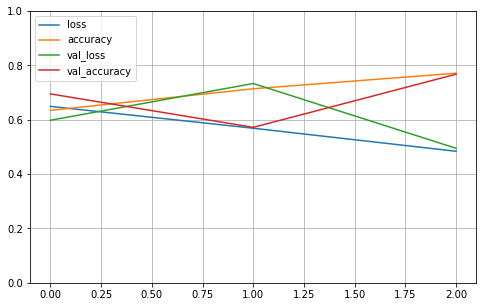

Train set ones/size 2807 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 316 / 869
Range of scores: 0.004667594 to 0.9911485
Score threshold 0.5
Prediction set ones/size 234 / 869


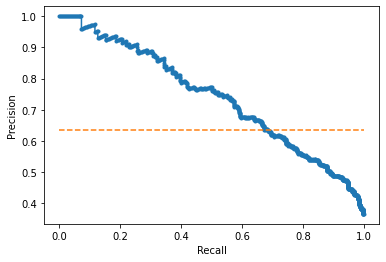

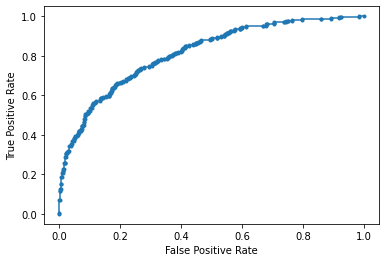

Accuracy: 76.75% Precision: 74.36% Recall: 55.06%
F1: 63.27% AUPRC: 74.11% AUROC: 81.48%
2023-02-14 13:33:43.871049
Fold 6
FIT
2023-02-14 13:33:55.853652
PREDICT
2023-02-14 13:34:07.344029


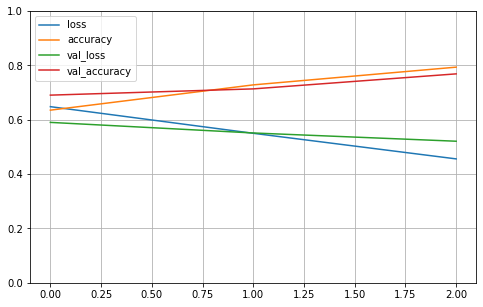

Train set ones/size 2906 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 305 / 869
Range of scores: 0.0007165898 to 0.98890615
Score threshold 0.5
Prediction set ones/size 164 / 869


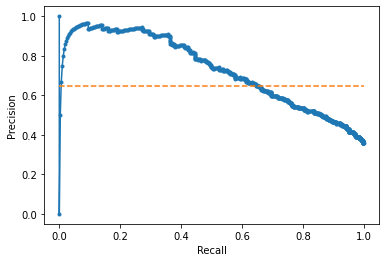

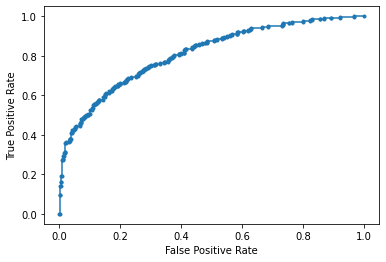

Accuracy: 76.87% Precision: 81.71% Recall: 43.93%
F1: 57.14% AUPRC: 72.93% AUROC: 81.01%
2023-02-14 13:34:08.049968
Fold 7
FIT
2023-02-14 13:34:21.233391
PREDICT
2023-02-14 13:34:32.705322


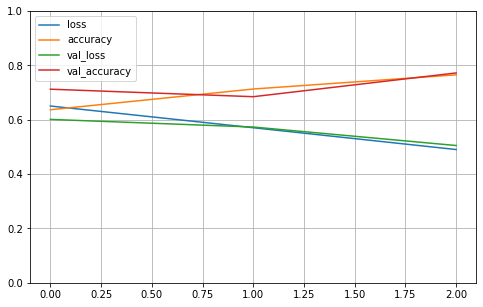

Train set ones/size 2943 / 7818
Compute valiation accuracy
Valid sizes (869, 4997) (869,)
Valid set ones/size 334 / 869
Range of scores: 0.0010757508 to 0.95619404
Score threshold 0.5
Prediction set ones/size 202 / 869


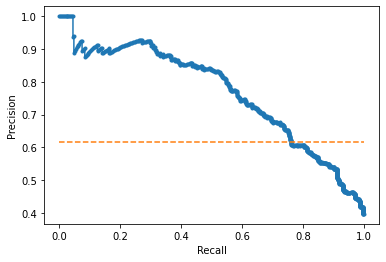

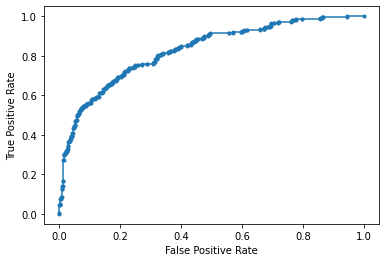

Accuracy: 77.22% Precision: 83.66% Recall: 50.60%
F1: 63.06% AUPRC: 76.79% AUROC: 82.85%
2023-02-14 13:34:33.406025
Fold 8
FIT
2023-02-14 13:34:46.668976
PREDICT
2023-02-14 13:34:58.160183


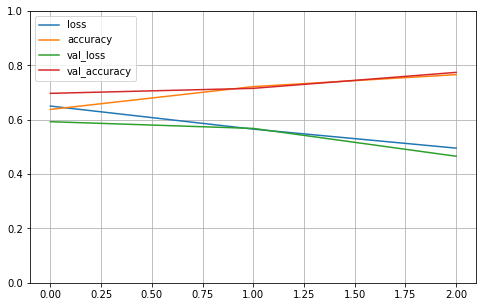

Train set ones/size 2809 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 314 / 868
Range of scores: 0.0041690366 to 0.9835585
Score threshold 0.5
Prediction set ones/size 232 / 868


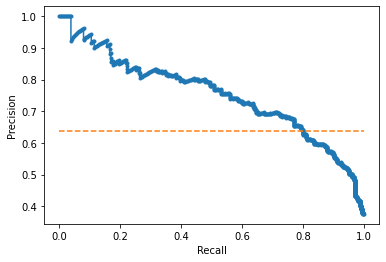

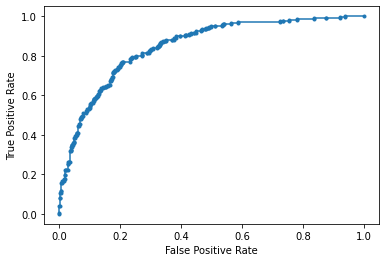

Accuracy: 77.42% Precision: 75.43% Recall: 55.73%
F1: 64.10% AUPRC: 75.31% AUROC: 84.82%
2023-02-14 13:34:58.844318
Fold 9
FIT
2023-02-14 13:35:11.056214
PREDICT
2023-02-14 13:35:19.620916


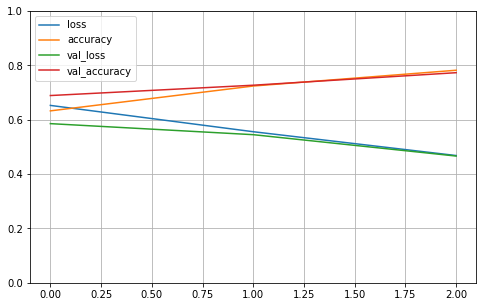

Train set ones/size 4977 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 549 / 868
Range of scores: 0.006117175 to 0.9981579
Score threshold 0.5
Prediction set ones/size 656 / 868


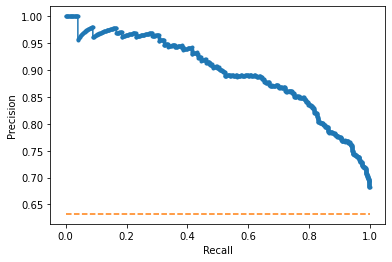

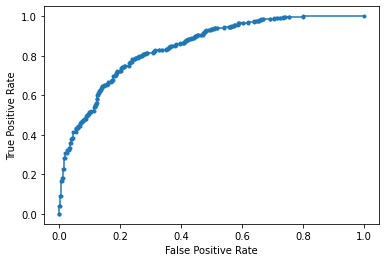

Accuracy: 77.30% Precision: 76.83% Recall: 91.80%
F1: 83.65% AUPRC: 89.57% AUROC: 84.48%
2023-02-14 13:35:20.784720
Fold 10
FIT
2023-02-14 13:35:32.331127
PREDICT
2023-02-14 13:35:41.873538


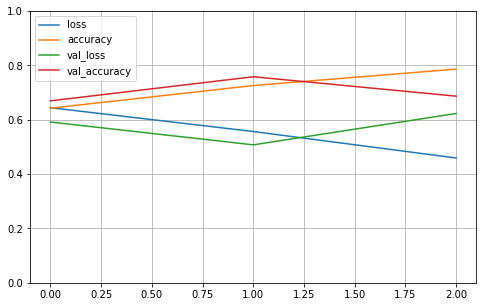

Train set ones/size 2898 / 7819
Compute valiation accuracy
Valid sizes (868, 4997) (868,)
Valid set ones/size 313 / 868
Range of scores: 0.011355701 to 0.99780124
Score threshold 0.5
Prediction set ones/size 501 / 868


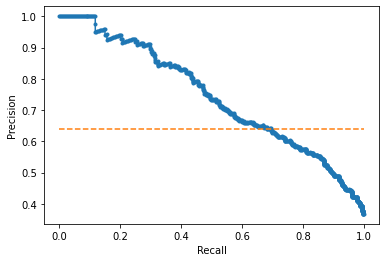

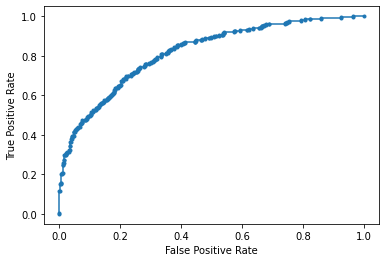

Accuracy: 68.66% Precision: 54.09% Recall: 86.58%
F1: 66.58% AUPRC: 74.47% AUROC: 81.76%
2023-02-14 13:35:42.585545

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.95% +/- 7.17
 precision mean 72.83% +/- 13.35
 recall mean 70.24% +/- 19.18
 F1 mean 68.78% +/- 10.18
 AUPRC mean 78.84% +/- 6.64
 AUROC mean 82.35% +/- 1.40
Finished cell Line 0 A549

2023-02-14 13:35:43.982513
Start cell Line 1 H1.hESC
Number of RCI values loaded 3327
Num RCI: 3327
Load sequence...
Cross validation...
2023-02-14 13:36:10.205703
splitting
Fold 1
FIT
2023-02-14 13:36:26.498762
PREDICT
2023-02-14 13:36:49.225337


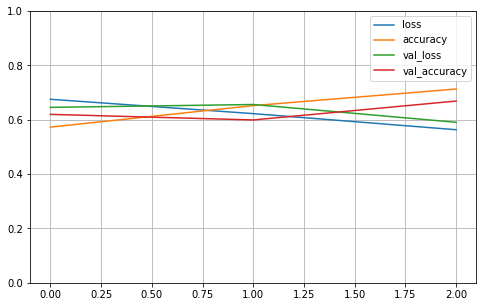

Train set ones/size 6896 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 783 / 1654
Range of scores: 0.014087032 to 0.99008626
Score threshold 0.5
Prediction set ones/size 497 / 1654


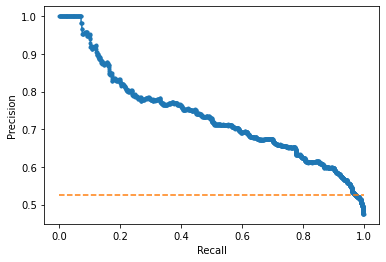

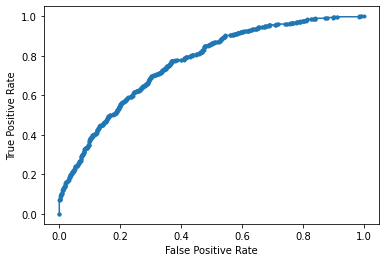

Accuracy: 66.87% Precision: 73.64% Recall: 46.74%
F1: 57.19% AUPRC: 73.65% AUROC: 76.43%
2023-02-14 13:36:50.121690
Fold 2
FIT
2023-02-14 13:37:06.673026
PREDICT
2023-02-14 13:37:23.253127


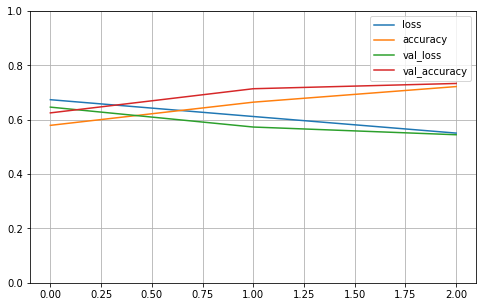

Train set ones/size 6772 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 730 / 1654
Range of scores: 0.002585 to 0.989795
Score threshold 0.5
Prediction set ones/size 517 / 1654


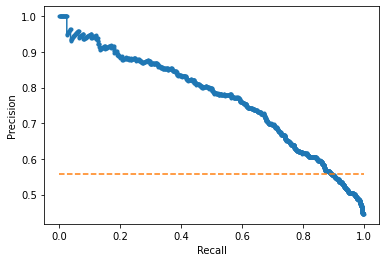

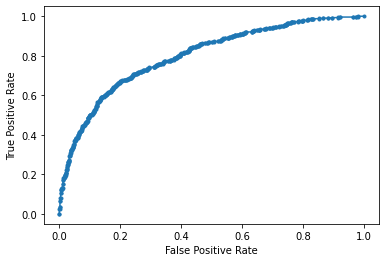

Accuracy: 73.34% Precision: 77.95% Recall: 55.21%
F1: 64.64% AUPRC: 76.86% AUROC: 80.04%
2023-02-14 13:37:24.167039
Fold 3
FIT
2023-02-14 13:37:38.941201
PREDICT
2023-02-14 13:38:01.110663


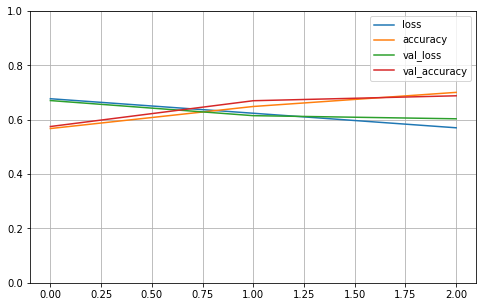

Train set ones/size 6683 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 755 / 1654
Range of scores: 0.005153965 to 0.9898135
Score threshold 0.5
Prediction set ones/size 639 / 1654


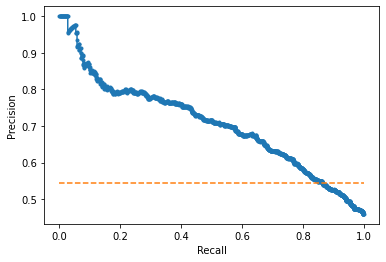

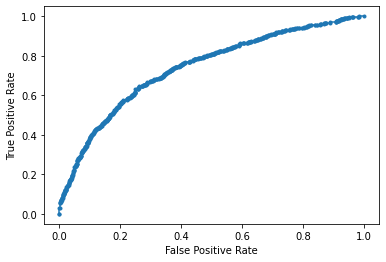

Accuracy: 68.80% Precision: 68.70% Recall: 58.15%
F1: 62.98% AUPRC: 70.66% AUROC: 73.96%
2023-02-14 13:38:02.308272
Fold 4
FIT
2023-02-14 13:38:16.961546
PREDICT
2023-02-14 13:38:39.143901


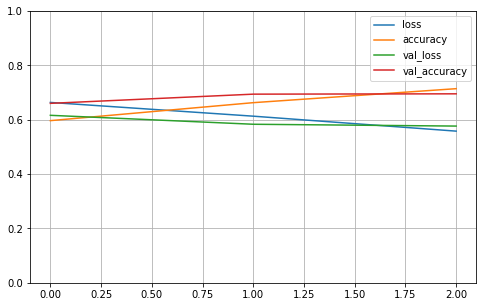

Train set ones/size 6689 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 749 / 1654
Range of scores: 0.02643588 to 0.9959336
Score threshold 0.5
Prediction set ones/size 939 / 1654


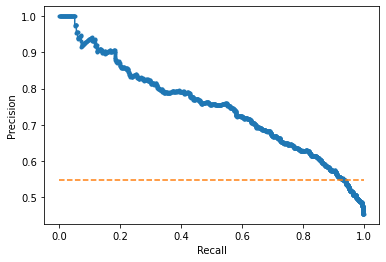

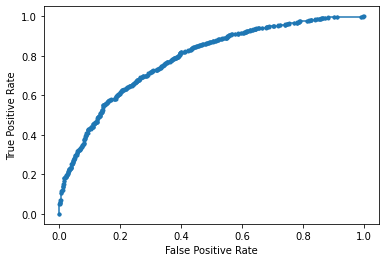

Accuracy: 69.53% Precision: 63.05% Recall: 79.04%
F1: 70.14% AUPRC: 75.04% AUROC: 78.52%
2023-02-14 13:38:40.205014
Fold 5
FIT
2023-02-14 13:38:57.765590
PREDICT
2023-02-14 13:39:13.661261


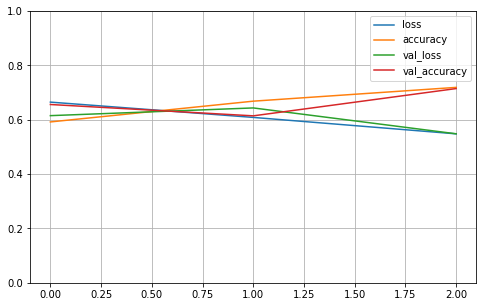

Train set ones/size 8093 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 871 / 1654
Range of scores: 0.013330867 to 0.986328
Score threshold 0.5
Prediction set ones/size 1049 / 1654


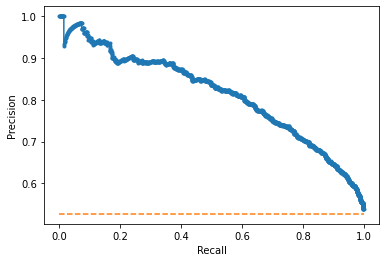

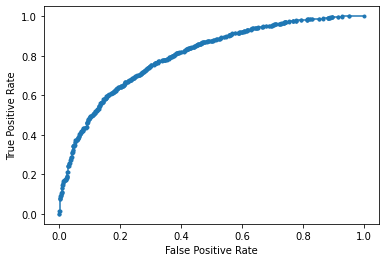

Accuracy: 71.46% Precision: 69.02% Recall: 83.12%
F1: 75.42% AUPRC: 81.41% AUROC: 80.15%
2023-02-14 13:39:14.502485
Fold 6
FIT
2023-02-14 13:39:30.739714
PREDICT
2023-02-14 13:39:52.908840


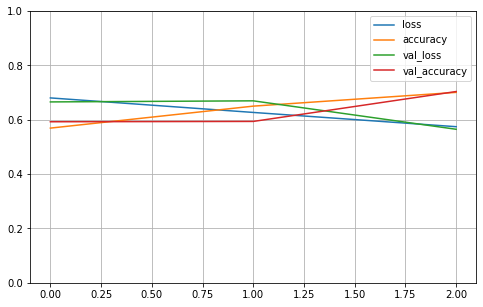

Train set ones/size 6634 / 14882
Compute valiation accuracy
Valid sizes (1654, 4997) (1654,)
Valid set ones/size 755 / 1654
Range of scores: 0.010378383 to 0.97055703
Score threshold 0.5
Prediction set ones/size 667 / 1654


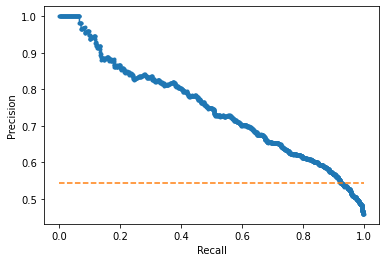

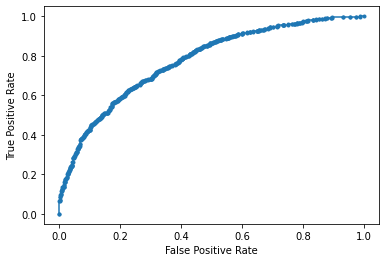

Accuracy: 70.37% Precision: 69.87% Recall: 61.72%
F1: 65.54% AUPRC: 74.73% AUROC: 77.49%
2023-02-14 13:39:53.779020
Fold 7
FIT
2023-02-14 13:40:07.958018
PREDICT
2023-02-14 13:40:30.135260


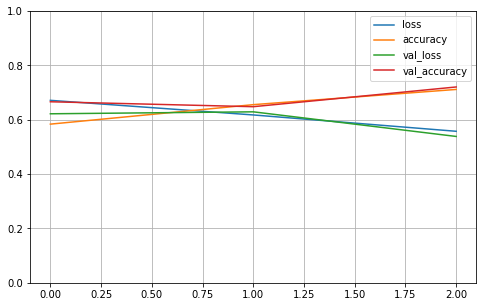

Train set ones/size 6822 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 759 / 1653
Range of scores: 0.0007042875 to 0.9860053
Score threshold 0.5
Prediction set ones/size 637 / 1653


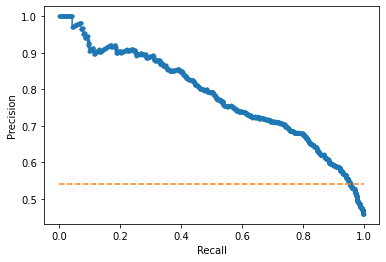

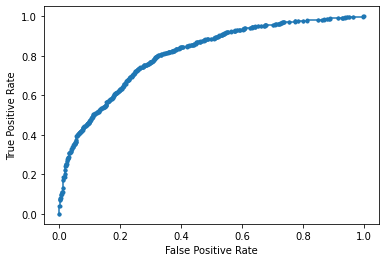

Accuracy: 72.05% Precision: 73.31% Recall: 61.53%
F1: 66.91% AUPRC: 78.21% AUROC: 80.75%
2023-02-14 13:40:30.997444
Fold 8
FIT
2023-02-14 13:40:48.198568
PREDICT
2023-02-14 13:41:03.958574


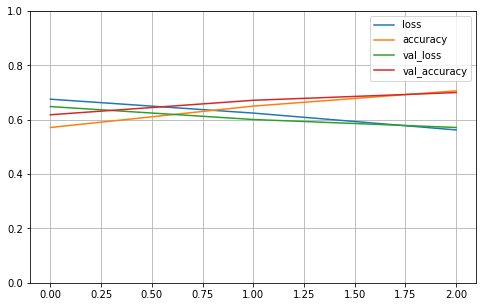

Train set ones/size 7551 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 855 / 1653
Range of scores: 0.0034122323 to 0.99727076
Score threshold 0.5
Prediction set ones/size 849 / 1653


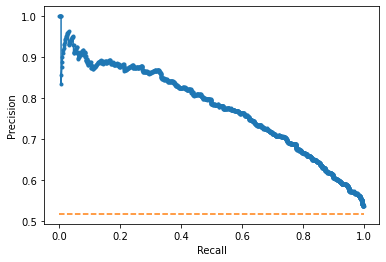

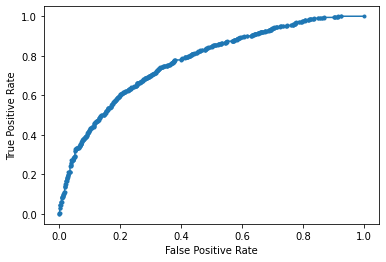

Accuracy: 69.99% Precision: 71.14% Recall: 70.64%
F1: 70.89% AUPRC: 77.64% AUROC: 77.22%
2023-02-14 13:41:05.075401
Fold 9
FIT
2023-02-14 13:41:16.663973
PREDICT
2023-02-14 13:41:39.316836


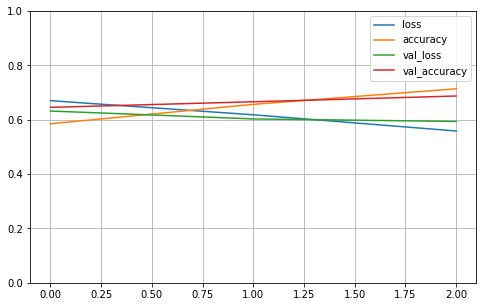

Train set ones/size 6869 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 736 / 1653
Range of scores: 0.01258127 to 0.998357
Score threshold 0.5
Prediction set ones/size 989 / 1653


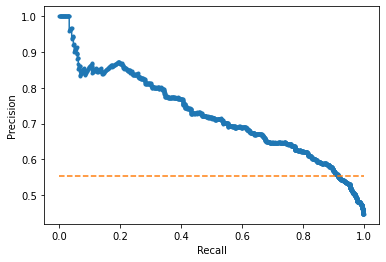

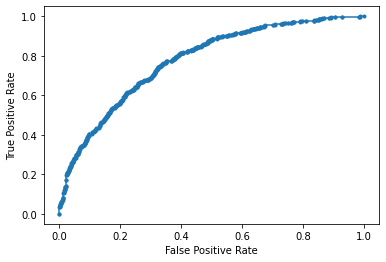

Accuracy: 68.72% Precision: 61.07% Recall: 82.07%
F1: 70.03% AUPRC: 72.60% AUROC: 77.66%
2023-02-14 13:41:40.235444
Fold 10
FIT
2023-02-14 13:41:55.380226
PREDICT
2023-02-14 13:42:17.723310


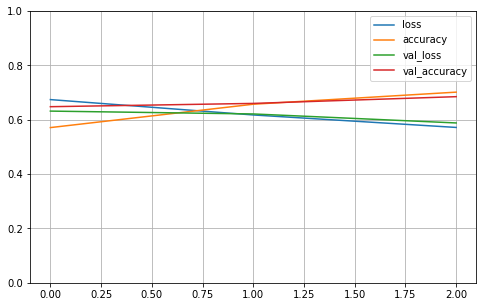

Train set ones/size 6848 / 14883
Compute valiation accuracy
Valid sizes (1653, 4997) (1653,)
Valid set ones/size 757 / 1653
Range of scores: 0.03420081 to 0.97100824
Score threshold 0.5
Prediction set ones/size 640 / 1653


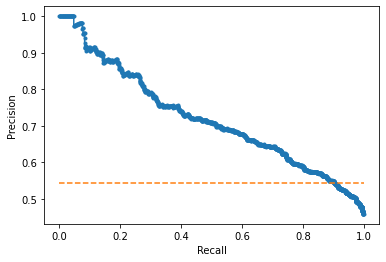

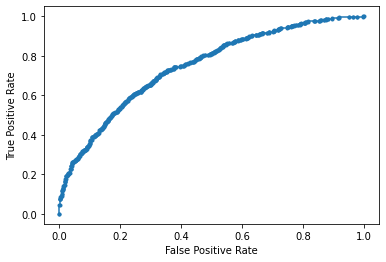

Accuracy: 68.48% Precision: 68.44% Recall: 57.86%
F1: 62.71% AUPRC: 72.08% AUROC: 74.73%
2023-02-14 13:42:18.587462

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.96% +/- 1.92
 precision mean 69.62% +/- 4.95
 recall mean 65.61% +/- 12.45
 F1 mean 66.64% +/- 5.19
 AUPRC mean 75.29% +/- 3.27
 AUROC mean 77.70% +/- 2.26
Finished cell Line 1 H1.hESC

2023-02-14 13:42:20.185293
Start cell Line 2 HeLa.S3
Number of RCI values loaded 919
Num RCI: 919
Load sequence...
Cross validation...
2023-02-14 13:42:30.111256
splitting
Fold 1
FIT
2023-02-14 13:42:35.334179
PREDICT
2023-02-14 13:42:42.264057


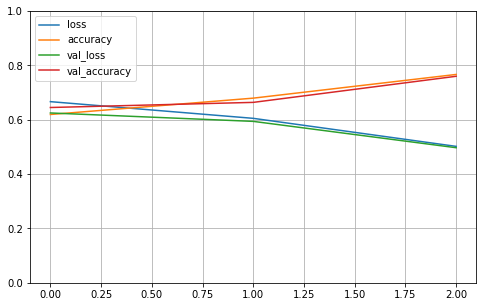

Train set ones/size 1904 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 207 / 583
Range of scores: 0.001002531 to 0.9281431
Score threshold 0.5
Prediction set ones/size 79 / 583


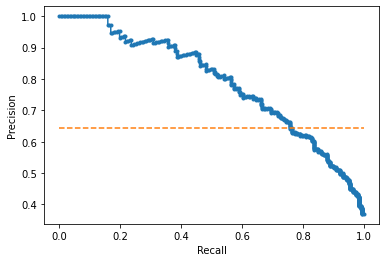

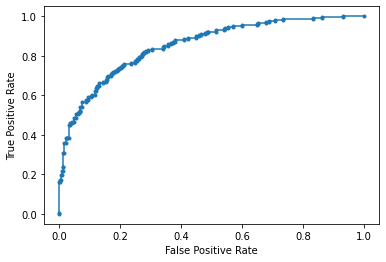

Accuracy: 75.99% Precision: 92.41% Recall: 35.27%
F1: 51.05% AUPRC: 78.95% AUROC: 85.29%
2023-02-14 13:42:42.924206
Fold 2
FIT
2023-02-14 13:42:49.482650
PREDICT
2023-02-14 13:42:56.805435


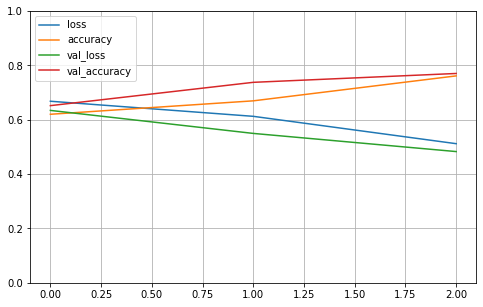

Train set ones/size 1883 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 203 / 583
Range of scores: 0.008305702 to 0.9707281
Score threshold 0.5
Prediction set ones/size 161 / 583


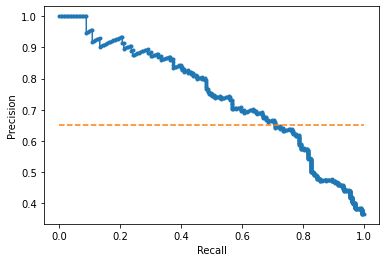

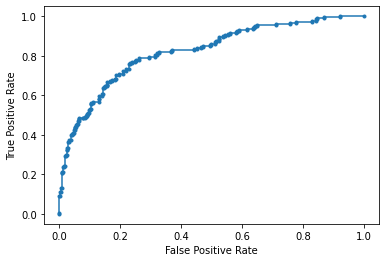

Accuracy: 77.02% Precision: 71.43% Recall: 56.65%
F1: 63.19% AUPRC: 74.47% AUROC: 82.26%
2023-02-14 13:42:57.423365
Fold 3
FIT
2023-02-14 13:43:06.997318
PREDICT
2023-02-14 13:43:18.365830


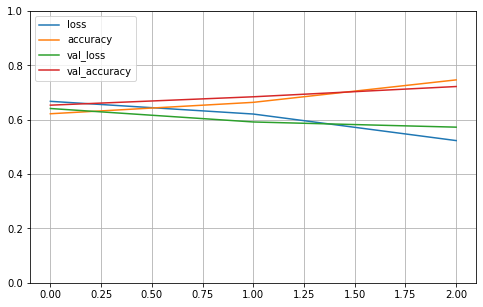

Train set ones/size 1883 / 5240
Compute valiation accuracy
Valid sizes (583, 4997) (583,)
Valid set ones/size 201 / 583
Range of scores: 0.0013007511 to 0.8509852
Score threshold 0.5
Prediction set ones/size 63 / 583


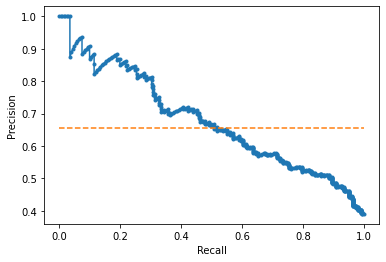

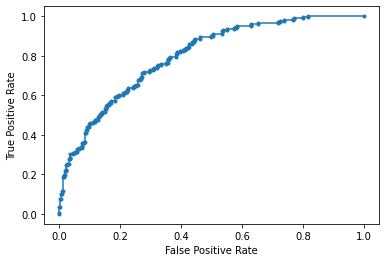

Accuracy: 72.21% Precision: 80.95% Recall: 25.37%
F1: 38.64% AUPRC: 67.81% AUROC: 79.89%
2023-02-14 13:43:19.096374
Fold 4
FIT
2023-02-14 13:43:27.061238
PREDICT
2023-02-14 13:43:38.434567


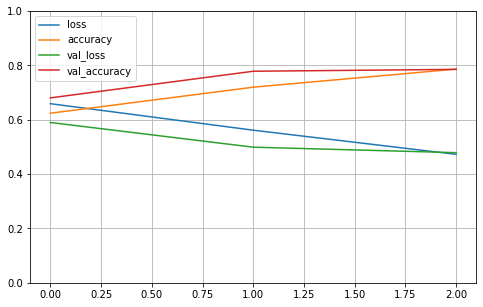

Train set ones/size 1919 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 191 / 582
Range of scores: 0.004029633 to 0.97841454
Score threshold 0.5
Prediction set ones/size 116 / 582


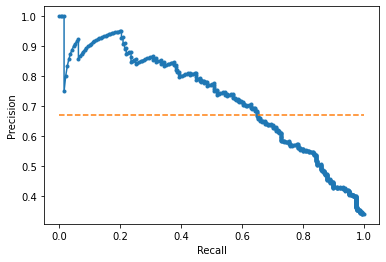

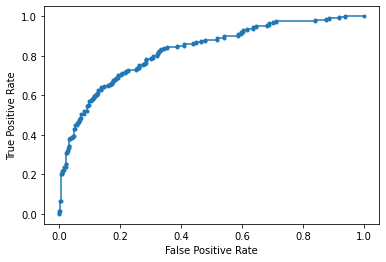

Accuracy: 78.52% Precision: 78.45% Recall: 47.64%
F1: 59.28% AUPRC: 72.41% AUROC: 82.60%
2023-02-14 13:43:39.124702
Fold 5
FIT
2023-02-14 13:43:47.888496
PREDICT
2023-02-14 13:43:59.256779


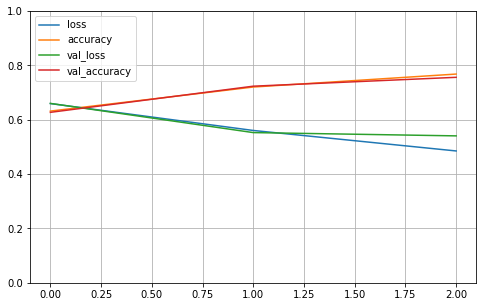

Train set ones/size 3372 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 365 / 582
Range of scores: 0.02379253 to 0.99737215
Score threshold 0.5
Prediction set ones/size 481 / 582


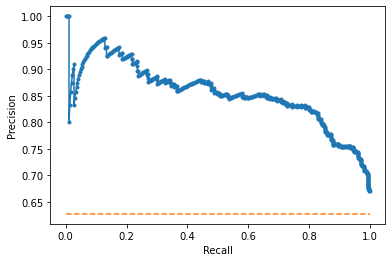

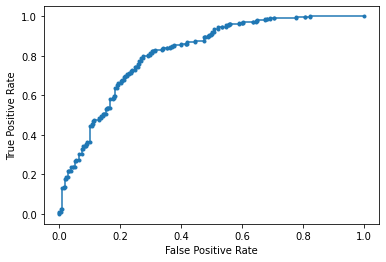

Accuracy: 75.60% Precision: 73.18% Recall: 96.44%
F1: 83.22% AUPRC: 85.49% AUROC: 81.49%
2023-02-14 13:43:59.938196
Fold 6
FIT
2023-02-14 13:44:07.300382
PREDICT
2023-02-14 13:44:14.535029


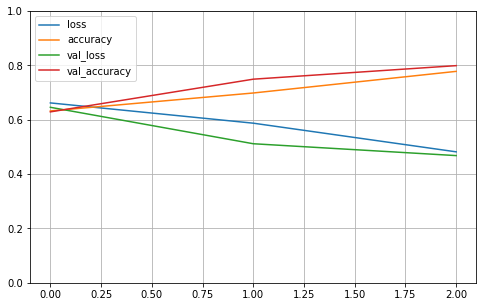

Train set ones/size 1870 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 216 / 582
Range of scores: 0.005074434 to 0.97704804
Score threshold 0.5
Prediction set ones/size 193 / 582


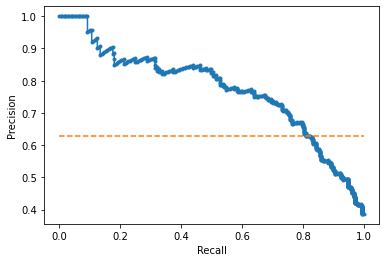

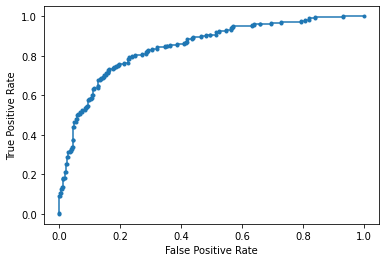

Accuracy: 79.90% Precision: 75.65% Recall: 67.59%
F1: 71.39% AUPRC: 77.28% AUROC: 84.60%
2023-02-14 13:44:15.178988
Fold 7
FIT
2023-02-14 13:44:23.978794
PREDICT
2023-02-14 13:44:35.374581


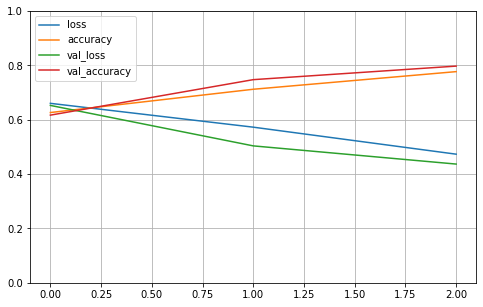

Train set ones/size 3353 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 359 / 582
Range of scores: 0.0075418362 to 0.99240375
Score threshold 0.5
Prediction set ones/size 357 / 582


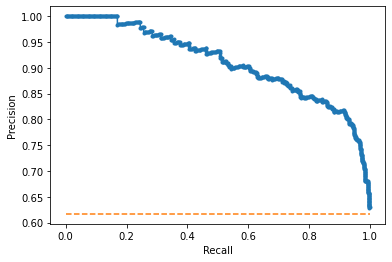

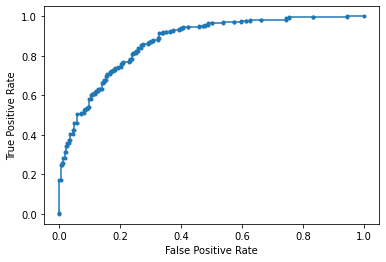

Accuracy: 79.73% Precision: 83.75% Recall: 83.29%
F1: 83.52% AUPRC: 91.02% AUROC: 87.04%
2023-02-14 13:44:36.297524
Fold 8
FIT
2023-02-14 13:44:42.629290
PREDICT
2023-02-14 13:44:49.464908


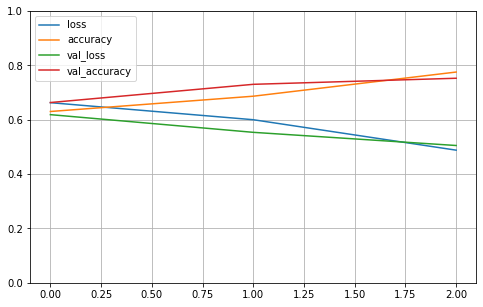

Train set ones/size 3336 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 386 / 582
Range of scores: 0.032958757 to 0.99704033
Score threshold 0.5
Prediction set ones/size 438 / 582


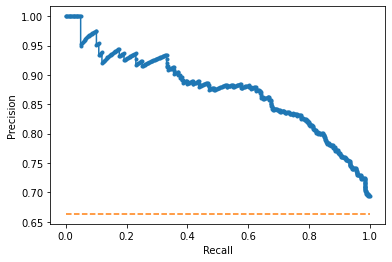

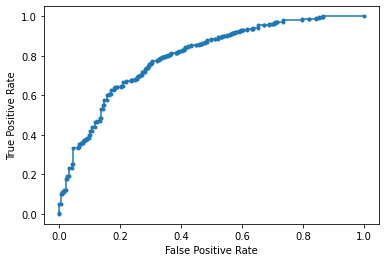

Accuracy: 75.26% Precision: 77.63% Recall: 88.08%
F1: 82.52% AUPRC: 87.39% AUROC: 79.80%
2023-02-14 13:44:50.316685
Fold 9
FIT
2023-02-14 13:44:56.996091
PREDICT
2023-02-14 13:45:04.007435


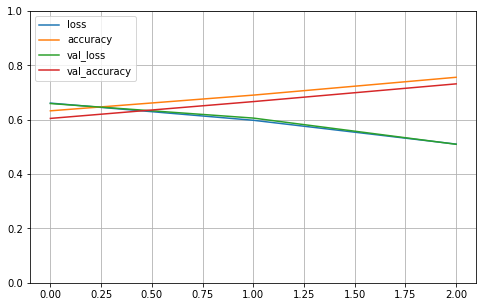

Train set ones/size 1833 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 230 / 582
Range of scores: 0.005209899 to 0.96512693
Score threshold 0.5
Prediction set ones/size 226 / 582


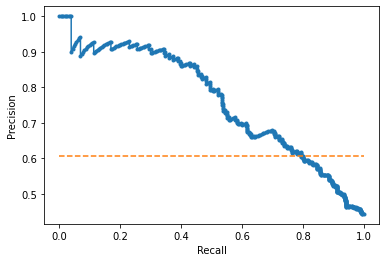

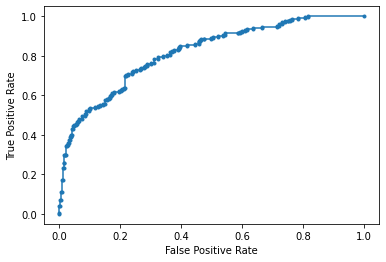

Accuracy: 73.20% Precision: 66.37% Recall: 65.22%
F1: 65.79% AUPRC: 76.13% AUROC: 81.67%
2023-02-14 13:45:04.701045
Fold 10
FIT
2023-02-14 13:45:13.376092
PREDICT
2023-02-14 13:45:25.108096


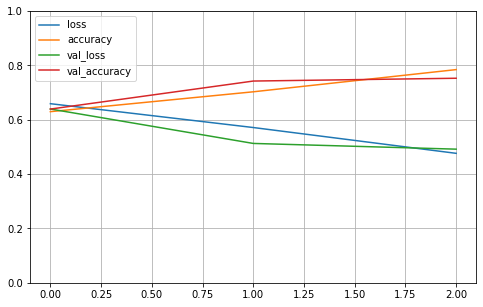

Train set ones/size 1923 / 5241
Compute valiation accuracy
Valid sizes (582, 4997) (582,)
Valid set ones/size 209 / 582
Range of scores: 0.0025294926 to 0.9716009
Score threshold 0.5
Prediction set ones/size 111 / 582


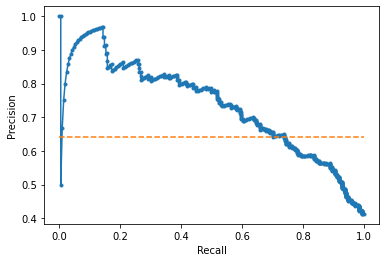

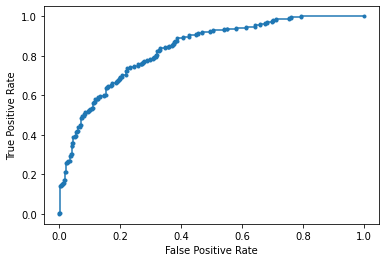

Accuracy: 75.26% Precision: 79.28% Recall: 42.11%
F1: 55.00% AUPRC: 73.27% AUROC: 83.42%
2023-02-14 13:45:25.769495

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.27% +/- 2.56
 precision mean 77.91% +/- 7.14
 recall mean 60.77% +/- 23.65
 F1 mean 65.36% +/- 15.08
 AUPRC mean 78.42% +/- 7.36
 AUROC mean 82.81% +/- 2.32
Finished cell Line 2 HeLa.S3

2023-02-14 13:45:27.098019
Start cell Line 3 HepG2
Number of RCI values loaded 1362
Num RCI: 1362
Load sequence...
Cross validation...
2023-02-14 13:45:40.318132
splitting
Fold 1
FIT
2023-02-14 13:45:50.392441
PREDICT
2023-02-14 13:45:59.455476


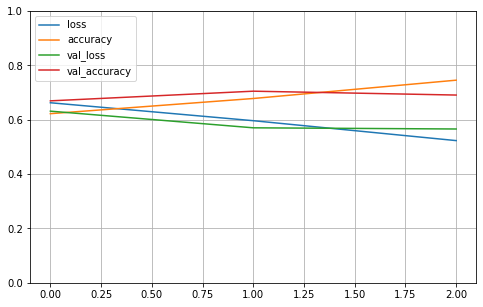

Train set ones/size 2805 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 310 / 844
Range of scores: 0.014197017 to 0.987087
Score threshold 0.5
Prediction set ones/size 419 / 844


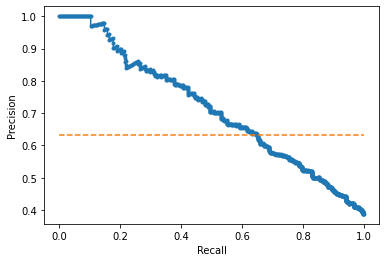

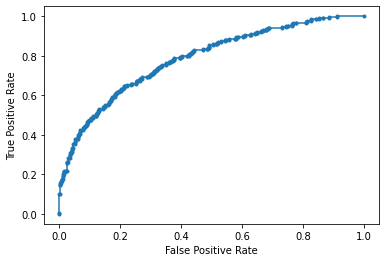

Accuracy: 69.08% Precision: 55.85% Recall: 75.48%
F1: 64.20% AUPRC: 71.46% AUROC: 78.61%
2023-02-14 13:46:00.140757
Fold 2
FIT
2023-02-14 13:46:12.508585
PREDICT
2023-02-14 13:46:23.990233


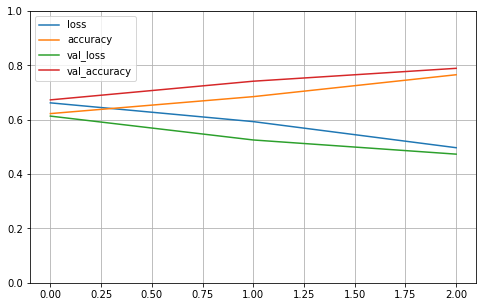

Train set ones/size 4784 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 537 / 844
Range of scores: 0.03492537 to 0.99236214
Score threshold 0.5
Prediction set ones/size 631 / 844


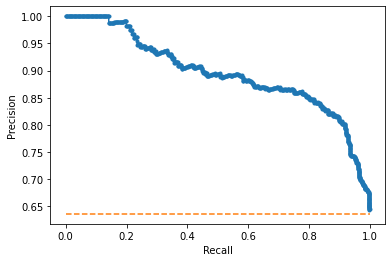

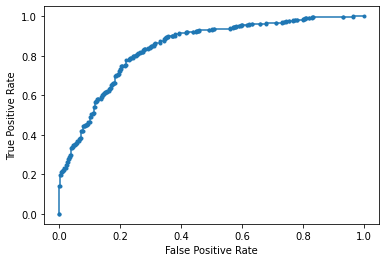

Accuracy: 78.91% Precision: 78.45% Recall: 92.18%
F1: 84.76% AUPRC: 89.55% AUROC: 84.20%
2023-02-14 13:46:24.680128
Fold 3
FIT
2023-02-14 13:46:37.186172
PREDICT
2023-02-14 13:46:48.662377


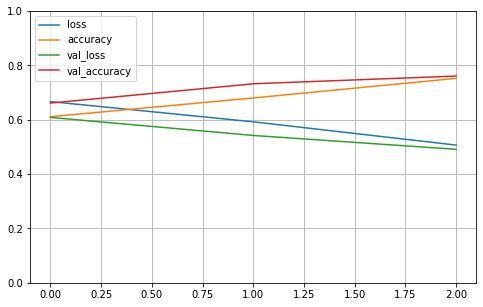

Train set ones/size 2830 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 299 / 844
Range of scores: 0.0025544513 to 0.9707893
Score threshold 0.5
Prediction set ones/size 167 / 844


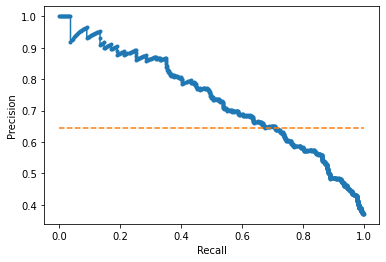

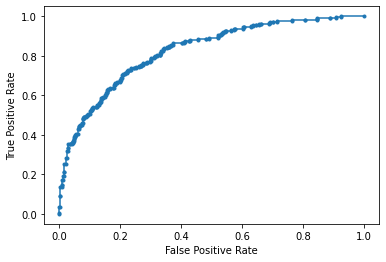

Accuracy: 76.07% Precision: 79.04% Recall: 44.15%
F1: 56.65% AUPRC: 73.59% AUROC: 82.47%
2023-02-14 13:46:49.477463
Fold 4
FIT
2023-02-14 13:47:01.769297
PREDICT
2023-02-14 13:47:10.196664


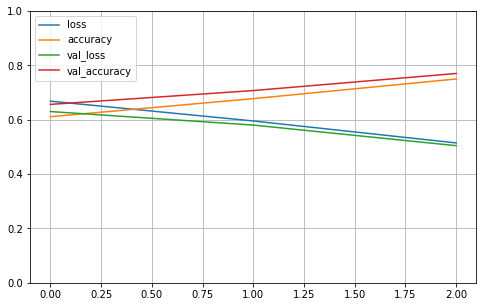

Train set ones/size 4757 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 548 / 844
Range of scores: 0.018279726 to 0.99132395
Score threshold 0.5
Prediction set ones/size 616 / 844


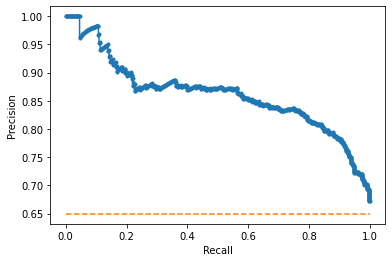

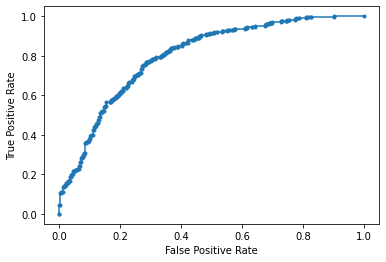

Accuracy: 77.01% Precision: 78.73% Recall: 88.50%
F1: 83.33% AUPRC: 86.19% AUROC: 79.96%
2023-02-14 13:47:10.868341
Fold 5
FIT
2023-02-14 13:47:21.310224
PREDICT
2023-02-14 13:47:32.811503


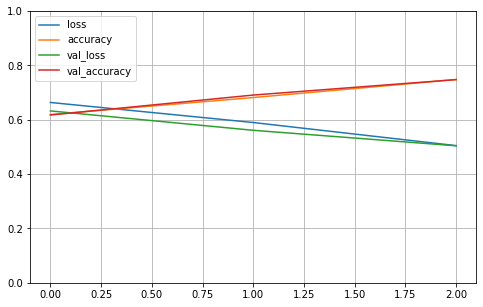

Train set ones/size 2806 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 328 / 844
Range of scores: 0.0005633595 to 0.98126376
Score threshold 0.5
Prediction set ones/size 191 / 844


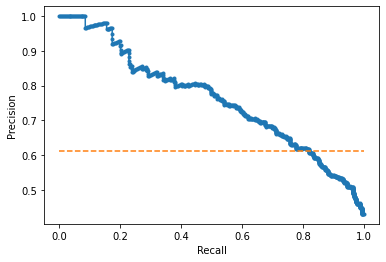

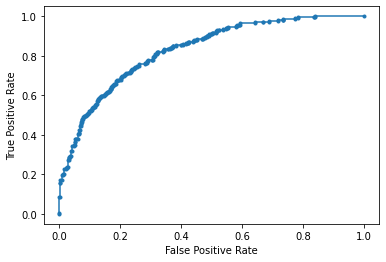

Accuracy: 74.76% Precision: 80.10% Recall: 46.65%
F1: 58.96% AUPRC: 76.18% AUROC: 82.90%
2023-02-14 13:47:33.480047
Fold 6
FIT
2023-02-14 13:47:45.570376
PREDICT
2023-02-14 13:47:57.087680


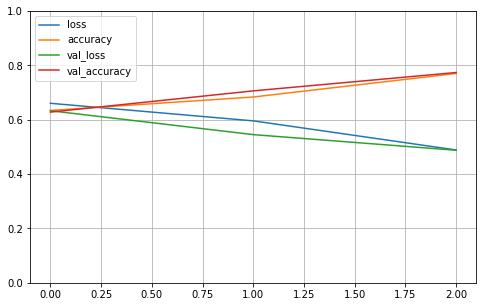

Train set ones/size 4843 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 525 / 844
Range of scores: 0.010014724 to 0.9831887
Score threshold 0.5
Prediction set ones/size 560 / 844


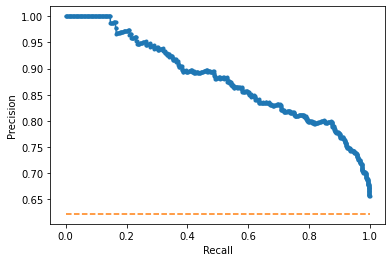

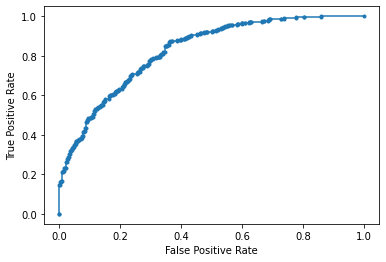

Accuracy: 77.37% Precision: 79.82% Recall: 85.14%
F1: 82.40% AUPRC: 87.96% AUROC: 82.61%
2023-02-14 13:47:57.762704
Fold 7
FIT
2023-02-14 13:48:11.166508
PREDICT
2023-02-14 13:48:19.786057


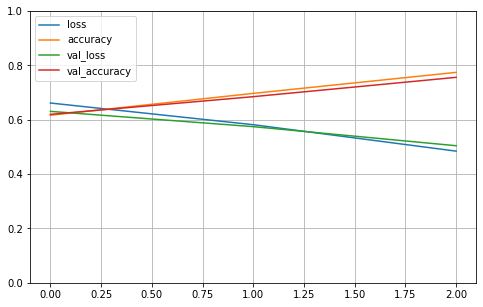

Train set ones/size 4754 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 537 / 844
Range of scores: 0.011966543 to 0.98809296
Score threshold 0.5
Prediction set ones/size 489 / 844


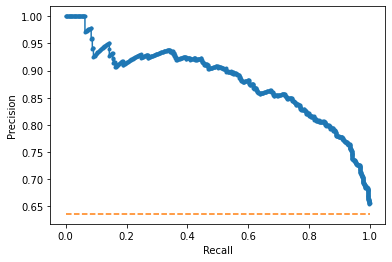

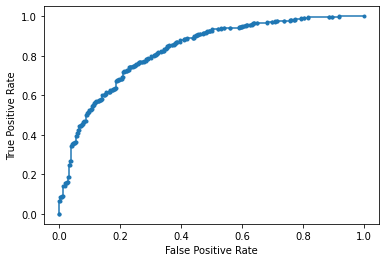

Accuracy: 75.59% Precision: 83.84% Recall: 76.35%
F1: 79.92% AUPRC: 88.13% AUROC: 82.88%
2023-02-14 13:48:20.746825
Fold 8
FIT
2023-02-14 13:48:31.457223
PREDICT
2023-02-14 13:48:40.807876


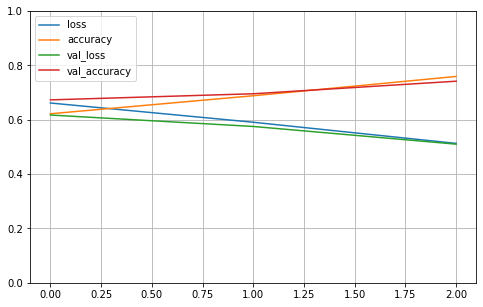

Train set ones/size 2816 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 333 / 844
Range of scores: 0.010268781 to 0.980757
Score threshold 0.5
Prediction set ones/size 217 / 844


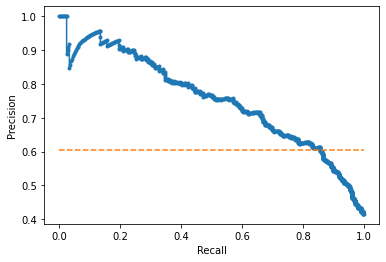

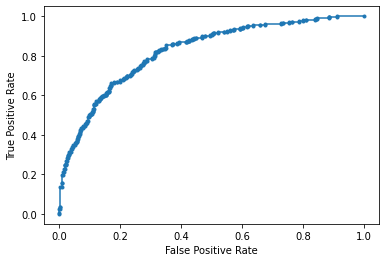

Accuracy: 74.17% Precision: 76.50% Recall: 49.85%
F1: 60.36% AUPRC: 75.43% AUROC: 82.30%
2023-02-14 13:48:41.492612
Fold 9
FIT
2023-02-14 13:48:52.918873
PREDICT
2023-02-14 13:49:01.860845


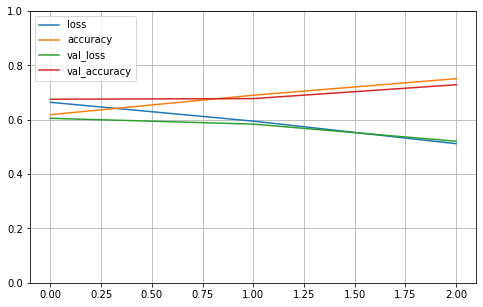

Train set ones/size 4794 / 7595
Compute valiation accuracy
Valid sizes (844, 4997) (844,)
Valid set ones/size 530 / 844
Range of scores: 0.049564905 to 0.9915978
Score threshold 0.5
Prediction set ones/size 693 / 844


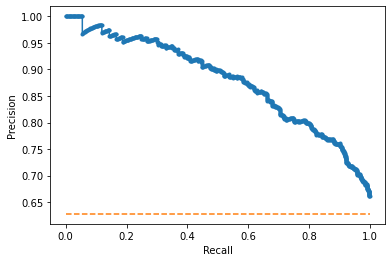

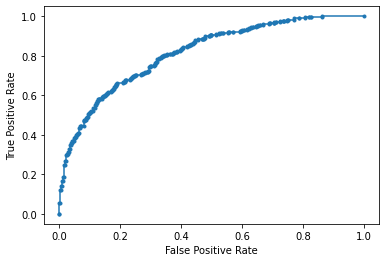

Accuracy: 72.87% Precision: 71.72% Recall: 93.77%
F1: 81.28% AUPRC: 87.90% AUROC: 81.61%
2023-02-14 13:49:02.541380
Fold 10
FIT
2023-02-14 13:49:11.945428
PREDICT
2023-02-14 13:49:23.869042


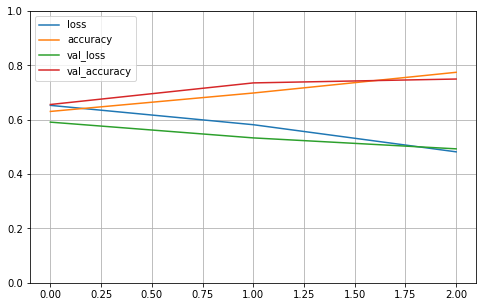

Train set ones/size 4792 / 7596
Compute valiation accuracy
Valid sizes (843, 4997) (843,)
Valid set ones/size 532 / 843
Range of scores: 0.02140941 to 0.9959771
Score threshold 0.5
Prediction set ones/size 631 / 843


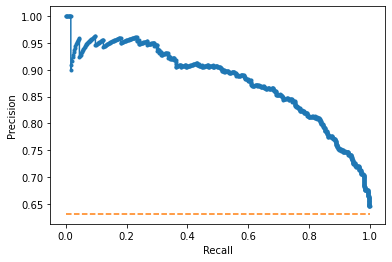

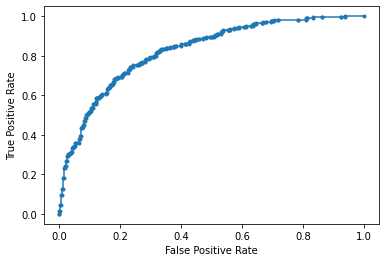

Accuracy: 74.97% Precision: 75.44% Recall: 89.47%
F1: 81.86% AUPRC: 87.92% AUROC: 82.63%
2023-02-14 13:49:24.542155

Completed cross validation 10 folds 3 epochs
 accuracy mean 75.08% +/- 2.72
 precision mean 75.95% +/- 7.75
 recall mean 74.15% +/- 19.79
 F1 mean 73.37% +/- 11.68
 AUPRC mean 82.43% +/- 7.26
 AUROC mean 82.02% +/- 1.61
Finished cell Line 3 HepG2

2023-02-14 13:49:26.005351
Start cell Line 4 HT1080
Number of RCI values loaded 936
Num RCI: 936
Load sequence...
Cross validation...
2023-02-14 13:49:36.606718
splitting
Fold 1
FIT
2023-02-14 13:49:47.278808
PREDICT
2023-02-14 13:49:58.799326


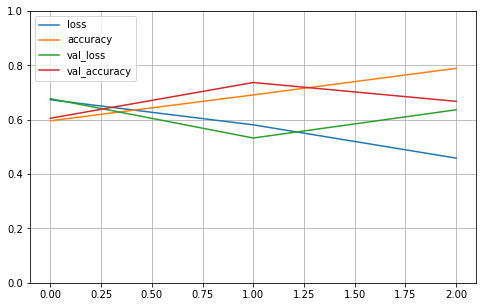

Train set ones/size 3833 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 425 / 707
Range of scores: 0.0017263185 to 0.9876835
Score threshold 0.5
Prediction set ones/size 236 / 707


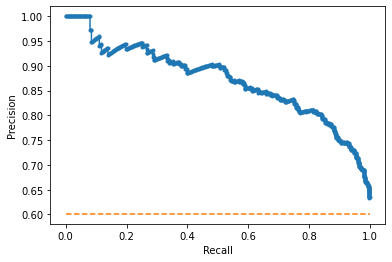

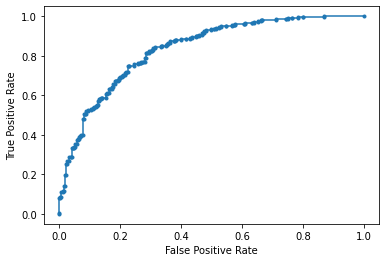

Accuracy: 66.76% Precision: 90.25% Recall: 50.12%
F1: 64.45% AUPRC: 87.11% AUROC: 83.51%
2023-02-14 13:49:59.482358
Fold 2
FIT
2023-02-14 13:50:11.506906
PREDICT
2023-02-14 13:50:22.978773


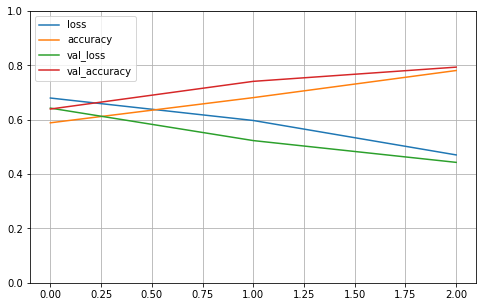

Train set ones/size 2527 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 279 / 707
Range of scores: 0.004320007 to 0.99326754
Score threshold 0.5
Prediction set ones/size 291 / 707


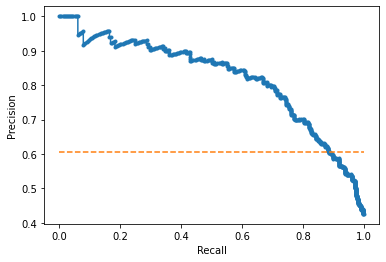

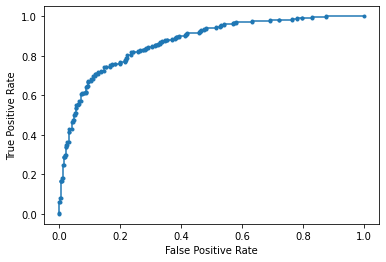

Accuracy: 79.35% Precision: 72.85% Recall: 75.99%
F1: 74.39% AUPRC: 82.05% AUROC: 87.08%
2023-02-14 13:50:23.679535
Fold 3
FIT
2023-02-14 13:50:35.397648
PREDICT
2023-02-14 13:50:46.927524


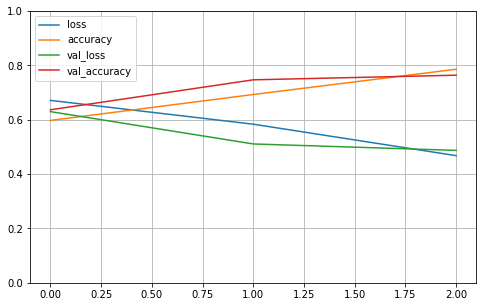

Train set ones/size 2536 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 270 / 707
Range of scores: 0.00084707607 to 0.9915828
Score threshold 0.5
Prediction set ones/size 363 / 707


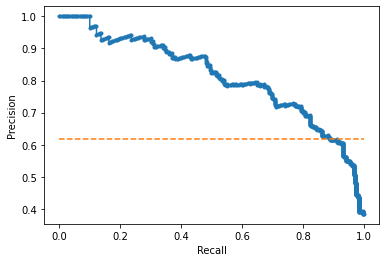

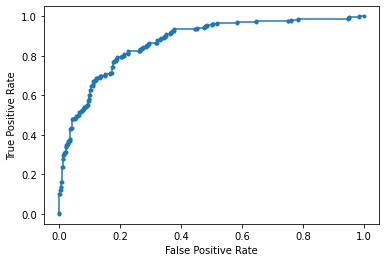

Accuracy: 76.38% Precision: 64.19% Recall: 86.30%
F1: 73.62% AUPRC: 81.20% AUROC: 87.01%
2023-02-14 13:50:47.660363
Fold 4
FIT
2023-02-14 13:50:59.363177
PREDICT
2023-02-14 13:51:07.261721


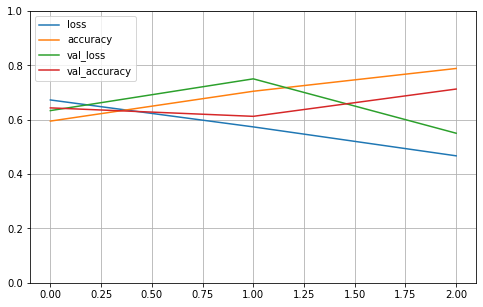

Train set ones/size 2499 / 6357
Compute valiation accuracy
Valid sizes (707, 4997) (707,)
Valid set ones/size 307 / 707
Range of scores: 0.0026564721 to 0.9904731
Score threshold 0.5
Prediction set ones/size 304 / 707


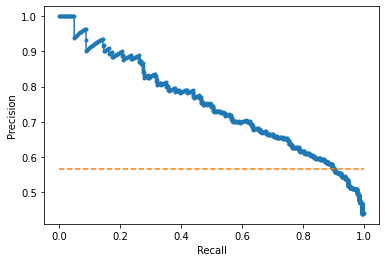

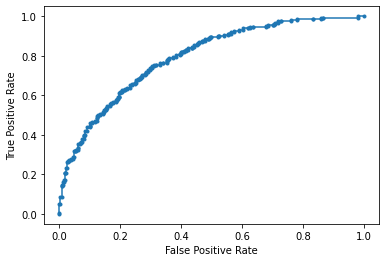

Accuracy: 71.29% Precision: 67.11% Recall: 66.45%
F1: 66.78% AUPRC: 74.77% AUROC: 79.34%
2023-02-14 13:51:07.948317
Fold 5
FIT
2023-02-14 13:51:20.276583
PREDICT
2023-02-14 13:51:31.785929


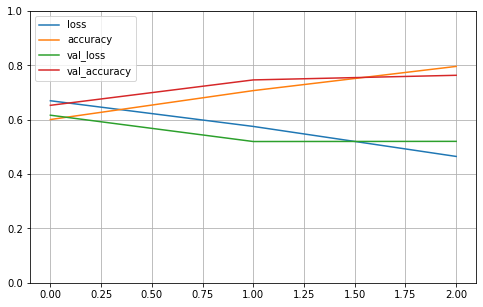

Train set ones/size 2521 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 284 / 706
Range of scores: 0.0012492762 to 0.94188917
Score threshold 0.5
Prediction set ones/size 171 / 706


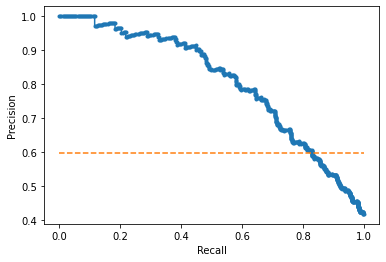

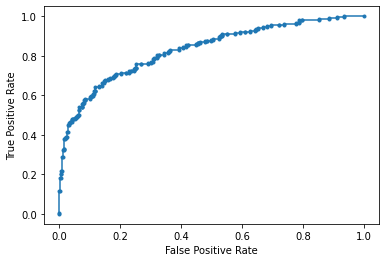

Accuracy: 76.35% Precision: 84.21% Recall: 50.70%
F1: 63.30% AUPRC: 80.57% AUROC: 83.17%
2023-02-14 13:51:32.480517
Fold 6
FIT
2023-02-14 13:51:44.707279
PREDICT
2023-02-14 13:51:53.198998


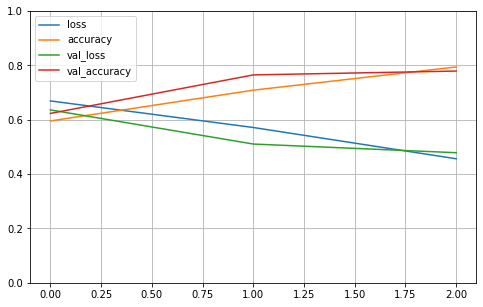

Train set ones/size 2511 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 275 / 706
Range of scores: 0.0008961402 to 0.9806983
Score threshold 0.5
Prediction set ones/size 189 / 706


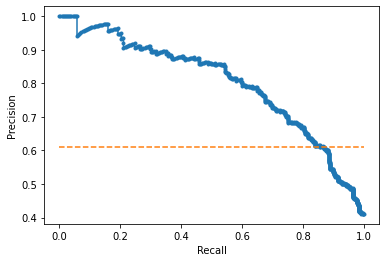

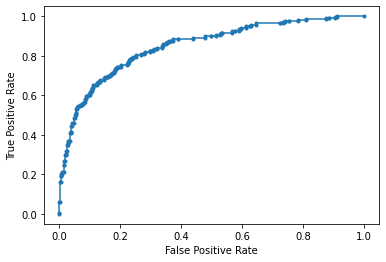

Accuracy: 77.90% Precision: 81.48% Recall: 56.00%
F1: 66.38% AUPRC: 80.17% AUROC: 84.95%
2023-02-14 13:51:53.916839
Fold 7
FIT
2023-02-14 13:52:03.871031
PREDICT
2023-02-14 13:52:15.761175


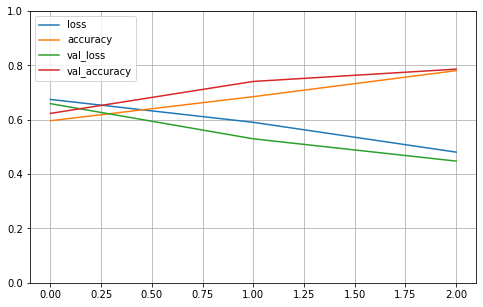

Train set ones/size 2514 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 291 / 706
Range of scores: 0.0054114456 to 0.99020725
Score threshold 0.5
Prediction set ones/size 266 / 706


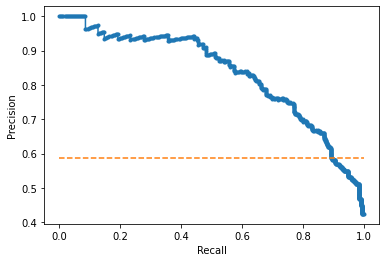

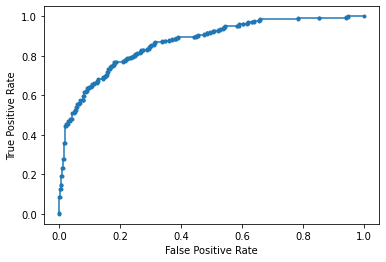

Accuracy: 78.61% Precision: 76.32% Recall: 69.76%
F1: 72.89% AUPRC: 83.44% AUROC: 86.67%
2023-02-14 13:52:16.541327
Fold 8
FIT
2023-02-14 13:52:27.619710
PREDICT
2023-02-14 13:52:39.100356


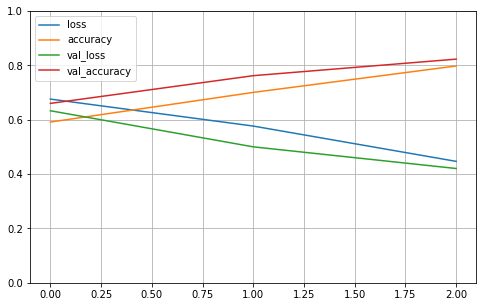

Train set ones/size 2538 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 268 / 706
Range of scores: 0.004016423 to 0.99458826
Score threshold 0.5
Prediction set ones/size 239 / 706


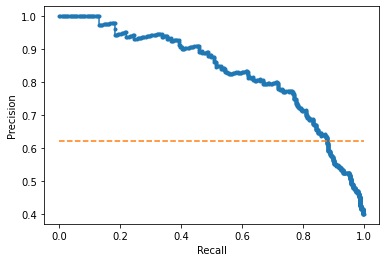

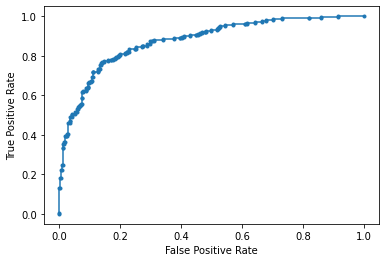

Accuracy: 82.29% Precision: 79.92% Recall: 71.27%
F1: 75.35% AUPRC: 83.18% AUROC: 87.67%
2023-02-14 13:52:39.801562
Fold 9
FIT
2023-02-14 13:52:52.296939
PREDICT
2023-02-14 13:53:00.307633


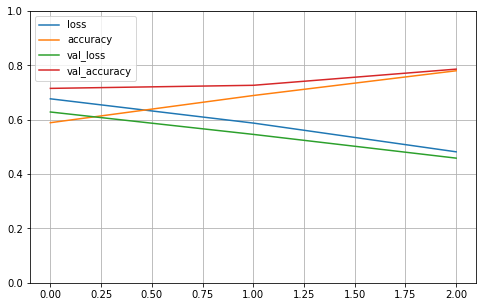

Train set ones/size 2538 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 274 / 706
Range of scores: 0.0034379389 to 0.9650957
Score threshold 0.5
Prediction set ones/size 189 / 706


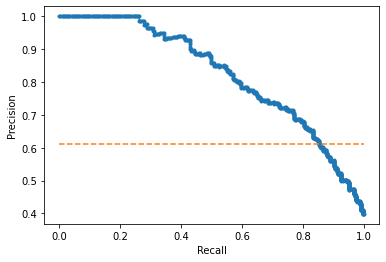

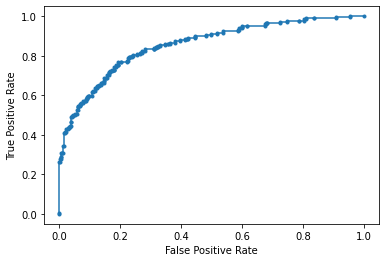

Accuracy: 78.61% Precision: 82.54% Recall: 56.93%
F1: 67.39% AUPRC: 82.37% AUROC: 85.58%
2023-02-14 13:53:00.969108
Fold 10
FIT
2023-02-14 13:53:12.611062
PREDICT
2023-02-14 13:53:24.092195


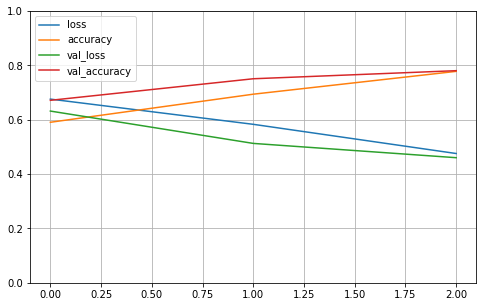

Train set ones/size 2533 / 6358
Compute valiation accuracy
Valid sizes (706, 4997) (706,)
Valid set ones/size 273 / 706
Range of scores: 0.002526591 to 0.98032606
Score threshold 0.5
Prediction set ones/size 164 / 706


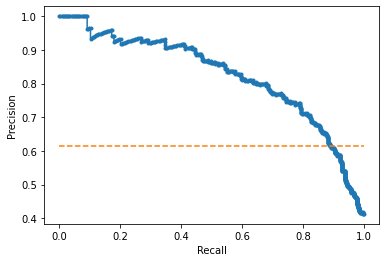

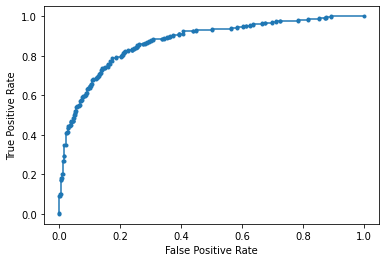

Accuracy: 78.05% Precision: 85.98% Recall: 51.65%
F1: 64.53% AUPRC: 82.48% AUROC: 87.27%
2023-02-14 13:53:25.070553

Completed cross validation 10 folds 3 epochs
 accuracy mean 76.56% +/- 4.43
 precision mean 78.48% +/- 8.33
 recall mean 63.52% +/- 12.32
 F1 mean 68.91% +/- 4.63
 AUPRC mean 81.73% +/- 3.12
 AUROC mean 85.23% +/- 2.60
Finished cell Line 4 HT1080

2023-02-14 13:53:26.454540
Start cell Line 5 HUVEC
Number of RCI values loaded 1488
Num RCI: 1488
Load sequence...
Cross validation...
2023-02-14 13:53:41.611186
splitting
Fold 1
FIT
2023-02-14 13:53:52.777273
PREDICT
2023-02-14 13:54:04.388707


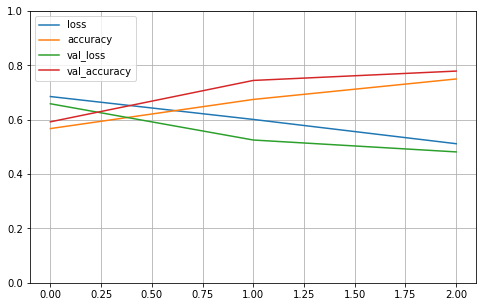

Train set ones/size 4704 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 547 / 959
Range of scores: 0.0072385627 to 0.9879566
Score threshold 0.5
Prediction set ones/size 517 / 959


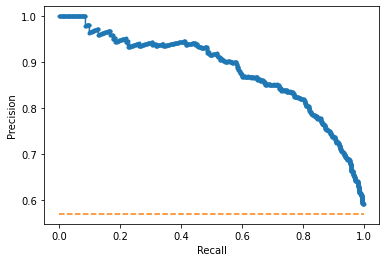

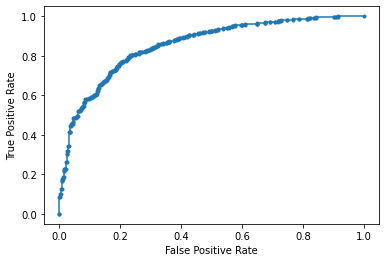

Accuracy: 77.89% Precision: 82.40% Recall: 77.88%
F1: 80.08% AUPRC: 88.28% AUROC: 85.45%
2023-02-14 13:54:05.289561
Fold 2
FIT
2023-02-14 13:54:17.518909
PREDICT
2023-02-14 13:54:27.091301


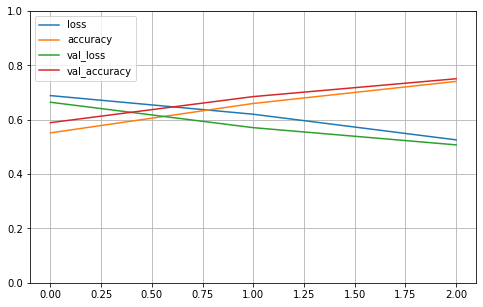

Train set ones/size 4708 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 544 / 959
Range of scores: 0.0046323515 to 0.9862321
Score threshold 0.5
Prediction set ones/size 623 / 959


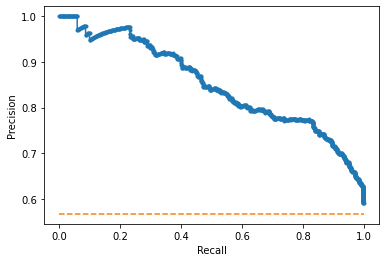

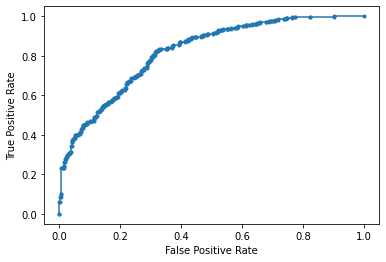

Accuracy: 75.08% Precision: 74.48% Recall: 85.29%
F1: 79.52% AUPRC: 85.12% AUROC: 81.99%
2023-02-14 13:54:27.891909
Fold 3
FIT
2023-02-14 13:54:39.325300
PREDICT
2023-02-14 13:54:49.652346


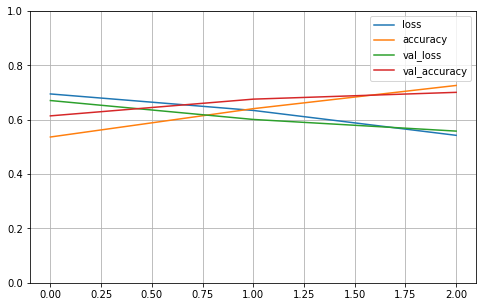

Train set ones/size 4733 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 530 / 959
Range of scores: 0.017369626 to 0.9650021
Score threshold 0.5
Prediction set ones/size 455 / 959


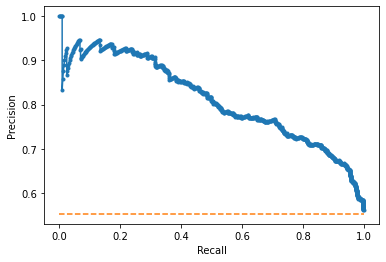

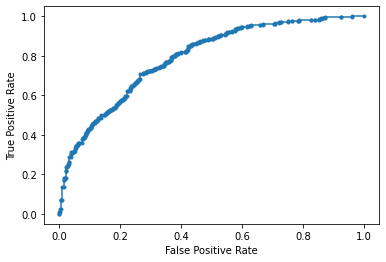

Accuracy: 70.07% Precision: 76.70% Recall: 65.85%
F1: 70.86% AUPRC: 81.18% AUROC: 79.07%
2023-02-14 13:54:50.546193
Fold 4
FIT
2023-02-14 13:55:02.515295
PREDICT
2023-02-14 13:55:14.168615


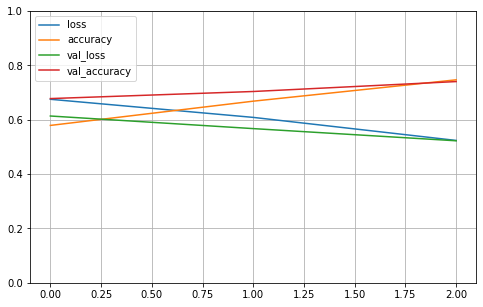

Train set ones/size 3834 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 465 / 959
Range of scores: 0.010741448 to 0.98756975
Score threshold 0.5
Prediction set ones/size 360 / 959


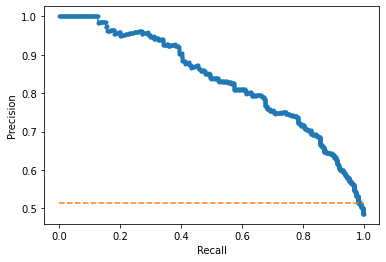

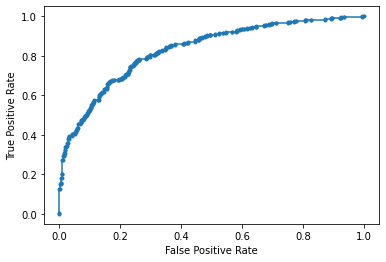

Accuracy: 74.04% Precision: 80.00% Recall: 61.94%
F1: 69.82% AUPRC: 83.35% AUROC: 83.05%
2023-02-14 13:55:14.900049
Fold 5
FIT
2023-02-14 13:55:27.334686
PREDICT
2023-02-14 13:55:37.766057


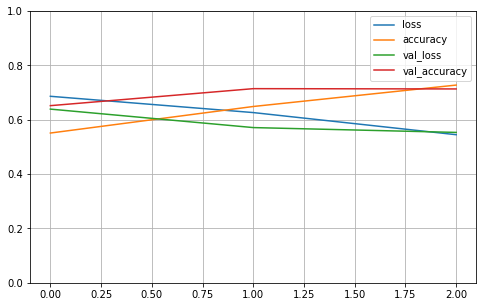

Train set ones/size 3930 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 408 / 959
Range of scores: 0.020918092 to 0.9937302
Score threshold 0.5
Prediction set ones/size 573 / 959


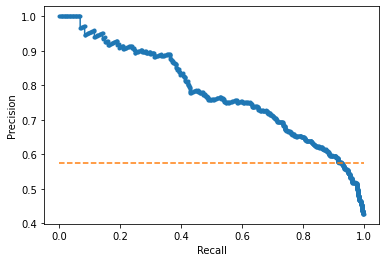

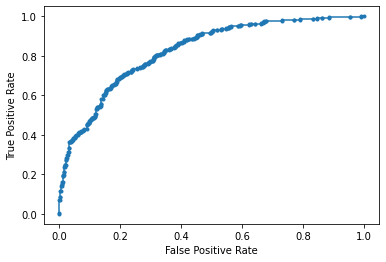

Accuracy: 71.32% Precision: 61.61% Recall: 86.52%
F1: 71.97% AUPRC: 78.11% AUROC: 82.60%
2023-02-14 13:55:38.555867
Fold 6
FIT
2023-02-14 13:55:51.890456
PREDICT
2023-02-14 13:56:01.791168


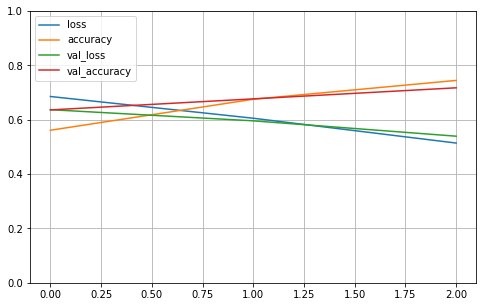

Train set ones/size 4763 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 527 / 959
Range of scores: 0.004149986 to 0.98790354
Score threshold 0.5
Prediction set ones/size 446 / 959


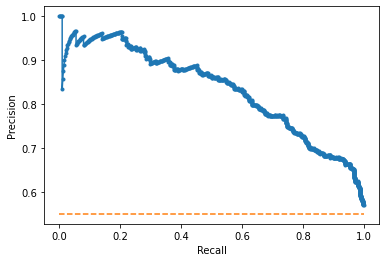

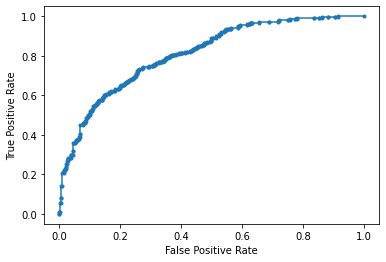

Accuracy: 71.74% Precision: 78.70% Recall: 66.60%
F1: 72.15% AUPRC: 83.36% AUROC: 81.14%
2023-02-14 13:56:02.961390
Fold 7
FIT
2023-02-14 13:56:14.024519
PREDICT
2023-02-14 13:56:24.632164


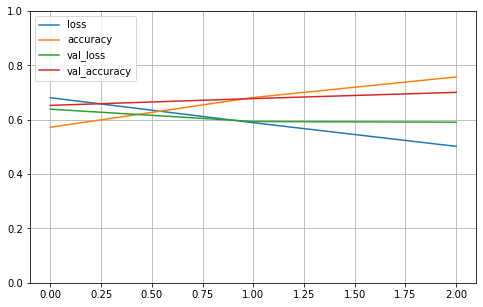

Train set ones/size 3911 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 465 / 959
Range of scores: 0.0022576742 to 0.99944943
Score threshold 0.5
Prediction set ones/size 224 / 959


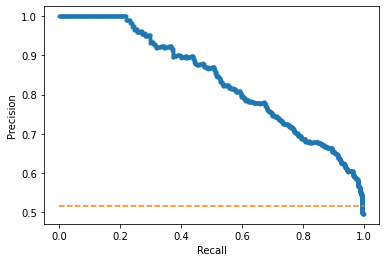

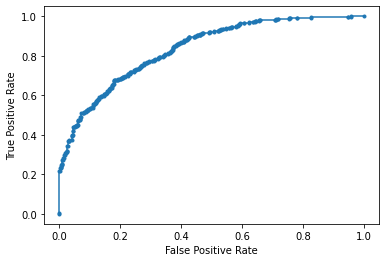

Accuracy: 70.07% Precision: 89.73% Recall: 43.23%
F1: 58.35% AUPRC: 83.74% AUROC: 83.59%
2023-02-14 13:56:25.592208
Fold 8
FIT
2023-02-14 13:56:38.718285
PREDICT
2023-02-14 13:56:49.106794


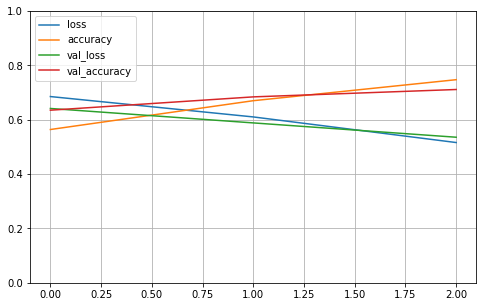

Train set ones/size 4728 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 523 / 959
Range of scores: 0.010084745 to 0.9814384
Score threshold 0.5
Prediction set ones/size 582 / 959


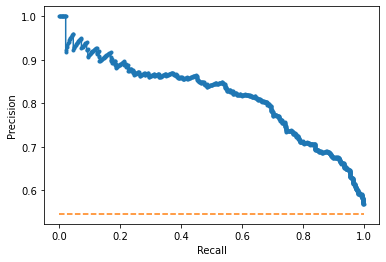

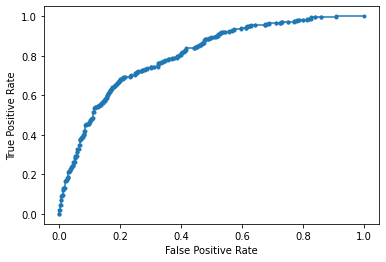

Accuracy: 71.12% Precision: 71.13% Recall: 79.16%
F1: 74.93% AUPRC: 81.64% AUROC: 80.35%
2023-02-14 13:56:49.908727
Fold 9
FIT
2023-02-14 13:57:02.184915
PREDICT
2023-02-14 13:57:12.452706


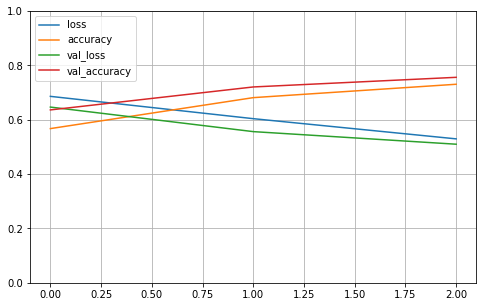

Train set ones/size 3915 / 8630
Compute valiation accuracy
Valid sizes (959, 4997) (959,)
Valid set ones/size 423 / 959
Range of scores: 0.03216175 to 0.9973105
Score threshold 0.5
Prediction set ones/size 471 / 959


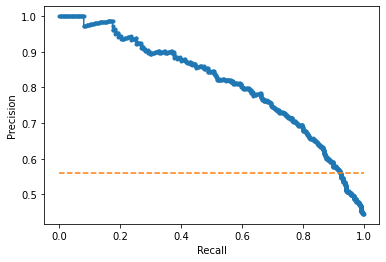

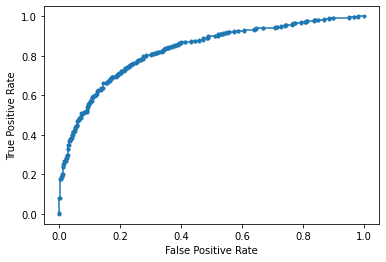

Accuracy: 75.60% Precision: 70.06% Recall: 78.01%
F1: 73.83% AUPRC: 81.23% AUROC: 83.12%
2023-02-14 13:57:13.343653
Fold 10
FIT
2023-02-14 13:57:25.305612
PREDICT
2023-02-14 13:57:36.938099


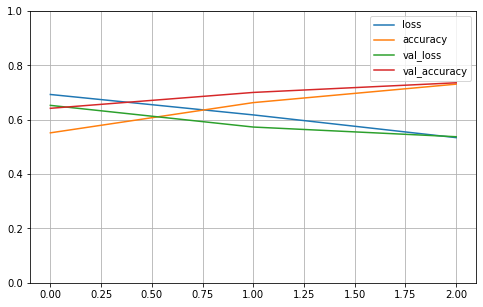

Train set ones/size 3883 / 8631
Compute valiation accuracy
Valid sizes (958, 4997) (958,)
Valid set ones/size 443 / 958
Range of scores: 0.015418066 to 0.9836166
Score threshold 0.5
Prediction set ones/size 368 / 958


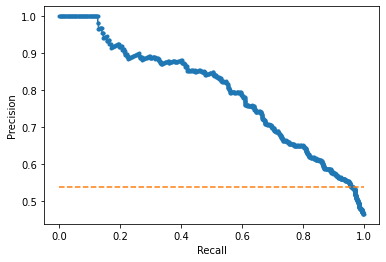

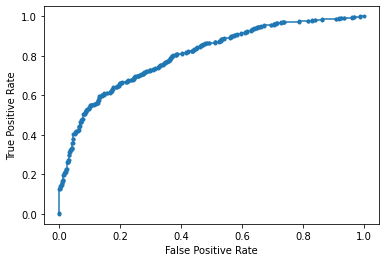

Accuracy: 73.59% Precision: 75.82% Recall: 62.98%
F1: 68.80% AUPRC: 79.46% AUROC: 80.40%
2023-02-14 13:57:38.044141

Completed cross validation 10 folds 3 epochs
 accuracy mean 73.05% +/- 2.61
 precision mean 76.06% +/- 7.61
 recall mean 70.75% +/- 13.21
 F1 mean 72.03% +/- 6.11
 AUPRC mean 82.55% +/- 2.90
 AUROC mean 82.08% +/- 1.88
Finished cell Line 5 HUVEC

2023-02-14 13:57:39.513132
Start cell Line 6 MCF.7
Number of RCI values loaded 2156
Num RCI: 2156
Load sequence...
Cross validation...
2023-02-14 13:57:57.677327
splitting
Fold 1
FIT
2023-02-14 13:58:09.105748
PREDICT
2023-02-14 13:58:31.238945


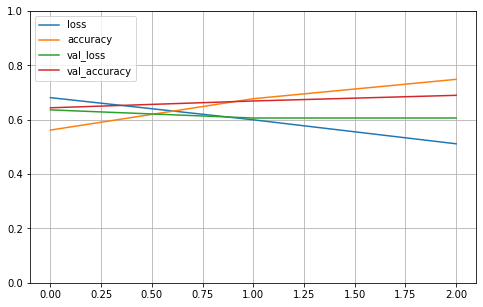

Train set ones/size 5022 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 518 / 1154
Range of scores: 0.016085017 to 0.99452305
Score threshold 0.5
Prediction set ones/size 696 / 1154


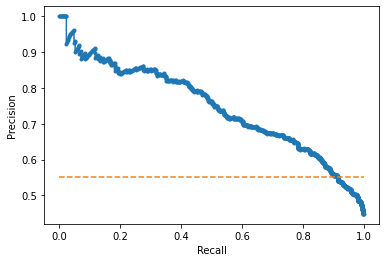

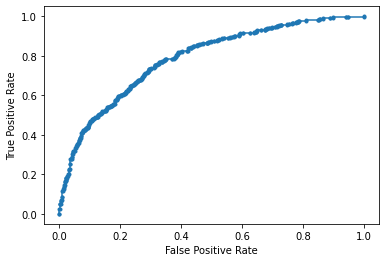

Accuracy: 68.98% Precision: 61.49% Recall: 82.63%
F1: 70.51% AUPRC: 74.74% AUROC: 78.64%
2023-02-14 13:58:32.079209
Fold 2
FIT
2023-02-14 13:58:42.313606
PREDICT
2023-02-14 13:58:54.587686


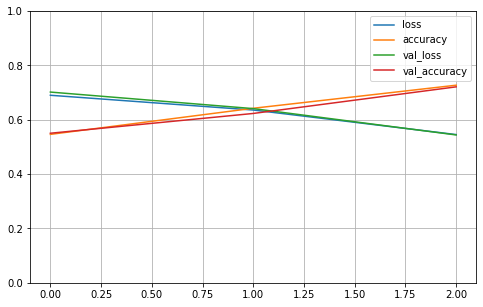

Train set ones/size 5532 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 615 / 1154
Range of scores: 0.0049816123 to 0.98644817
Score threshold 0.5
Prediction set ones/size 525 / 1154


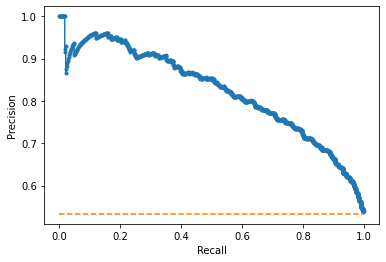

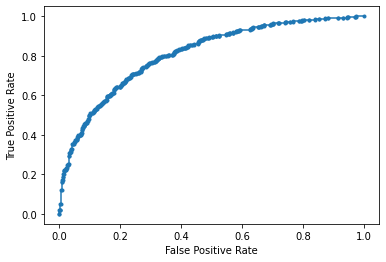

Accuracy: 72.10% Precision: 77.90% Recall: 66.50%
F1: 71.75% AUPRC: 82.38% AUROC: 80.87%
2023-02-14 13:58:55.814677
Fold 3
FIT
2023-02-14 13:59:06.256846
PREDICT
2023-02-14 13:59:28.423885


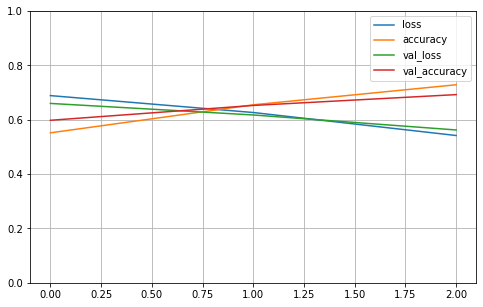

Train set ones/size 5425 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 588 / 1154
Range of scores: 0.024928538 to 0.9902858
Score threshold 0.5
Prediction set ones/size 815 / 1154


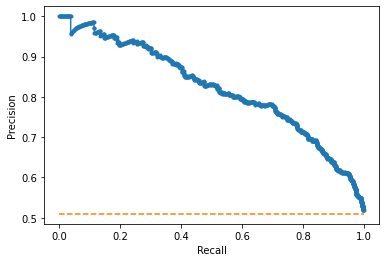

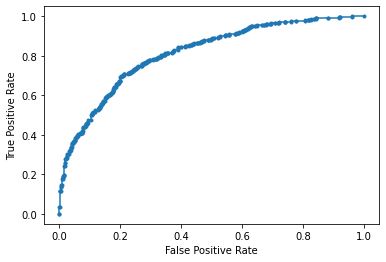

Accuracy: 69.24% Precision: 64.29% Recall: 89.12%
F1: 74.70% AUPRC: 82.16% AUROC: 81.38%
2023-02-14 13:59:29.376444
Fold 4
FIT
2023-02-14 13:59:44.261910
PREDICT
2023-02-14 13:59:56.458261


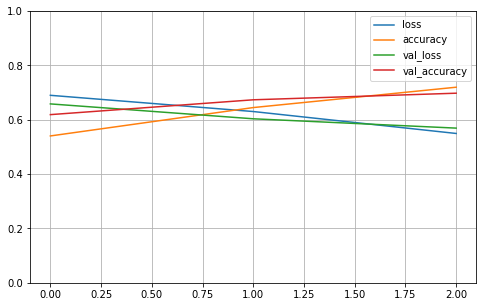

Train set ones/size 5404 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 603 / 1154
Range of scores: 0.016115224 to 0.9920826
Score threshold 0.5
Prediction set ones/size 672 / 1154


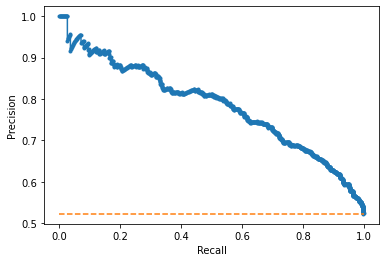

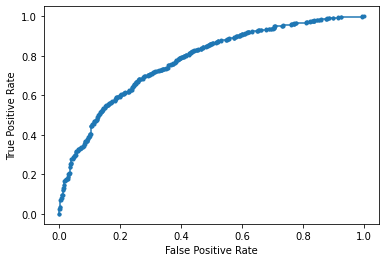

Accuracy: 69.76% Precision: 68.90% Recall: 76.78%
F1: 72.63% AUPRC: 78.57% AUROC: 77.59%
2023-02-14 13:59:57.283916
Fold 5
FIT
2023-02-14 14:00:08.964572
PREDICT
2023-02-14 14:00:21.048256


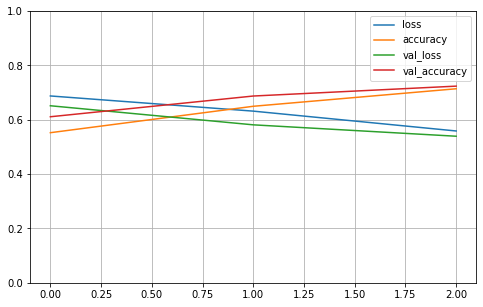

Train set ones/size 4814 / 10381
Compute valiation accuracy
Valid sizes (1154, 4997) (1154,)
Valid set ones/size 566 / 1154
Range of scores: 0.010426694 to 0.98439956
Score threshold 0.5
Prediction set ones/size 437 / 1154


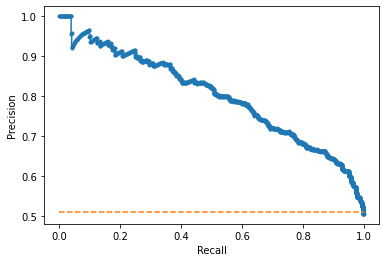

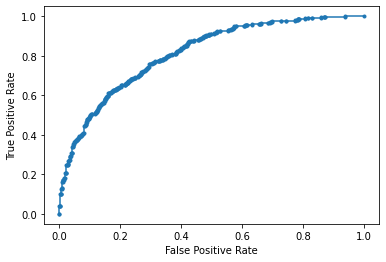

Accuracy: 72.36% Precision: 78.26% Recall: 60.42%
F1: 68.20% AUPRC: 80.13% AUROC: 81.25%
2023-02-14 14:00:22.010600
Fold 6
FIT
2023-02-14 14:00:34.865211
PREDICT
2023-02-14 14:00:46.932189


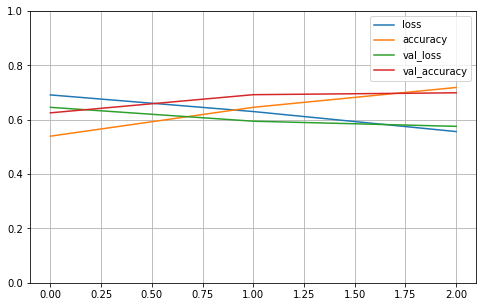

Train set ones/size 5466 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 588 / 1153
Range of scores: 0.008407486 to 0.97792655
Score threshold 0.5
Prediction set ones/size 401 / 1153


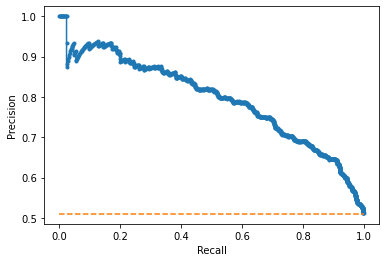

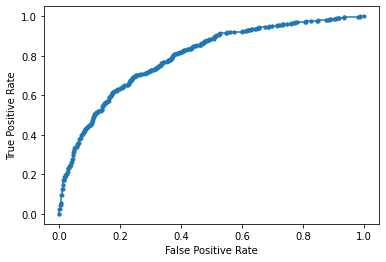

Accuracy: 69.90% Precision: 80.05% Recall: 54.59%
F1: 64.91% AUPRC: 79.49% AUROC: 79.49%
2023-02-14 14:00:47.777568
Fold 7
FIT
2023-02-14 14:01:04.597641
PREDICT
2023-02-14 14:01:26.582234


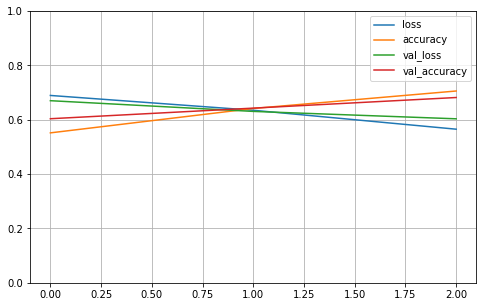

Train set ones/size 5447 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 609 / 1153
Range of scores: 0.016064472 to 0.97843564
Score threshold 0.5
Prediction set ones/size 766 / 1153


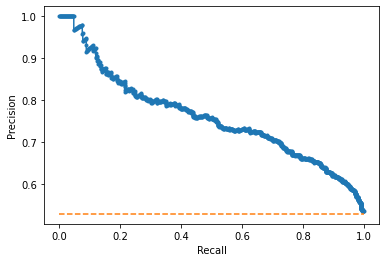

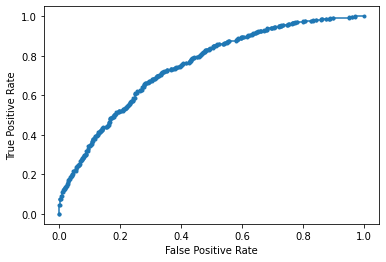

Accuracy: 68.17% Precision: 65.80% Recall: 82.76%
F1: 73.31% AUPRC: 76.05% AUROC: 74.87%
2023-02-14 14:01:27.400956
Fold 8
FIT
2023-02-14 14:01:40.809939
PREDICT
2023-02-14 14:02:02.812686


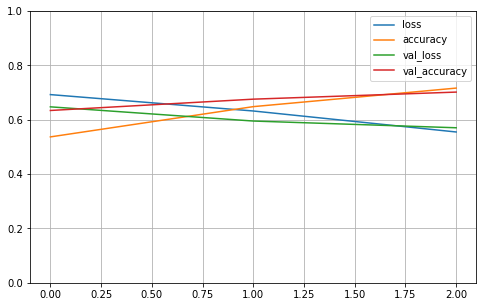

Train set ones/size 4932 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 539 / 1153
Range of scores: 0.018911278 to 0.98635626
Score threshold 0.5
Prediction set ones/size 411 / 1153


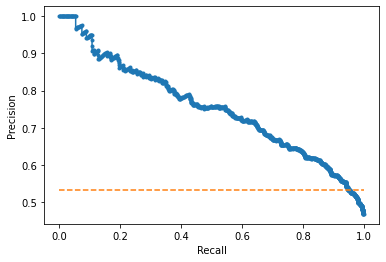

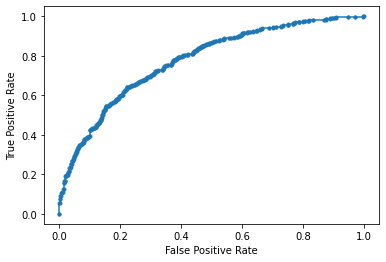

Accuracy: 70.16% Precision: 73.72% Recall: 56.22%
F1: 63.79% AUPRC: 75.47% AUROC: 77.68%
2023-02-14 14:02:03.659389
Fold 9
FIT
2023-02-14 14:02:14.907594
PREDICT
2023-02-14 14:02:37.010315


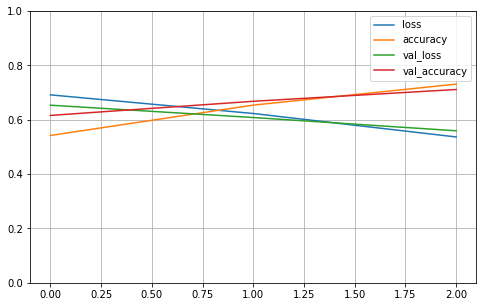

Train set ones/size 4995 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 549 / 1153
Range of scores: 0.034210585 to 0.99803025
Score threshold 0.5
Prediction set ones/size 628 / 1153


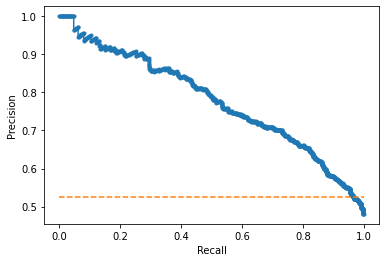

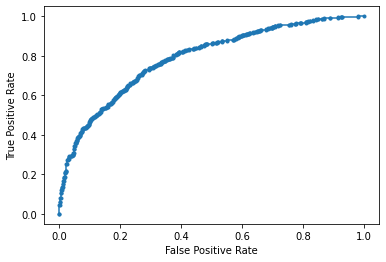

Accuracy: 71.12% Precision: 67.20% Recall: 76.87%
F1: 71.71% AUPRC: 77.91% AUROC: 78.90%
2023-02-14 14:02:37.970867
Fold 10
FIT
2023-02-14 14:02:48.122846
PREDICT
2023-02-14 14:02:59.956374


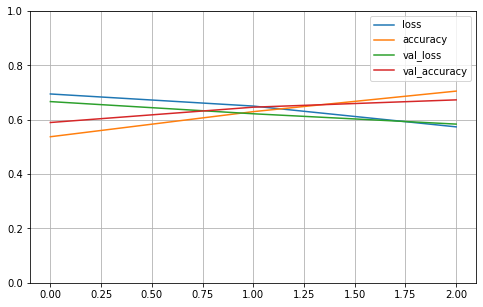

Train set ones/size 4936 / 10382
Compute valiation accuracy
Valid sizes (1153, 4997) (1153,)
Valid set ones/size 547 / 1153
Range of scores: 0.01630394 to 0.9733513
Score threshold 0.5
Prediction set ones/size 440 / 1153


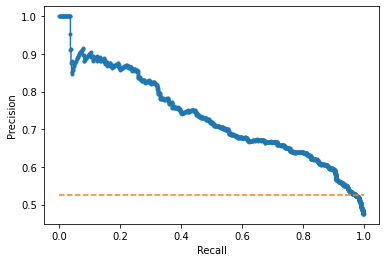

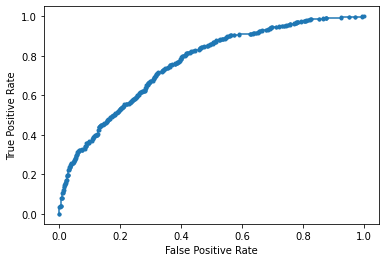

Accuracy: 67.30% Precision: 69.32% Recall: 55.76%
F1: 61.80% AUPRC: 73.50% AUROC: 76.11%
2023-02-14 14:03:00.778178

Completed cross validation 10 folds 3 epochs
 accuracy mean 69.91% +/- 1.61
 precision mean 70.69% +/- 6.44
 recall mean 70.16% +/- 12.97
 F1 mean 69.33% +/- 4.43
 AUPRC mean 78.04% +/- 3.07
 AUROC mean 78.68% +/- 2.18
Finished cell Line 6 MCF.7

2023-02-14 14:03:02.279144
Start cell Line 7 NCI.H460
Number of RCI values loaded 610
Num RCI: 610
Load sequence...
Cross validation...
2023-02-14 14:03:11.595571
splitting
Fold 1
FIT
2023-02-14 14:03:22.542667
PREDICT
2023-02-14 14:03:28.836253


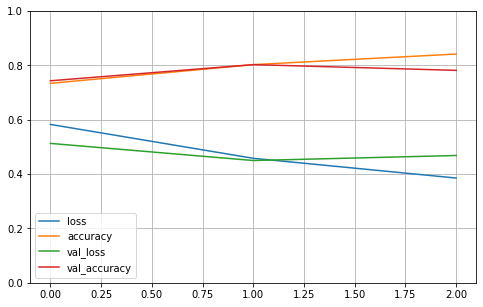

Train set ones/size 1213 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 134 / 522
Range of scores: 0.0013517991 to 0.9919658
Score threshold 0.5
Prediction set ones/size 164 / 522


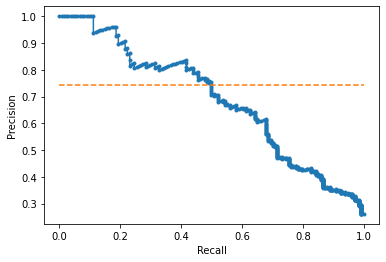

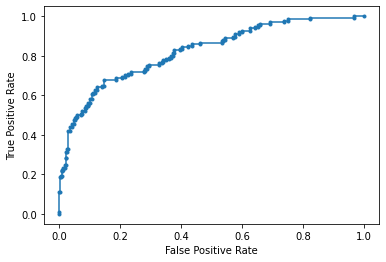

Accuracy: 78.16% Precision: 56.10% Recall: 68.66%
F1: 61.74% AUPRC: 68.67% AUROC: 82.30%
2023-02-14 14:03:29.526018
Fold 2
FIT
2023-02-14 14:03:41.938575
PREDICT
2023-02-14 14:03:53.381861


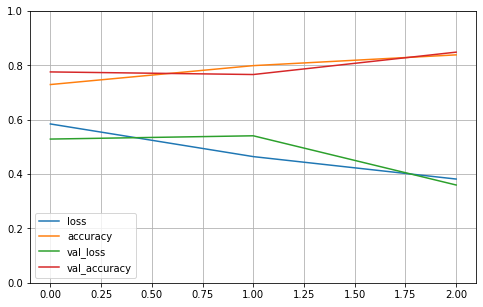

Train set ones/size 1245 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 130 / 522
Range of scores: 0.0018693312 to 0.983029
Score threshold 0.5
Prediction set ones/size 121 / 522


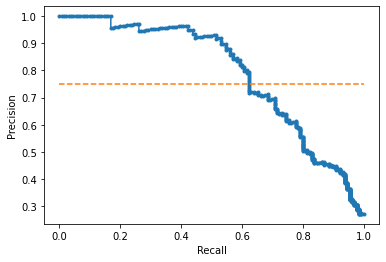

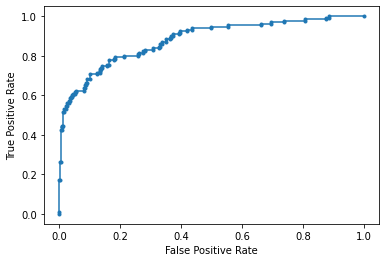

Accuracy: 84.87% Precision: 71.07% Recall: 66.15%
F1: 68.53% AUPRC: 79.08% AUROC: 88.07%
2023-02-14 14:03:54.057563
Fold 3
FIT
2023-02-14 14:04:05.594686
PREDICT
2023-02-14 14:04:11.722912


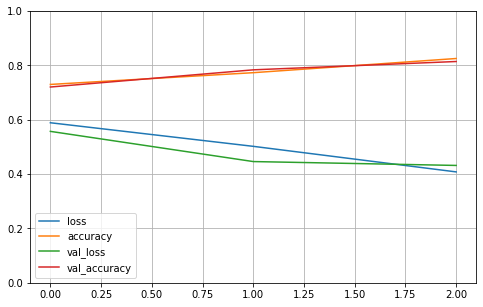

Train set ones/size 3480 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 376 / 522
Range of scores: 0.09102298 to 0.9989392
Score threshold 0.5
Prediction set ones/size 465 / 522


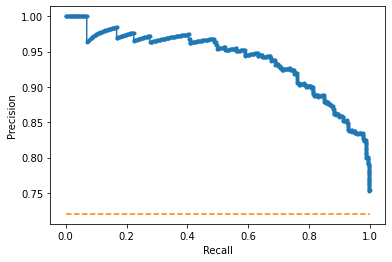

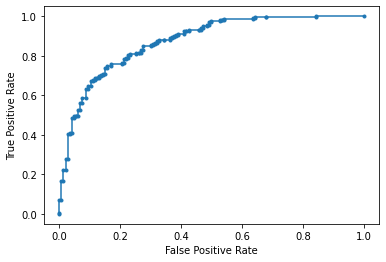

Accuracy: 81.42% Precision: 80.00% Recall: 98.94%
F1: 88.47% AUPRC: 93.97% AUROC: 87.55%
2023-02-14 14:04:12.544892
Fold 4
FIT
2023-02-14 14:04:20.808270
PREDICT
2023-02-14 14:04:27.333210


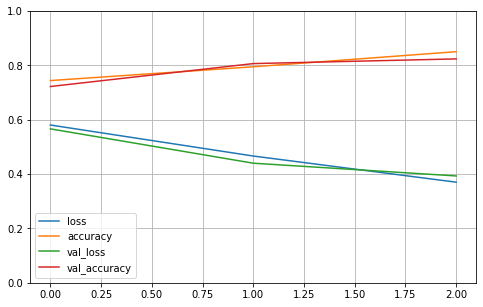

Train set ones/size 1183 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 145 / 522
Range of scores: 0.0014354945 to 0.96903
Score threshold 0.5
Prediction set ones/size 79 / 522


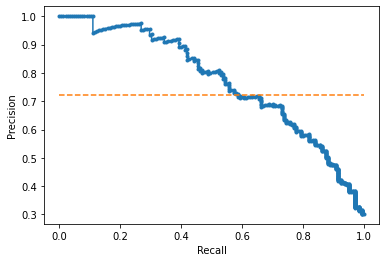

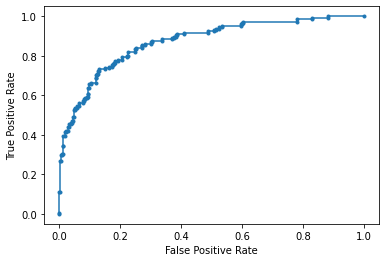

Accuracy: 82.38% Precision: 83.54% Recall: 45.52%
F1: 58.93% AUPRC: 77.11% AUROC: 87.27%
2023-02-14 14:04:28.275868
Fold 5
FIT
2023-02-14 14:04:38.350222
PREDICT
2023-02-14 14:04:50.165437


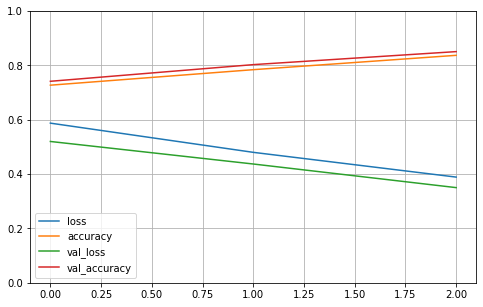

Train set ones/size 1240 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 135 / 522
Range of scores: 0.0023237416 to 0.96188825
Score threshold 0.5
Prediction set ones/size 105 / 522


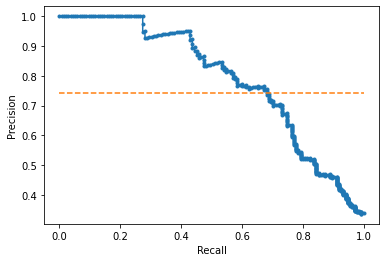

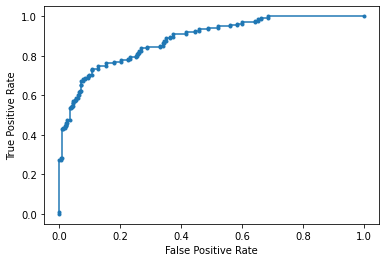

Accuracy: 85.06% Precision: 77.14% Recall: 60.00%
F1: 67.50% AUPRC: 78.92% AUROC: 88.43%
2023-02-14 14:04:50.887917
Fold 6
FIT
2023-02-14 14:05:02.344320
PREDICT
2023-02-14 14:05:09.069887


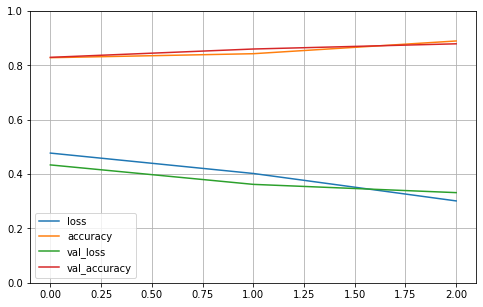

Train set ones/size 3921 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 433 / 522
Range of scores: 0.04903507 to 0.9986971
Score threshold 0.5
Prediction set ones/size 488 / 522


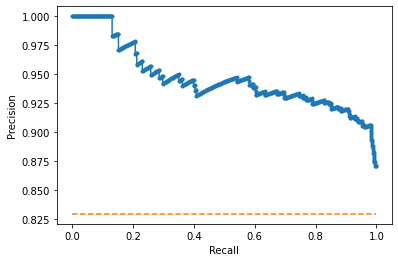

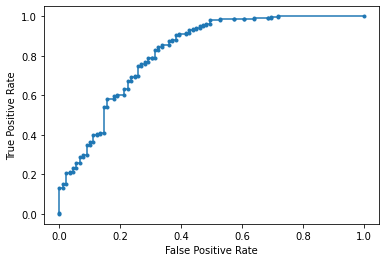

Accuracy: 87.93% Precision: 87.91% Recall: 99.08%
F1: 93.16% AUPRC: 94.60% AUROC: 81.97%
2023-02-14 14:05:09.810304
Fold 7
FIT
2023-02-14 14:05:19.060052
PREDICT
2023-02-14 14:05:30.888776


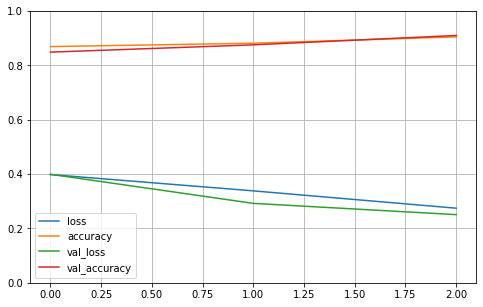

Train set ones/size 593 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 79 / 522
Range of scores: 0.00025125072 to 0.98784536
Score threshold 0.5
Prediction set ones/size 56 / 522


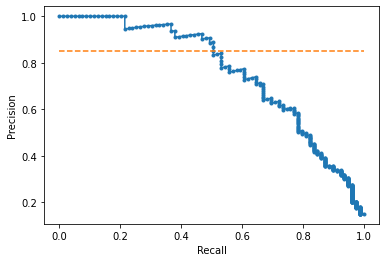

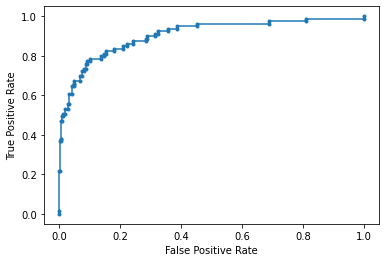

Accuracy: 91.00% Precision: 78.57% Recall: 55.70%
F1: 65.19% AUPRC: 75.92% AUROC: 90.54%
2023-02-14 14:05:31.577943
Fold 8
FIT
2023-02-14 14:05:42.330411
PREDICT
2023-02-14 14:05:53.735609


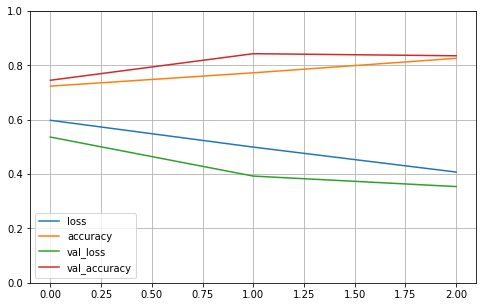

Train set ones/size 3456 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 389 / 522
Range of scores: 0.06597453 to 0.99765575
Score threshold 0.5
Prediction set ones/size 457 / 522


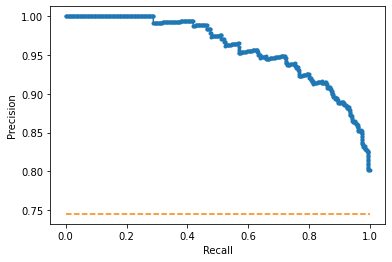

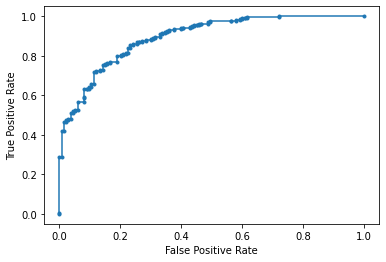

Accuracy: 83.52% Precision: 83.15% Recall: 97.69%
F1: 89.83% AUPRC: 95.93% AUROC: 89.44%
2023-02-14 14:05:54.427355
Fold 9
FIT
2023-02-14 14:06:05.621236
PREDICT
2023-02-14 14:06:11.727767


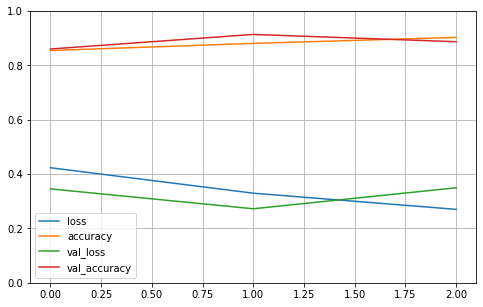

Train set ones/size 4030 / 4697
Compute valiation accuracy
Valid sizes (522, 4997) (522,)
Valid set ones/size 449 / 522
Range of scores: 0.16199684 to 0.9999093
Score threshold 0.5
Prediction set ones/size 506 / 522


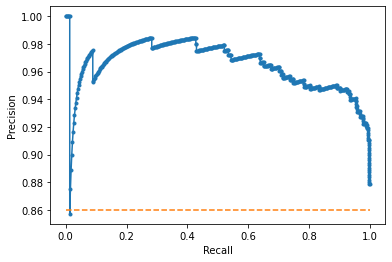

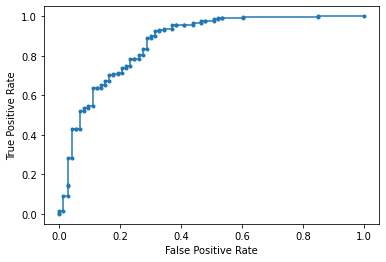

Accuracy: 88.70% Precision: 88.54% Recall: 99.78%
F1: 93.82% AUPRC: 96.43% AUROC: 86.74%
2023-02-14 14:06:12.571323
Fold 10
FIT
2023-02-14 14:06:23.133416
PREDICT
2023-02-14 14:06:34.564474


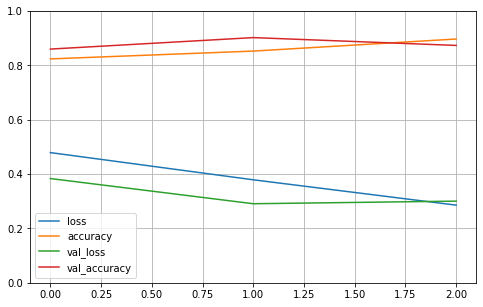

Train set ones/size 3909 / 4698
Compute valiation accuracy
Valid sizes (521, 4997) (521,)
Valid set ones/size 448 / 521
Range of scores: 0.008260325 to 0.9982672
Score threshold 0.5
Prediction set ones/size 436 / 521


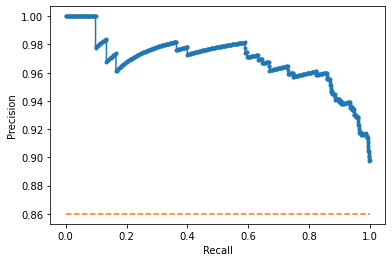

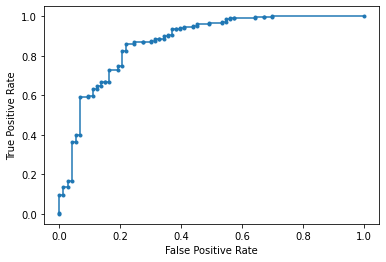

Accuracy: 87.33% Precision: 93.81% Recall: 91.29%
F1: 92.53% AUPRC: 96.89% AUROC: 87.07%
2023-02-14 14:06:35.303476

Completed cross validation 10 folds 3 epochs
 accuracy mean 85.04% +/- 3.83
 precision mean 79.98% +/- 10.59
 recall mean 78.28% +/- 21.15
 F1 mean 77.97% +/- 14.66
 AUPRC mean 85.75% +/- 10.76
 AUROC mean 86.94% +/- 2.78
Finished cell Line 7 NCI.H460

2023-02-14 14:06:36.676401
Start cell Line 8 NHEK
Number of RCI values loaded 1080
Num RCI: 1080
Load sequence...
Cross validation...
2023-02-14 14:06:50.121151
splitting
Fold 1
FIT
2023-02-14 14:07:01.029080
PREDICT
2023-02-14 14:07:12.606840


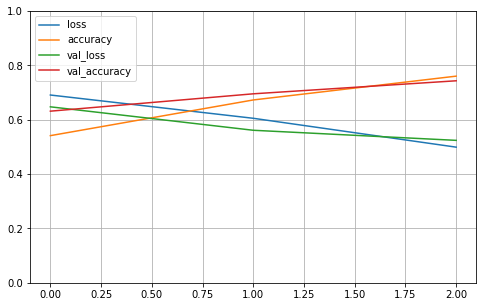

Train set ones/size 3479 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 368 / 814
Range of scores: 0.004806125 to 0.9987888
Score threshold 0.5
Prediction set ones/size 313 / 814


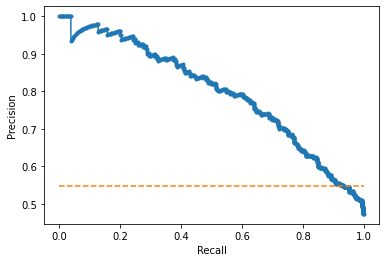

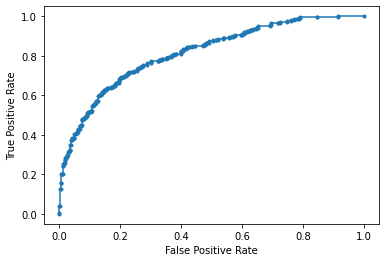

Accuracy: 74.32% Precision: 75.40% Recall: 64.13%
F1: 69.31% AUPRC: 79.79% AUROC: 81.51%
2023-02-14 14:07:13.494705
Fold 2
FIT
2023-02-14 14:07:24.094804
PREDICT
2023-02-14 14:07:35.645938


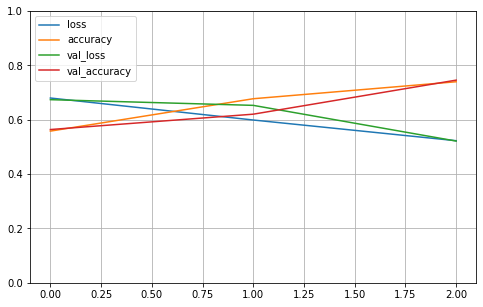

Train set ones/size 3538 / 7318
Compute valiation accuracy
Valid sizes (814, 4997) (814,)
Valid set ones/size 392 / 814
Range of scores: 0.013171261 to 0.989888
Score threshold 0.5
Prediction set ones/size 355 / 814


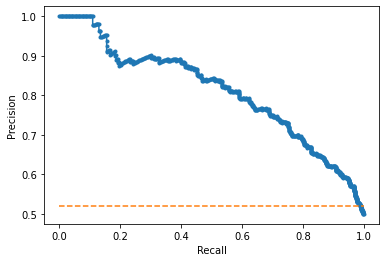

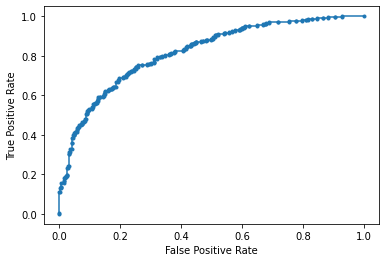

Accuracy: 74.57% Precision: 76.06% Recall: 68.88%
F1: 72.29% AUPRC: 81.07% AUROC: 81.84%
2023-02-14 14:07:36.373196
Fold 3
FIT
2023-02-14 14:07:48.794191
PREDICT
2023-02-14 14:07:57.276627


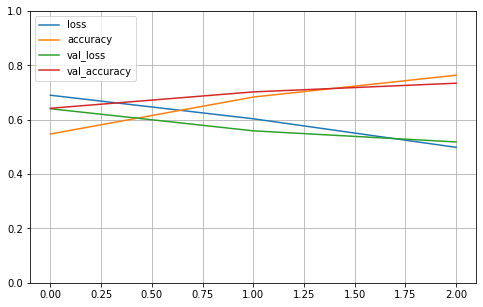

Train set ones/size 3498 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 393 / 813
Range of scores: 0.014132868 to 0.9973239
Score threshold 0.5
Prediction set ones/size 471 / 813


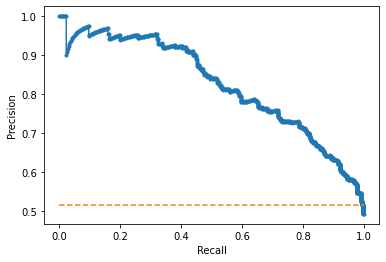

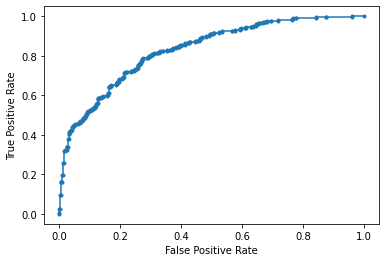

Accuracy: 73.43% Precision: 68.79% Recall: 82.44%
F1: 75.00% AUPRC: 82.56% AUROC: 83.06%
2023-02-14 14:07:58.016222
Fold 4
FIT
2023-02-14 14:08:08.772757
PREDICT
2023-02-14 14:08:20.329012


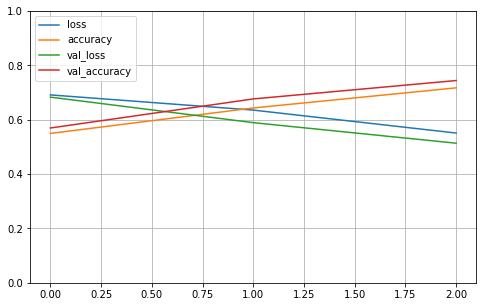

Train set ones/size 3392 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 378 / 813
Range of scores: 0.047877815 to 0.98723596
Score threshold 0.5
Prediction set ones/size 430 / 813


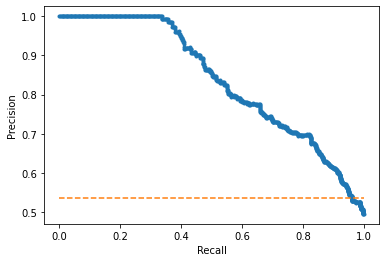

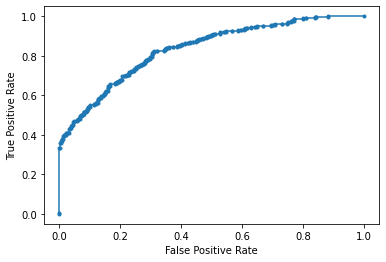

Accuracy: 74.42% Precision: 69.77% Recall: 79.37%
F1: 74.26% AUPRC: 83.91% AUROC: 83.46%
2023-02-14 14:08:21.233347
Fold 5
FIT
2023-02-14 14:08:33.621959
PREDICT
2023-02-14 14:08:42.454159


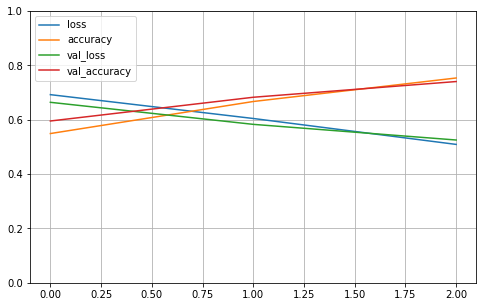

Train set ones/size 3938 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 426 / 813
Range of scores: 0.0070662037 to 0.9766675
Score threshold 0.5
Prediction set ones/size 379 / 813


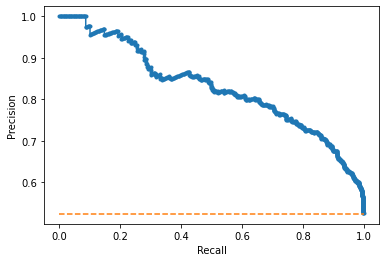

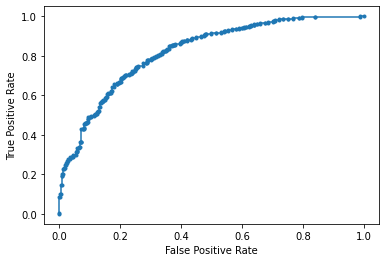

Accuracy: 74.05% Precision: 78.36% Recall: 69.72%
F1: 73.79% AUPRC: 82.94% AUROC: 82.15%
2023-02-14 14:08:43.187655
Fold 6
FIT
2023-02-14 14:08:53.985253
PREDICT
2023-02-14 14:09:02.506572


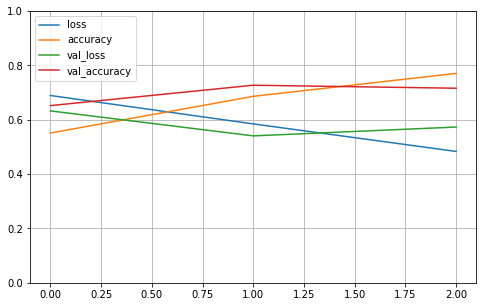

Train set ones/size 3832 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 433 / 813
Range of scores: 0.014302086 to 0.99777883
Score threshold 0.5
Prediction set ones/size 592 / 813


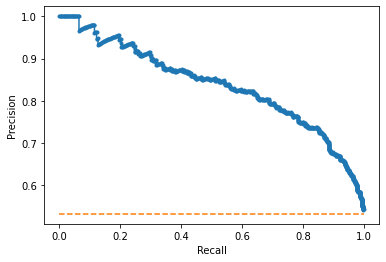

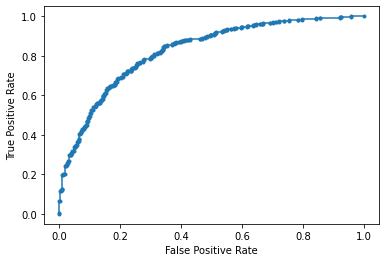

Accuracy: 71.59% Precision: 67.06% Recall: 91.69%
F1: 77.46% AUPRC: 83.75% AUROC: 82.54%
2023-02-14 14:09:03.227810
Fold 7
FIT
2023-02-14 14:09:15.784366
PREDICT
2023-02-14 14:09:27.356307


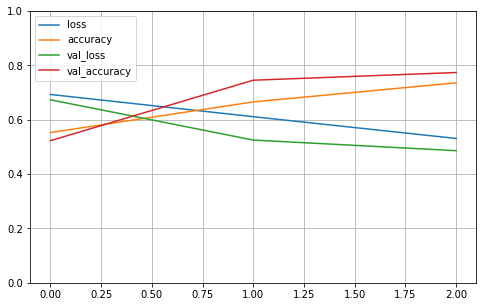

Train set ones/size 3414 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 356 / 813
Range of scores: 0.009027519 to 0.97404253
Score threshold 0.5
Prediction set ones/size 342 / 813


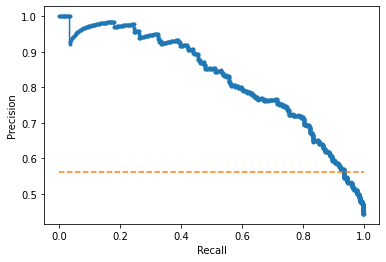

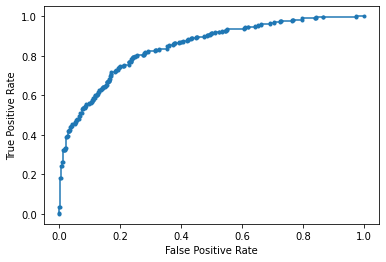

Accuracy: 77.37% Precision: 75.15% Recall: 72.19%
F1: 73.64% AUPRC: 82.52% AUROC: 84.61%
2023-02-14 14:09:28.117265
Fold 8
FIT
2023-02-14 14:09:40.337297
PREDICT
2023-02-14 14:09:51.891977


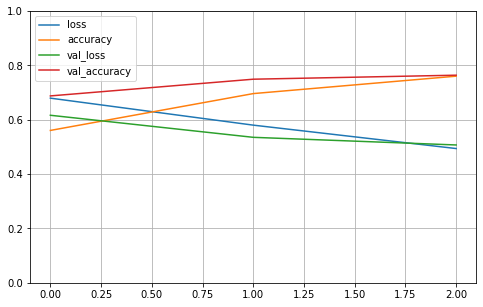

Train set ones/size 3383 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 387 / 813
Range of scores: 0.0067220656 to 0.99743253
Score threshold 0.5
Prediction set ones/size 331 / 813


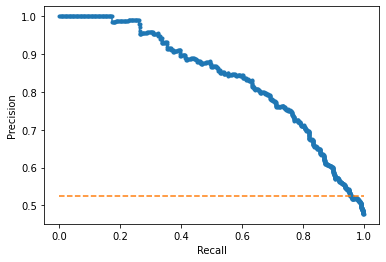

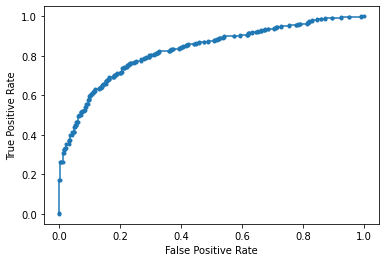

Accuracy: 76.38% Precision: 79.46% Recall: 67.96%
F1: 73.26% AUPRC: 83.82% AUROC: 82.84%
2023-02-14 14:09:52.814537
Fold 9
FIT
2023-02-14 14:10:05.571064
PREDICT
2023-02-14 14:10:14.344353


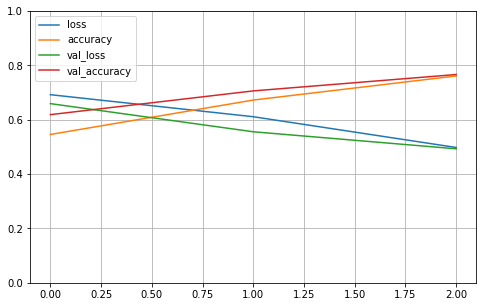

Train set ones/size 3853 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 427 / 813
Range of scores: 0.007012453 to 0.9841271
Score threshold 0.5
Prediction set ones/size 471 / 813


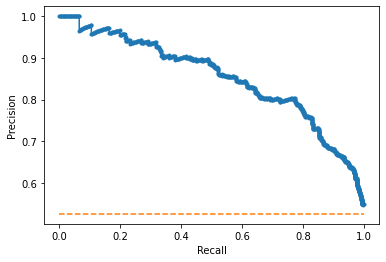

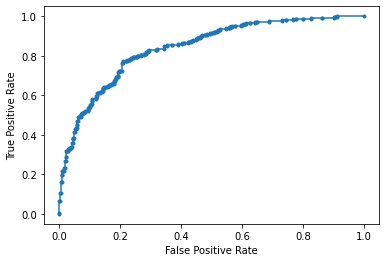

Accuracy: 76.63% Precision: 75.16% Recall: 82.90%
F1: 78.84% AUPRC: 85.31% AUROC: 84.18%
2023-02-14 14:10:15.342623
Fold 10
FIT
2023-02-14 14:10:28.131879
PREDICT
2023-02-14 14:10:39.810794


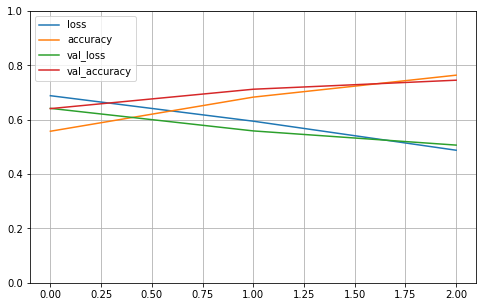

Train set ones/size 4076 / 7319
Compute valiation accuracy
Valid sizes (813, 4997) (813,)
Valid set ones/size 430 / 813
Range of scores: 0.0066188057 to 0.99321437
Score threshold 0.5
Prediction set ones/size 365 / 813


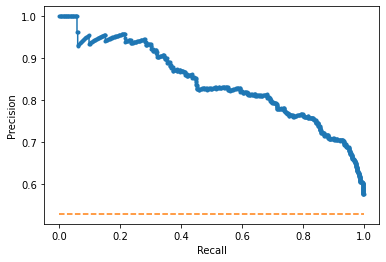

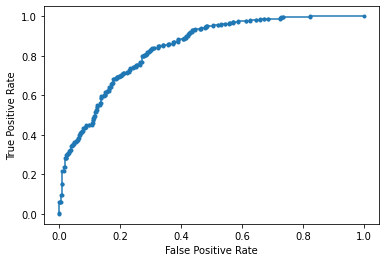

Accuracy: 74.54% Precision: 80.55% Recall: 68.37%
F1: 73.96% AUPRC: 84.25% AUROC: 84.09%
2023-02-14 14:10:40.999356

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.73% +/- 1.69
 precision mean 74.57% +/- 4.60
 recall mean 74.76% +/- 8.82
 F1 mean 74.18% +/- 2.62
 AUPRC mean 82.99% +/- 1.61
 AUROC mean 83.03% +/- 1.05
Finished cell Line 8 NHEK

2023-02-14 14:10:42.588963
Start cell Line 9 SK.MEL.5
Number of RCI values loaded 534
Num RCI: 534
Load sequence...
Cross validation...
2023-02-14 14:10:49.681643
splitting
Fold 1
FIT
2023-02-14 14:10:59.476380
PREDICT
2023-02-14 14:11:05.771296


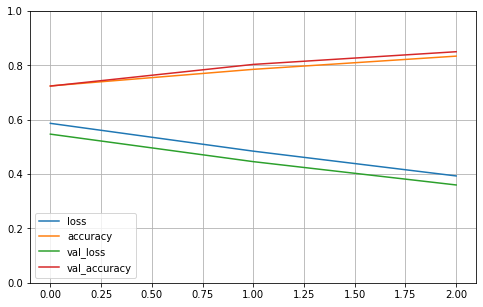

Train set ones/size 3377 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 372 / 514
Range of scores: 0.024002975 to 0.9991141
Score threshold 0.5
Prediction set ones/size 411 / 514


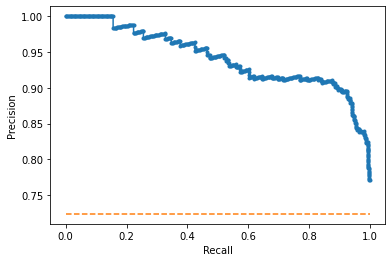

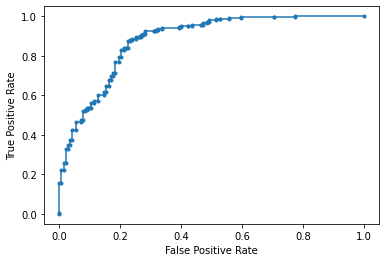

Accuracy: 85.02% Precision: 85.89% Recall: 94.89%
F1: 90.17% AUPRC: 94.18% AUROC: 87.97%
2023-02-14 14:11:06.735587
Fold 2
FIT
2023-02-14 14:11:16.568321
PREDICT
2023-02-14 14:11:27.950805


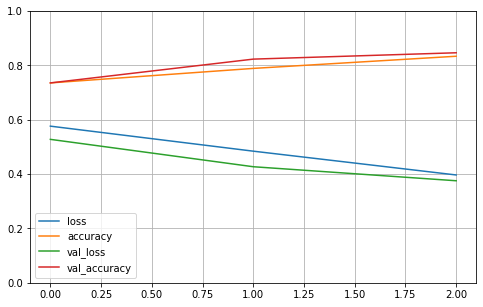

Train set ones/size 1201 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 142 / 514
Range of scores: 0.00094537856 to 0.9699858
Score threshold 0.5
Prediction set ones/size 85 / 514


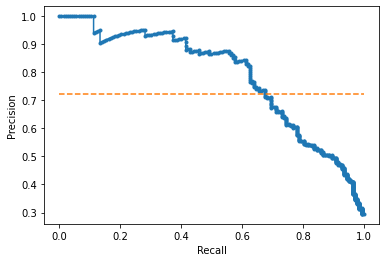

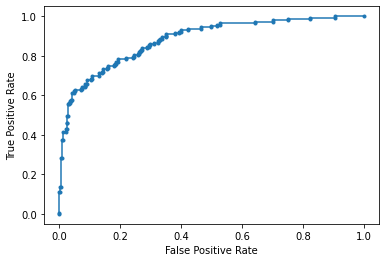

Accuracy: 84.63% Precision: 87.06% Recall: 52.11%
F1: 65.20% AUPRC: 78.72% AUROC: 88.17%
2023-02-14 14:11:28.713726
Fold 3
FIT
2023-02-14 14:11:39.953415
PREDICT
2023-02-14 14:11:46.234875


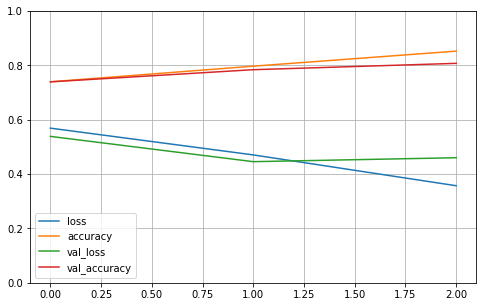

Train set ones/size 1180 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 134 / 514
Range of scores: 0.00028540392 to 0.94470304
Score threshold 0.5
Prediction set ones/size 39 / 514


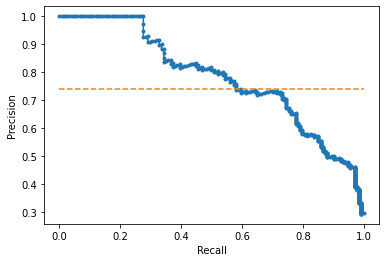

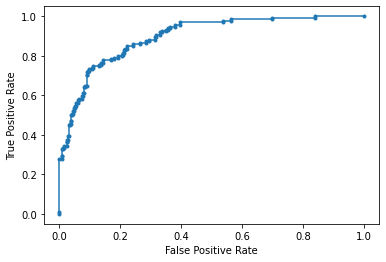

Accuracy: 80.74% Precision: 94.87% Recall: 27.61%
F1: 42.77% AUPRC: 78.32% AUROC: 89.70%
2023-02-14 14:11:47.155985
Fold 4
FIT
2023-02-14 14:11:57.724947
PREDICT
2023-02-14 14:12:09.495249


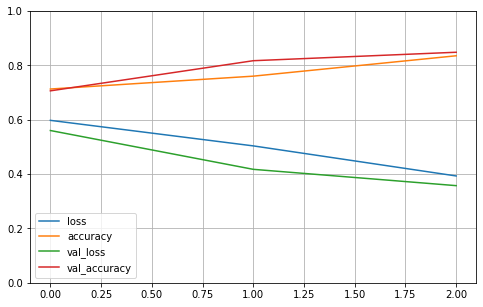

Train set ones/size 1278 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 151 / 514
Range of scores: 0.00023201578 to 0.99151516
Score threshold 0.5
Prediction set ones/size 105 / 514


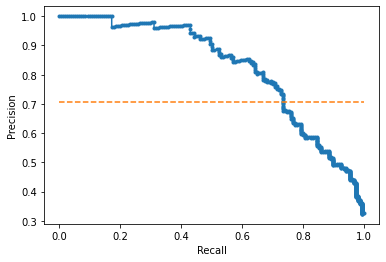

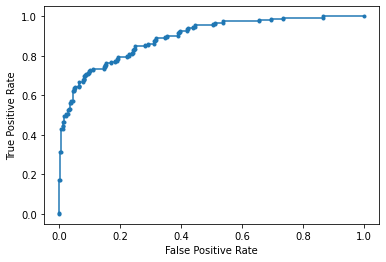

Accuracy: 84.82% Precision: 84.76% Recall: 58.94%
F1: 69.53% AUPRC: 82.36% AUROC: 89.33%
2023-02-14 14:12:10.174224
Fold 5
FIT
2023-02-14 14:12:21.988603
PREDICT
2023-02-14 14:12:28.645215


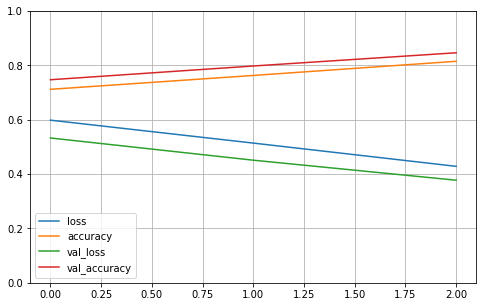

Train set ones/size 1282 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 130 / 514
Range of scores: 0.001542858 to 0.95932466
Score threshold 0.5
Prediction set ones/size 69 / 514


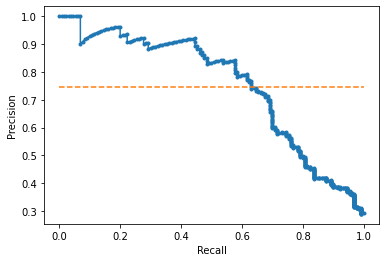

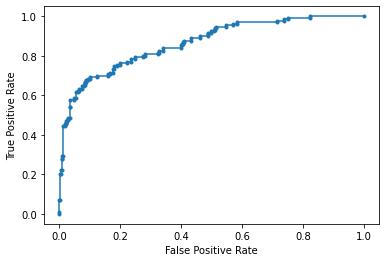

Accuracy: 84.63% Precision: 86.96% Recall: 46.15%
F1: 60.30% AUPRC: 75.34% AUROC: 86.56%
2023-02-14 14:12:29.372740
Fold 6
FIT
2023-02-14 14:12:40.843263
PREDICT
2023-02-14 14:12:47.217333


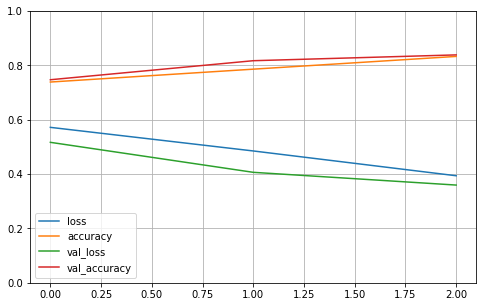

Train set ones/size 1186 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 128 / 514
Range of scores: 0.0015571067 to 0.98498607
Score threshold 0.5
Prediction set ones/size 119 / 514


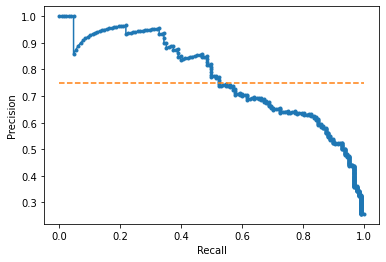

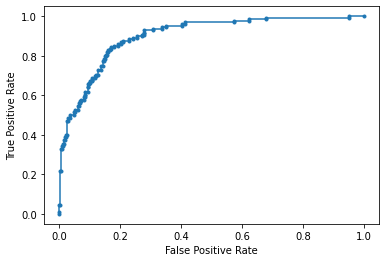

Accuracy: 83.85% Precision: 68.91% Recall: 64.06%
F1: 66.40% AUPRC: 76.94% AUROC: 90.10%
2023-02-14 14:12:47.956353
Fold 7
FIT
2023-02-14 14:12:59.917445
PREDICT
2023-02-14 14:13:06.188795


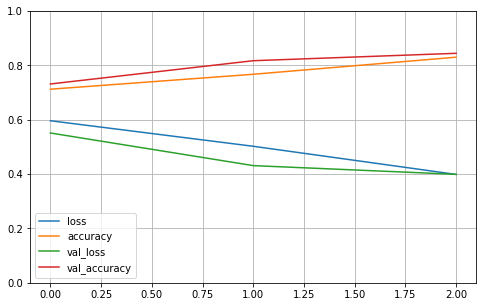

Train set ones/size 1302 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 138 / 514
Range of scores: 0.007109449 to 0.9742666
Score threshold 0.5
Prediction set ones/size 124 / 514


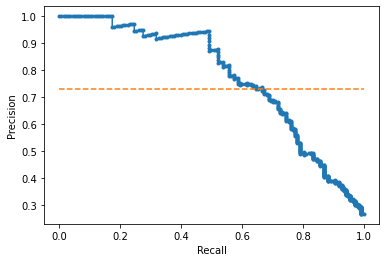

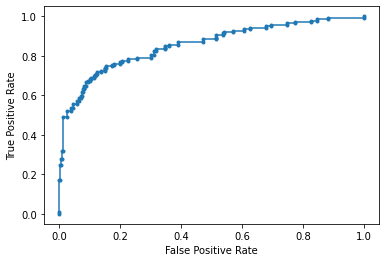

Accuracy: 84.44% Precision: 73.39% Recall: 65.94%
F1: 69.47% AUPRC: 77.39% AUROC: 85.57%
2023-02-14 14:13:07.164491
Fold 8
FIT
2023-02-14 14:13:16.616146
PREDICT
2023-02-14 14:13:23.297816


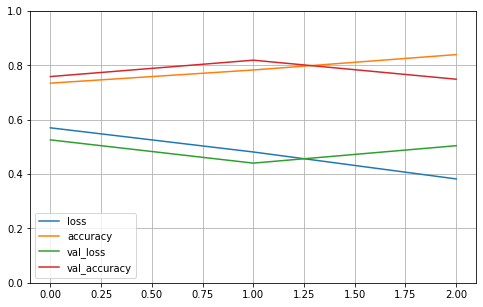

Train set ones/size 3436 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 390 / 514
Range of scores: 0.0029272023 to 0.99588984
Score threshold 0.5
Prediction set ones/size 321 / 514


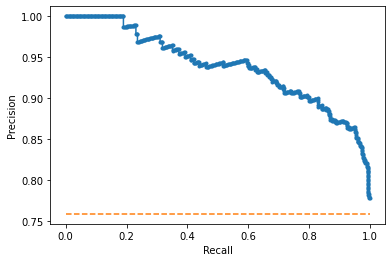

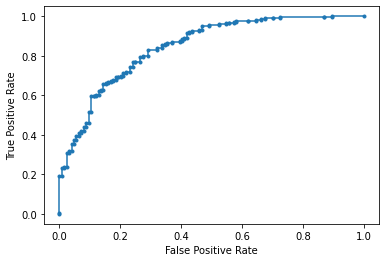

Accuracy: 74.90% Precision: 90.65% Recall: 74.62%
F1: 81.86% AUPRC: 93.95% AUROC: 84.63%
2023-02-14 14:13:24.015996
Fold 9
FIT
2023-02-14 14:13:35.330248
PREDICT
2023-02-14 14:13:41.604717


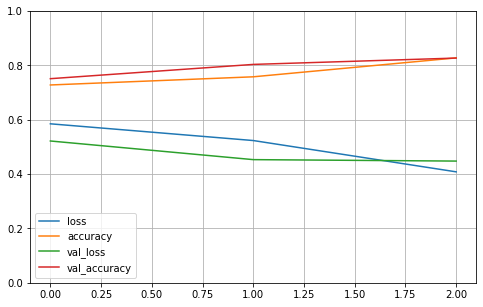

Train set ones/size 1215 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 129 / 514
Range of scores: 7.6202334e-05 to 0.897695
Score threshold 0.5
Prediction set ones/size 46 / 514


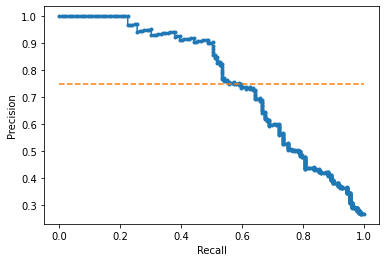

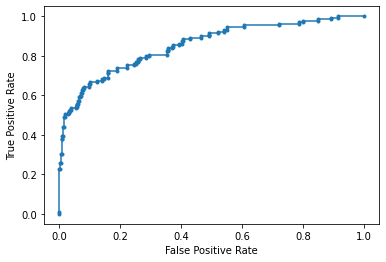

Accuracy: 82.68% Precision: 93.48% Recall: 33.33%
F1: 49.14% AUPRC: 75.71% AUROC: 85.39%
2023-02-14 14:13:42.279172
Fold 10
FIT
2023-02-14 14:13:52.768327
PREDICT
2023-02-14 14:13:58.980689


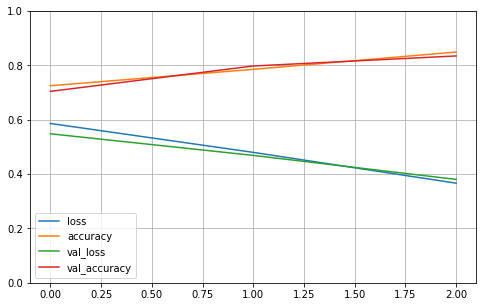

Train set ones/size 1244 / 4626
Compute valiation accuracy
Valid sizes (514, 4997) (514,)
Valid set ones/size 153 / 514
Range of scores: 0.0008700436 to 0.9807012
Score threshold 0.5
Prediction set ones/size 120 / 514


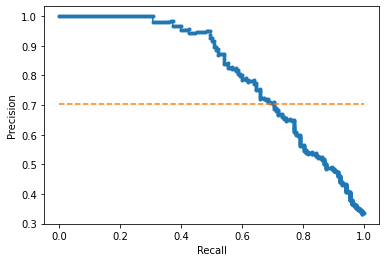

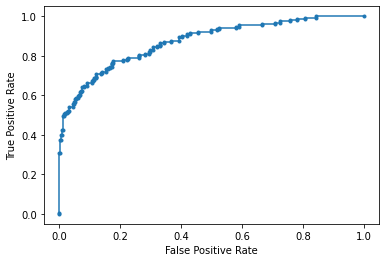

Accuracy: 83.46% Precision: 78.33% Recall: 61.44%
F1: 68.86% AUPRC: 80.97% AUROC: 87.23%
2023-02-14 14:13:59.968175

Completed cross validation 10 folds 3 epochs
 accuracy mean 82.92% +/- 3.10
 precision mean 84.43% +/- 8.47
 recall mean 57.91% +/- 19.60
 F1 mean 66.37% +/- 13.84
 AUPRC mean 81.39% +/- 7.02
 AUROC mean 87.47% +/- 1.91
Finished cell Line 9 SK.MEL.5

2023-02-14 14:14:01.437828
Start cell Line 10 SK.N.DZ
Number of RCI values loaded 603
Num RCI: 603
Load sequence...
Cross validation...
2023-02-14 14:14:09.327328
splitting
Fold 1
FIT
2023-02-14 14:14:18.180046
PREDICT
2023-02-14 14:14:29.619453


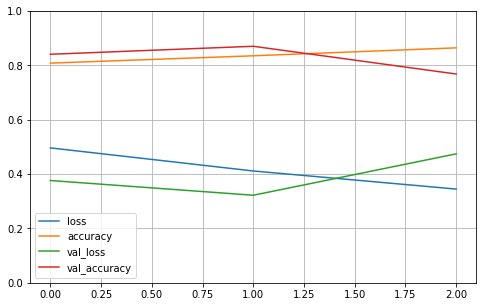

Train set ones/size 4219 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 486 / 578
Range of scores: 0.0067538726 to 0.9932568
Score threshold 0.5
Prediction set ones/size 386 / 578


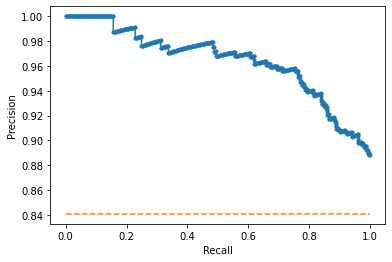

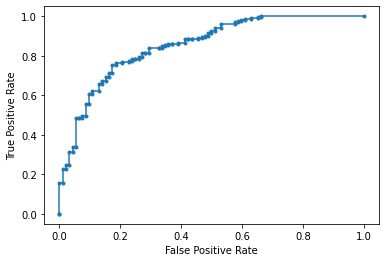

Accuracy: 76.82% Precision: 95.60% Recall: 75.93%
F1: 84.63% AUPRC: 96.41% AUROC: 85.34%
2023-02-14 14:14:30.350315
Fold 2
FIT
2023-02-14 14:14:40.995460
PREDICT
2023-02-14 14:14:47.491928


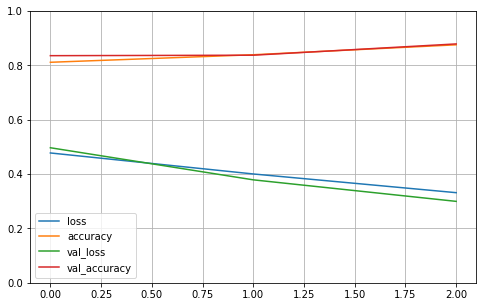

Train set ones/size 4242 / 5194
Compute valiation accuracy
Valid sizes (578, 4997) (578,)
Valid set ones/size 469 / 578
Range of scores: 0.017168628 to 0.9988632
Score threshold 0.5
Prediction set ones/size 495 / 578


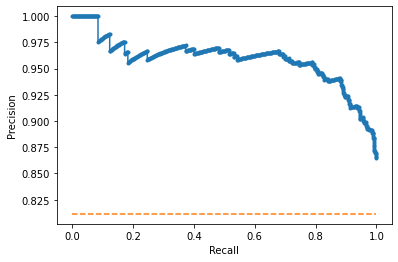

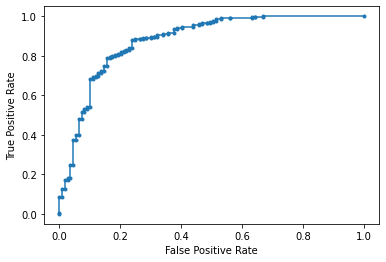

Accuracy: 87.89% Precision: 90.30% Recall: 95.31%
F1: 92.74% AUPRC: 95.91% AUROC: 87.96%
2023-02-14 14:14:48.170472
Fold 3
FIT
2023-02-14 14:14:58.322977
PREDICT
2023-02-14 14:15:09.752167


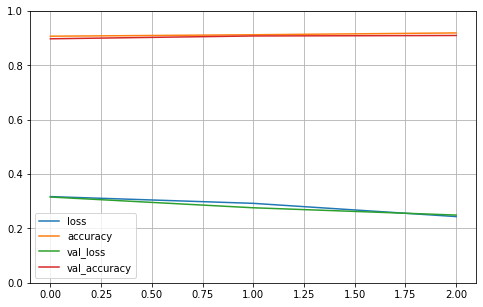

Train set ones/size 4739 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 519 / 577
Range of scores: 0.02598259 to 0.99844605
Score threshold 0.5
Prediction set ones/size 565 / 577


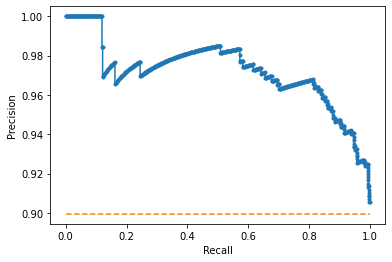

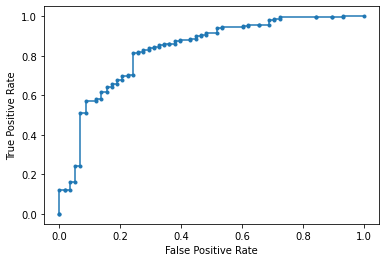

Accuracy: 90.99% Precision: 91.33% Recall: 99.42%
F1: 95.20% AUPRC: 97.19% AUROC: 83.01%
2023-02-14 14:15:10.490225
Fold 4
FIT
2023-02-14 14:15:21.906194
PREDICT
2023-02-14 14:15:33.337609


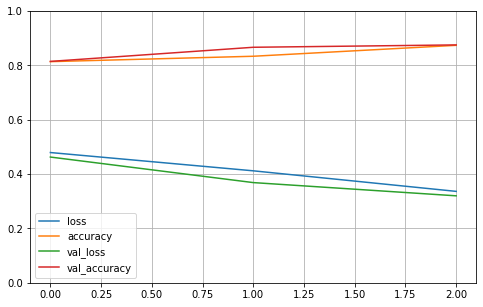

Train set ones/size 959 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 107 / 577
Range of scores: 0.0016427828 to 0.9825037
Score threshold 0.5
Prediction set ones/size 55 / 577


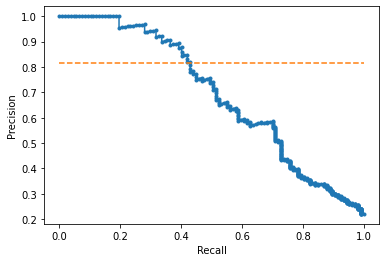

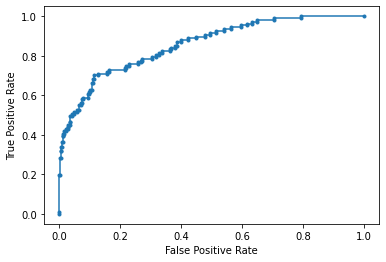

Accuracy: 87.52% Precision: 81.82% Recall: 42.06%
F1: 55.56% AUPRC: 69.24% AUROC: 85.75%
2023-02-14 14:15:34.126032
Fold 5
FIT
2023-02-14 14:15:45.520465
PREDICT
2023-02-14 14:15:56.980740


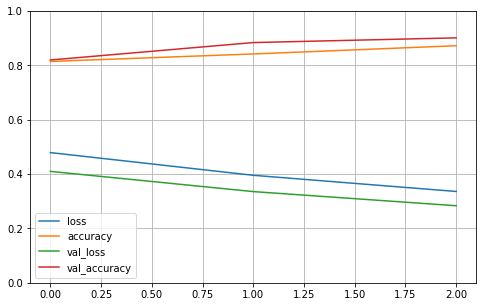

Train set ones/size 953 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 103 / 577
Range of scores: 0.00032910408 to 0.98376125
Score threshold 0.5
Prediction set ones/size 62 / 577


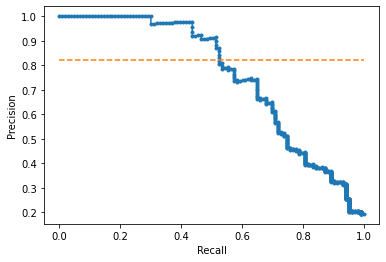

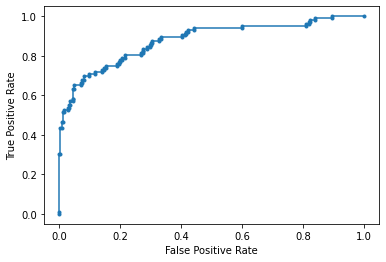

Accuracy: 90.12% Precision: 87.10% Recall: 52.43%
F1: 65.45% AUPRC: 75.49% AUROC: 87.87%
2023-02-14 14:15:57.848431
Fold 6
FIT
2023-02-14 14:16:08.331827
PREDICT
2023-02-14 14:16:15.630803


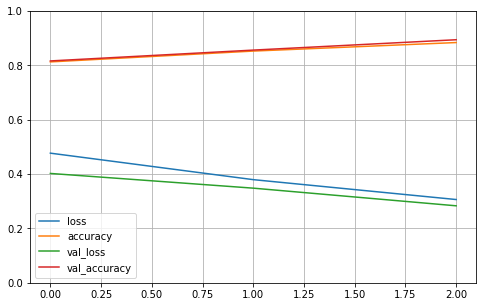

Train set ones/size 961 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 109 / 577
Range of scores: 0.0008970154 to 0.991935
Score threshold 0.5
Prediction set ones/size 62 / 577


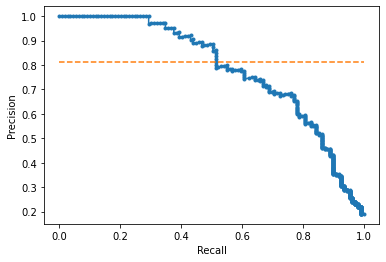

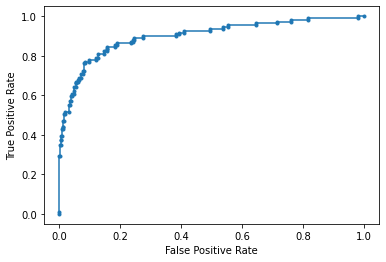

Accuracy: 89.43% Precision: 88.71% Recall: 50.46%
F1: 64.33% AUPRC: 78.36% AUROC: 89.99%
2023-02-14 14:16:16.369156
Fold 7
FIT
2023-02-14 14:16:27.032708
PREDICT
2023-02-14 14:16:38.478374


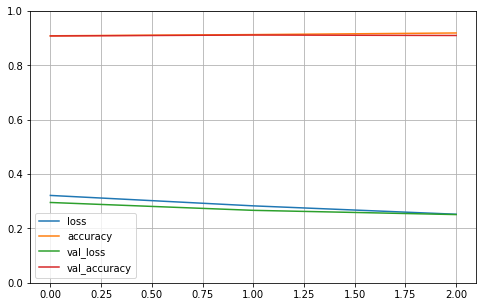

Train set ones/size 4734 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 524 / 577
Range of scores: 0.16689199 to 0.99894947
Score threshold 0.5
Prediction set ones/size 574 / 577


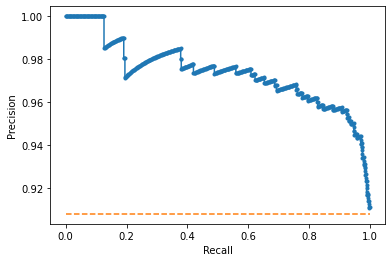

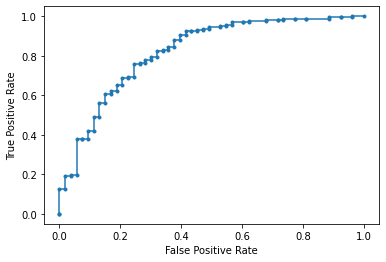

Accuracy: 90.99% Precision: 91.11% Recall: 99.81%
F1: 95.26% AUPRC: 97.38% AUROC: 82.16%
2023-02-14 14:16:39.210296
Fold 8
FIT
2023-02-14 14:16:49.596614
PREDICT
2023-02-14 14:16:56.165553


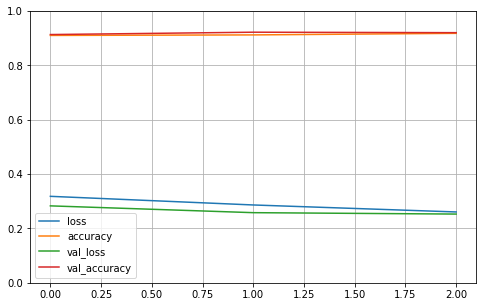

Train set ones/size 459 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 50 / 577
Range of scores: 0.0013264763 to 0.89275193
Score threshold 0.5
Prediction set ones/size 6 / 577


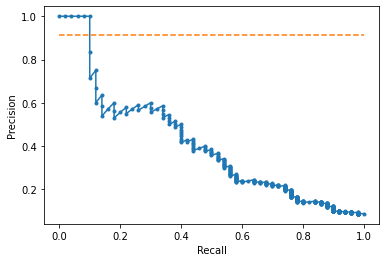

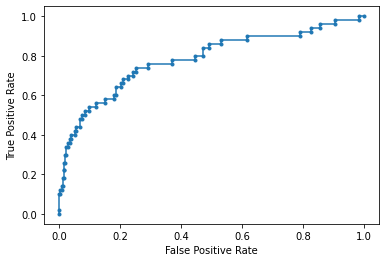

Accuracy: 92.03% Precision: 83.33% Recall: 10.00%
F1: 17.86% AUPRC: 40.71% AUROC: 78.41%
2023-02-14 14:16:56.867116
Fold 9
FIT
2023-02-14 14:17:07.116585
PREDICT
2023-02-14 14:17:13.732464


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


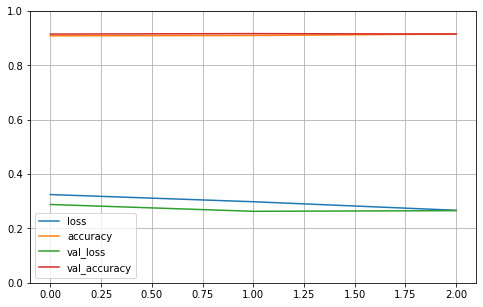

Train set ones/size 467 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 49 / 577
Range of scores: 0.001350385 to 0.49937516
Score threshold 0.5
Prediction set ones/size 0 / 577


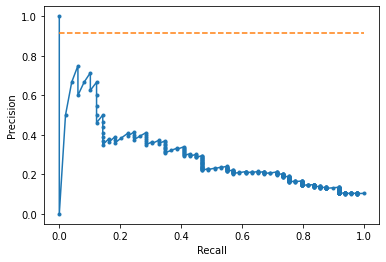

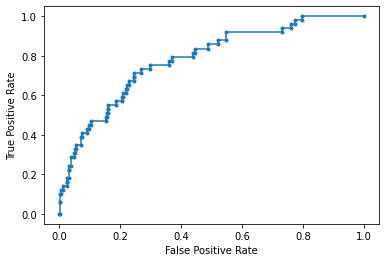

Accuracy: 91.51% Precision: 0.00% Recall: 0.00%
F1: 0.00% AUPRC: 29.01% AUROC: 78.25%
2023-02-14 14:17:14.876916
Fold 10
FIT
2023-02-14 14:17:24.254580
PREDICT
2023-02-14 14:17:35.692786


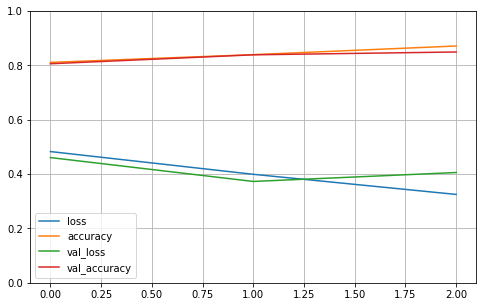

Train set ones/size 4237 / 5195
Compute valiation accuracy
Valid sizes (577, 4997) (577,)
Valid set ones/size 465 / 577
Range of scores: 0.03812383 to 0.9996933
Score threshold 0.5
Prediction set ones/size 550 / 577


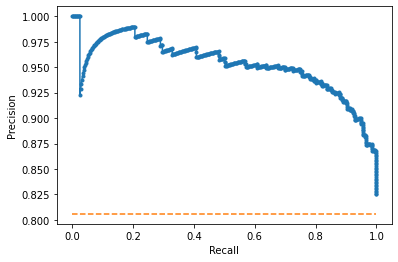

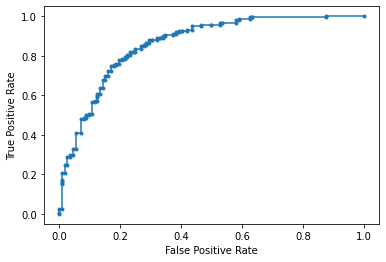

Accuracy: 84.92% Precision: 84.36% Recall: 99.78%
F1: 91.43% AUPRC: 95.30% AUROC: 86.30%
2023-02-14 14:17:36.444090

Completed cross validation 10 folds 3 epochs
 accuracy mean 88.22% +/- 4.56
 precision mean 79.37% +/- 28.20
 recall mean 62.52% +/- 37.61
 F1 mean 66.25% +/- 33.67
 AUPRC mean 77.50% +/- 24.89
 AUROC mean 84.50% +/- 3.99
Finished cell Line 10 SK.N.DZ

2023-02-14 14:17:37.848162
Start cell Line 11 SK.N.SH
Number of RCI values loaded 1647
Num RCI: 1647
Load sequence...
Cross validation...
2023-02-14 14:17:54.360682
splitting
Fold 1
FIT
2023-02-14 14:18:05.324834
PREDICT
2023-02-14 14:18:16.389290


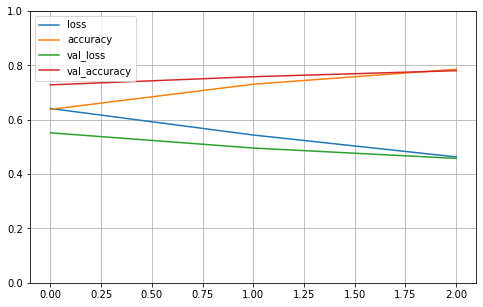

Train set ones/size 5733 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 651 / 1034
Range of scores: 0.0060087168 to 0.9884077
Score threshold 0.5
Prediction set ones/size 674 / 1034


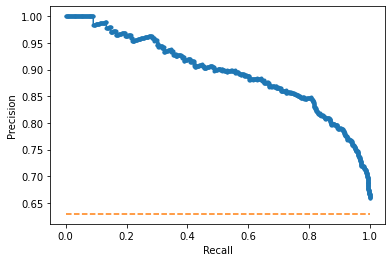

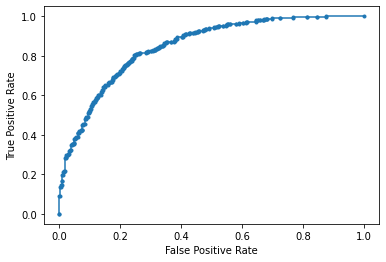

Accuracy: 78.05% Precision: 81.45% Recall: 84.33%
F1: 82.87% AUPRC: 89.59% AUROC: 84.79%
2023-02-14 14:18:17.211346
Fold 2
FIT
2023-02-14 14:18:28.899739
PREDICT
2023-02-14 14:18:39.750355


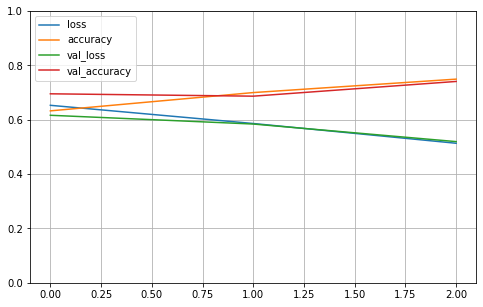

Train set ones/size 5743 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 635 / 1034
Range of scores: 0.019736098 to 0.99299
Score threshold 0.5
Prediction set ones/size 829 / 1034


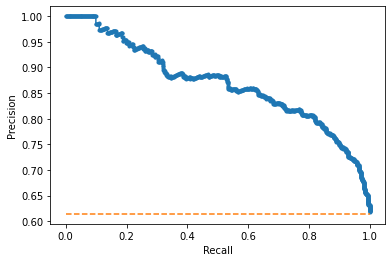

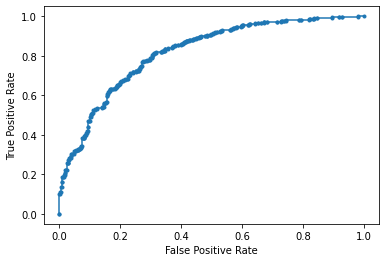

Accuracy: 74.08% Precision: 72.14% Recall: 94.17%
F1: 81.69% AUPRC: 86.90% AUROC: 81.80%
2023-02-14 14:18:40.728300
Fold 3
FIT
2023-02-14 14:18:52.338978
PREDICT
2023-02-14 14:19:04.024776


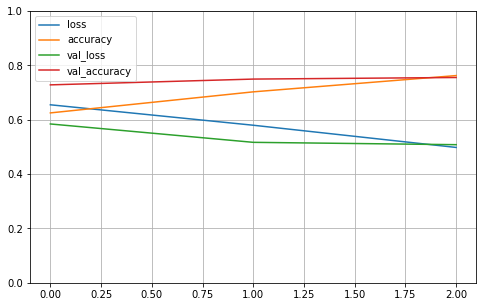

Train set ones/size 3718 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 386 / 1034
Range of scores: 0.0008888079 to 0.985159
Score threshold 0.5
Prediction set ones/size 251 / 1034


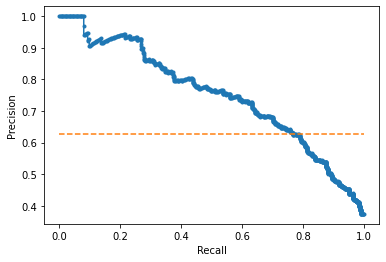

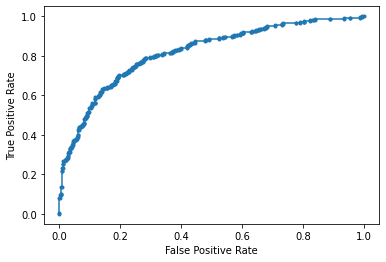

Accuracy: 75.53% Precision: 76.49% Recall: 49.74%
F1: 60.28% AUPRC: 75.16% AUROC: 81.72%
2023-02-14 14:19:04.978384
Fold 4
FIT
2023-02-14 14:19:14.959999
PREDICT
2023-02-14 14:19:25.904335


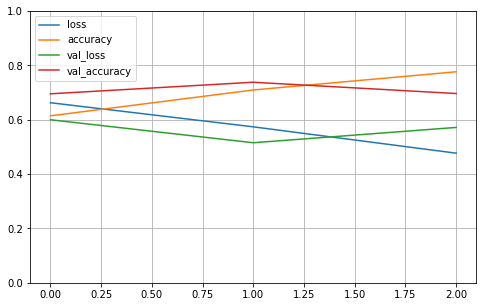

Train set ones/size 5569 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 622 / 1034
Range of scores: 0.0013539701 to 0.99481416
Score threshold 0.5
Prediction set ones/size 390 / 1034


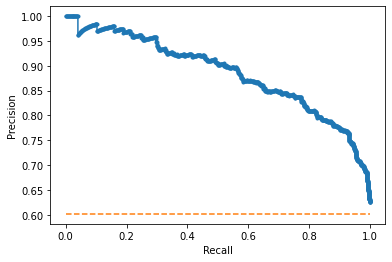

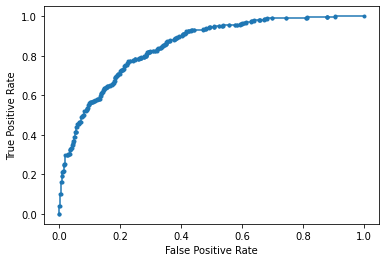

Accuracy: 69.63% Precision: 89.49% Recall: 56.11%
F1: 68.97% AUPRC: 88.64% AUROC: 84.92%
2023-02-14 14:19:26.867716
Fold 5
FIT
2023-02-14 14:19:37.759250
PREDICT
2023-02-14 14:19:48.616004


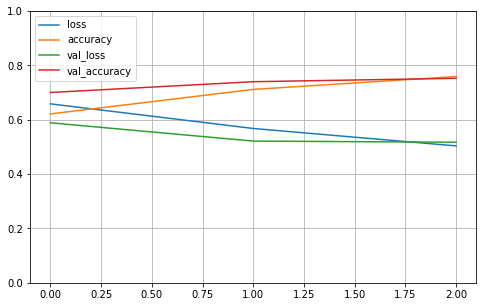

Train set ones/size 5576 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 637 / 1034
Range of scores: 0.018048704 to 0.99560505
Score threshold 0.5
Prediction set ones/size 825 / 1034


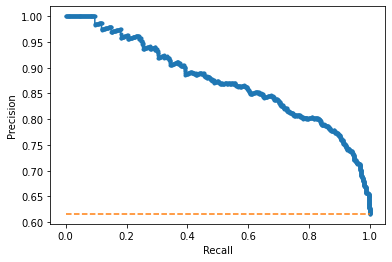

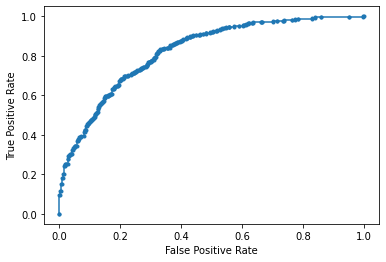

Accuracy: 75.24% Precision: 73.09% Recall: 94.66%
F1: 82.49% AUPRC: 87.47% AUROC: 82.33%
2023-02-14 14:19:49.414998
Fold 6
FIT
2023-02-14 14:20:02.416685
PREDICT
2023-02-14 14:20:14.125620


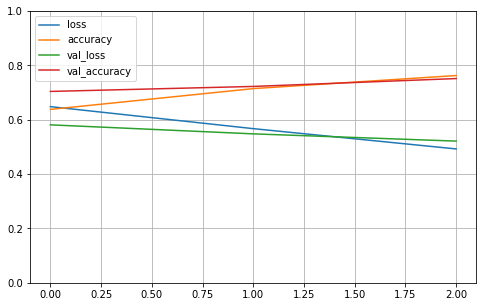

Train set ones/size 5738 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 644 / 1034
Range of scores: 0.005412205 to 0.9974849
Score threshold 0.5
Prediction set ones/size 823 / 1034


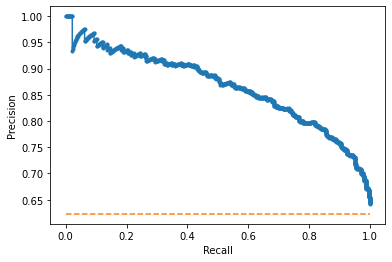

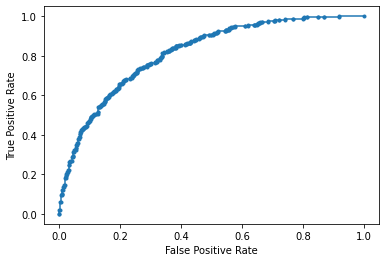

Accuracy: 75.15% Precision: 73.51% Recall: 93.94%
F1: 82.48% AUPRC: 86.57% AUROC: 81.50%
2023-02-14 14:20:14.956321
Fold 7
FIT
2023-02-14 14:20:29.618589
PREDICT
2023-02-14 14:20:41.346667


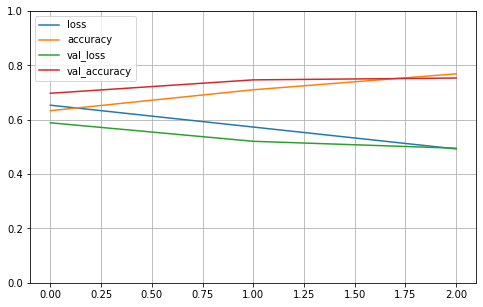

Train set ones/size 3497 / 9303
Compute valiation accuracy
Valid sizes (1034, 4997) (1034,)
Valid set ones/size 391 / 1034
Range of scores: 0.0020897633 to 0.99784625
Score threshold 0.5
Prediction set ones/size 384 / 1034


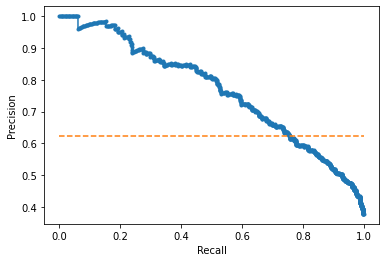

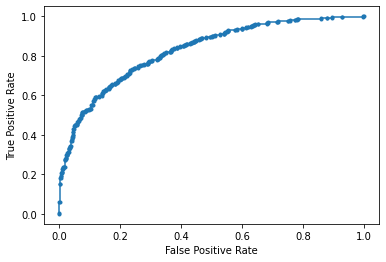

Accuracy: 75.34% Precision: 67.71% Recall: 66.50%
F1: 67.10% AUPRC: 76.72% AUROC: 82.68%
2023-02-14 14:20:42.314487
Fold 8
FIT
2023-02-14 14:20:56.111891
PREDICT
2023-02-14 14:21:07.786497


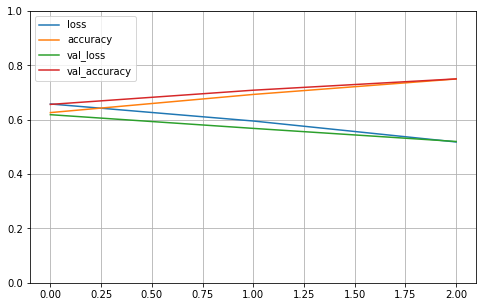

Train set ones/size 5768 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 616 / 1033
Range of scores: 0.014273787 to 0.9907953
Score threshold 0.5
Prediction set ones/size 712 / 1033


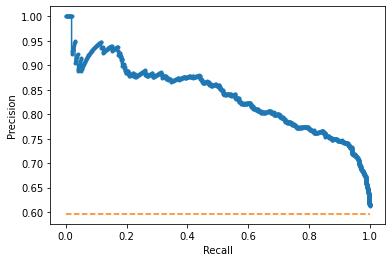

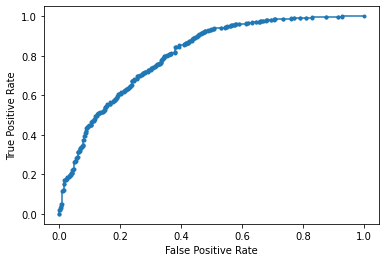

Accuracy: 75.02% Precision: 75.14% Recall: 86.85%
F1: 80.57% AUPRC: 83.75% AUROC: 80.56%
2023-02-14 14:21:08.808244
Fold 9
FIT
2023-02-14 14:21:23.906837
PREDICT
2023-02-14 14:21:34.821171


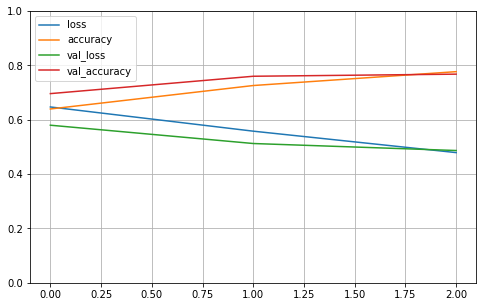

Train set ones/size 3514 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 391 / 1033
Range of scores: 0.01039284 to 0.9953129
Score threshold 0.5
Prediction set ones/size 417 / 1033


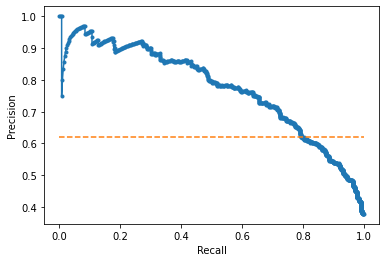

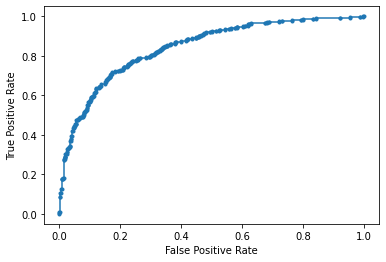

Accuracy: 76.77% Precision: 68.11% Recall: 72.63%
F1: 70.30% AUPRC: 77.34% AUROC: 84.25%
2023-02-14 14:21:35.839786
Fold 10
FIT
2023-02-14 14:21:47.601840
PREDICT
2023-02-14 14:21:59.277968


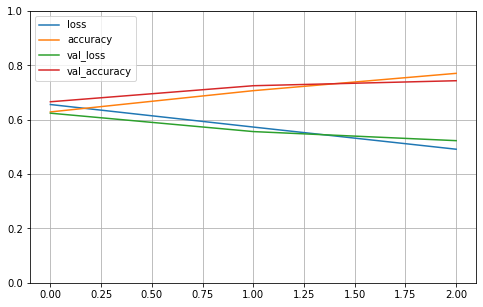

Train set ones/size 5758 / 9304
Compute valiation accuracy
Valid sizes (1033, 4997) (1033,)
Valid set ones/size 611 / 1033
Range of scores: 0.003623527 to 0.9875959
Score threshold 0.5
Prediction set ones/size 606 / 1033


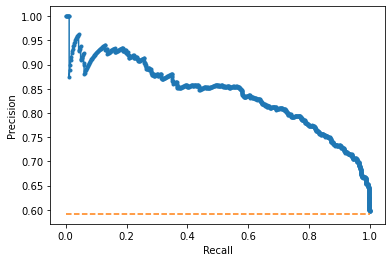

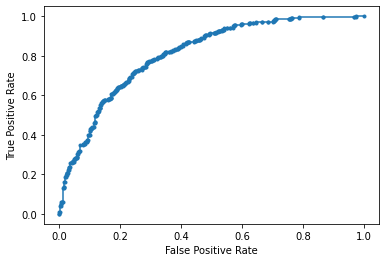

Accuracy: 74.35% Precision: 78.55% Recall: 77.91%
F1: 78.23% AUPRC: 83.96% AUROC: 81.02%
2023-02-14 14:22:00.139830

Completed cross validation 10 folds 3 epochs
 accuracy mean 74.92% +/- 2.18
 precision mean 75.57% +/- 6.48
 recall mean 77.68% +/- 16.16
 F1 mean 75.50% +/- 8.13
 AUPRC mean 83.61% +/- 5.31
 AUROC mean 82.56% +/- 1.57
Finished cell Line 11 SK.N.SH

2023-02-14 14:22:01.623735
Start cell Line 12 GM12878
Number of RCI values loaded 1698
Num RCI: 1698
Load sequence...
Cross validation...
2023-02-14 14:22:16.983810
splitting
Fold 1
FIT
2023-02-14 14:22:28.465721
PREDICT
2023-02-14 14:22:38.837256


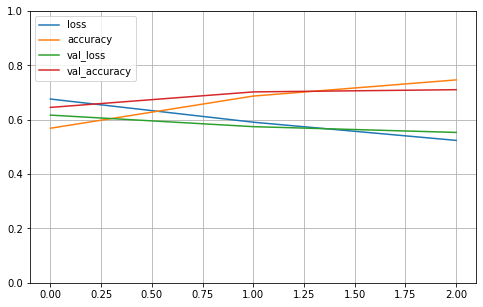

Train set ones/size 4027 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 433 / 981
Range of scores: 0.00926101 to 0.9925558
Score threshold 0.5
Prediction set ones/size 559 / 981


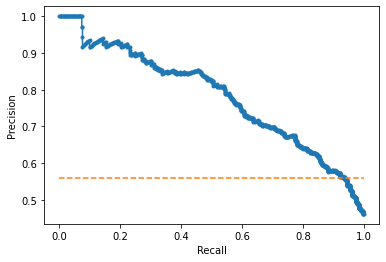

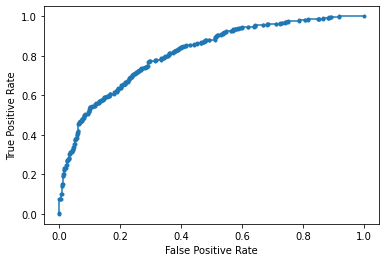

Accuracy: 71.05% Precision: 63.33% Recall: 81.76%
F1: 71.37% AUPRC: 78.22% AUROC: 81.39%
2023-02-14 14:22:39.814997
Fold 2
FIT
2023-02-14 14:22:50.601911
PREDICT
2023-02-14 14:23:00.538499


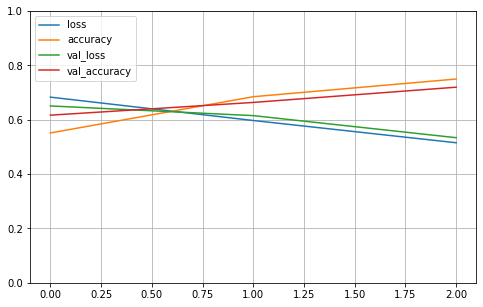

Train set ones/size 4083 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 461 / 981
Range of scores: 0.0027617074 to 0.99633265
Score threshold 0.5
Prediction set ones/size 550 / 981


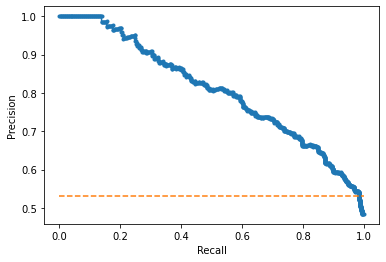

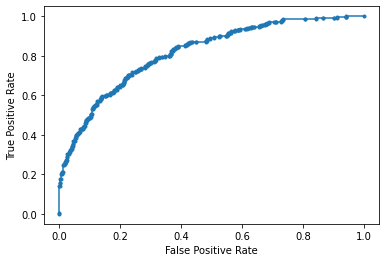

Accuracy: 71.97% Precision: 66.91% Recall: 79.83%
F1: 72.80% AUPRC: 80.75% AUROC: 81.61%
2023-02-14 14:23:01.343277
Fold 3
FIT
2023-02-14 14:23:12.831527
PREDICT
2023-02-14 14:23:24.484125


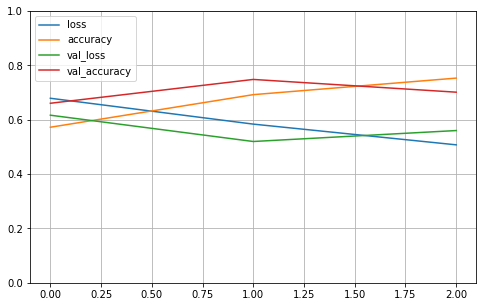

Train set ones/size 3969 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 417 / 981
Range of scores: 0.01616573 to 0.9940211
Score threshold 0.5
Prediction set ones/size 606 / 981


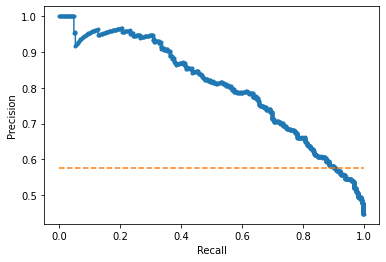

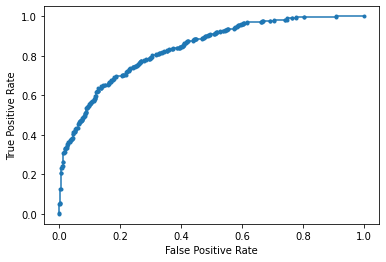

Accuracy: 70.13% Precision: 60.23% Recall: 87.53%
F1: 71.36% AUPRC: 80.31% AUROC: 83.81%
2023-02-14 14:23:25.438696
Fold 4
FIT
2023-02-14 14:23:39.371251
PREDICT
2023-02-14 14:23:51.001219


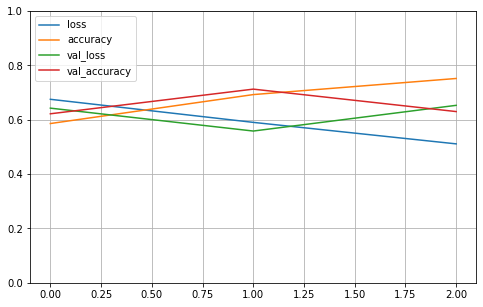

Train set ones/size 3896 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 455 / 981
Range of scores: 0.017481867 to 0.99343634
Score threshold 0.5
Prediction set ones/size 758 / 981


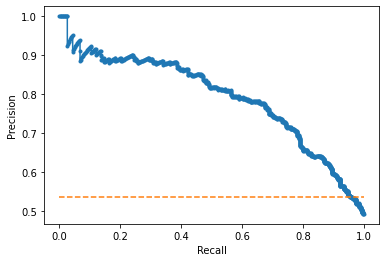

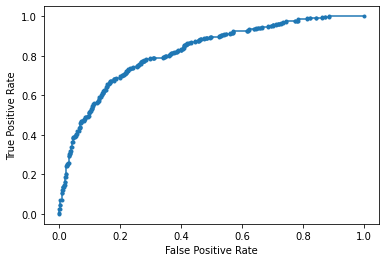

Accuracy: 63.00% Precision: 56.07% Recall: 93.41%
F1: 70.07% AUPRC: 79.36% AUROC: 81.97%
2023-02-14 14:23:51.949618
Fold 5
FIT
2023-02-14 14:24:03.130710
PREDICT
2023-02-14 14:24:13.534246


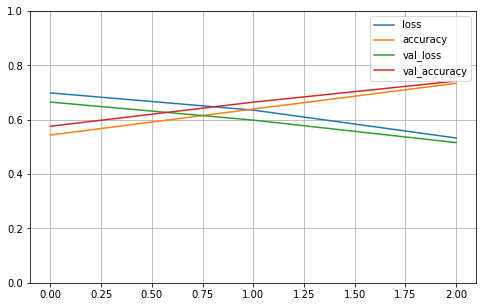

Train set ones/size 4105 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 456 / 981
Range of scores: 0.0017547931 to 0.9848932
Score threshold 0.5
Prediction set ones/size 491 / 981


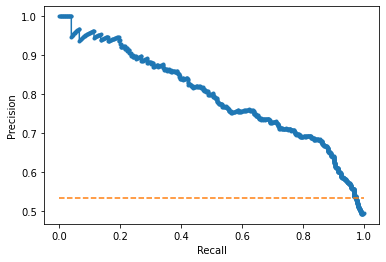

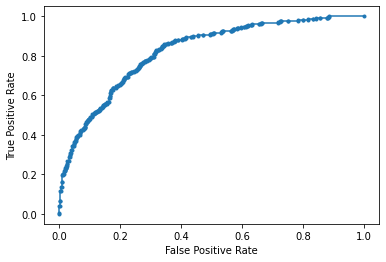

Accuracy: 74.21% Precision: 70.67% Recall: 76.10%
F1: 73.28% AUPRC: 79.71% AUROC: 82.26%
2023-02-14 14:24:14.343717
Fold 6
FIT
2023-02-14 14:24:26.551528
PREDICT
2023-02-14 14:24:38.207261


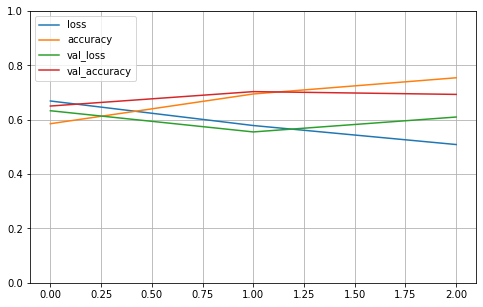

Train set ones/size 4814 / 8825
Compute valiation accuracy
Valid sizes (981, 4997) (981,)
Valid set ones/size 550 / 981
Range of scores: 0.002973928 to 0.9871704
Score threshold 0.5
Prediction set ones/size 327 / 981


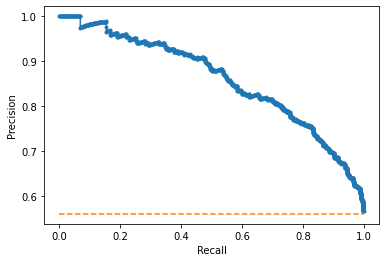

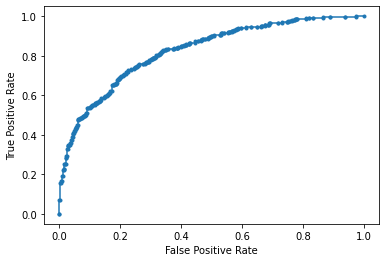

Accuracy: 69.32% Precision: 88.07% Recall: 52.36%
F1: 65.68% AUPRC: 86.01% AUROC: 82.56%
2023-02-14 14:24:39.044751
Fold 7
FIT
2023-02-14 14:24:52.664434
PREDICT
2023-02-14 14:25:04.305761


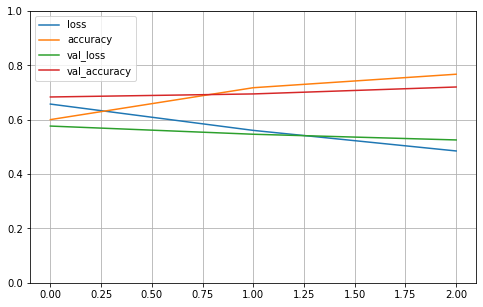

Train set ones/size 3748 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 427 / 980
Range of scores: 0.0019454742 to 0.9893332
Score threshold 0.5
Prediction set ones/size 283 / 980


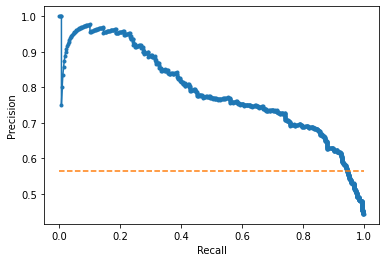

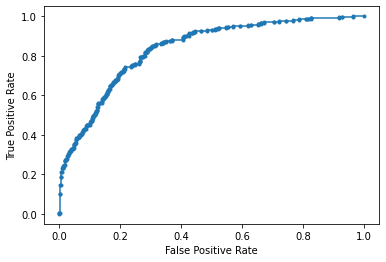

Accuracy: 72.04% Precision: 77.03% Recall: 51.05%
F1: 61.41% AUPRC: 79.08% AUROC: 83.54%
2023-02-14 14:25:05.131472
Fold 8
FIT
2023-02-14 14:25:14.688397
PREDICT
2023-02-14 14:25:25.186882


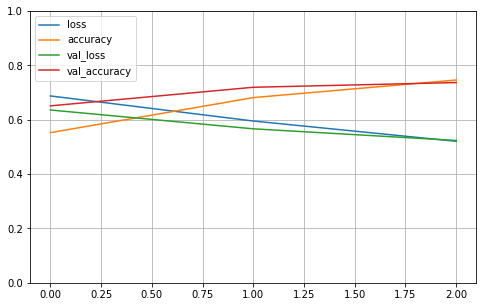

Train set ones/size 4697 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 485 / 980
Range of scores: 0.006042646 to 0.991284
Score threshold 0.5
Prediction set ones/size 451 / 980


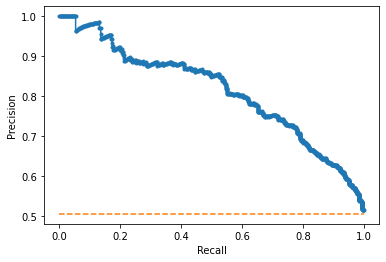

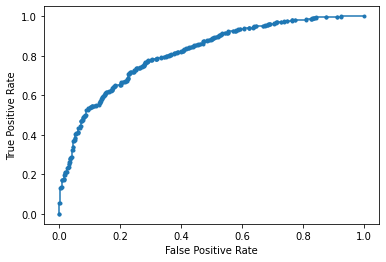

Accuracy: 73.67% Precision: 75.17% Recall: 69.90%
F1: 72.44% AUPRC: 81.40% AUROC: 81.53%
2023-02-14 14:25:25.997782
Fold 9
FIT
2023-02-14 14:25:36.842785
PREDICT
2023-02-14 14:25:48.494170


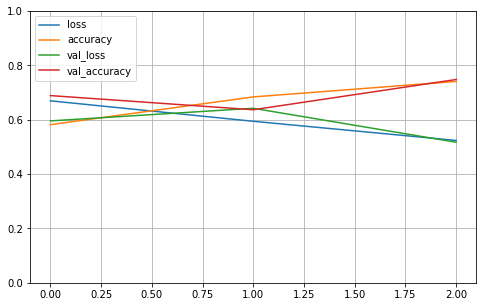

Train set ones/size 4004 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 438 / 980
Range of scores: 0.010718757 to 0.9847135
Score threshold 0.5
Prediction set ones/size 359 / 980


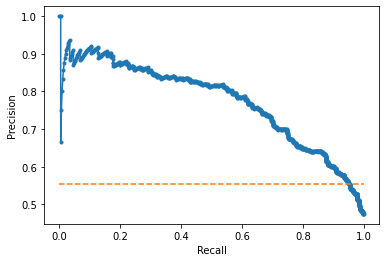

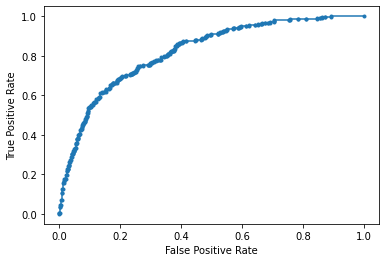

Accuracy: 74.80% Precision: 76.60% Recall: 62.79%
F1: 69.01% AUPRC: 77.43% AUROC: 82.13%
2023-02-14 14:25:49.524011
Fold 10
FIT
2023-02-14 14:26:01.691198
PREDICT
2023-02-14 14:26:13.343495


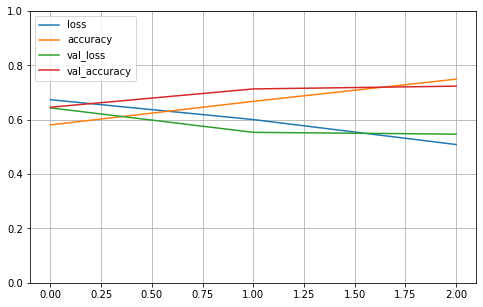

Train set ones/size 4815 / 8826
Compute valiation accuracy
Valid sizes (980, 4997) (980,)
Valid set ones/size 549 / 980
Range of scores: 0.039961055 to 0.9981838
Score threshold 0.5
Prediction set ones/size 734 / 980


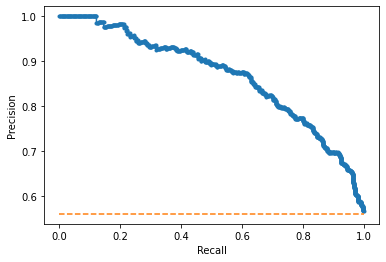

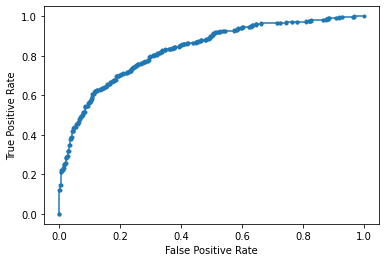

Accuracy: 72.35% Precision: 68.94% Recall: 92.17%
F1: 78.88% AUPRC: 86.77% AUROC: 83.16%
2023-02-14 14:26:14.286868

Completed cross validation 10 folds 3 epochs
 accuracy mean 71.25% +/- 3.38
 precision mean 70.30% +/- 9.37
 recall mean 74.69% +/- 15.35
 F1 mean 70.63% +/- 4.67
 AUPRC mean 80.90% +/- 3.12
 AUROC mean 82.40% +/- 0.85
Finished cell Line 12 GM12878

2023-02-14 14:26:15.771158
Start cell Line 13 K562
Number of RCI values loaded 958
Num RCI: 958
Load sequence...
Cross validation...
2023-02-14 14:26:26.195636
splitting
Fold 1
FIT
2023-02-14 14:26:34.678019
PREDICT
2023-02-14 14:26:46.584868


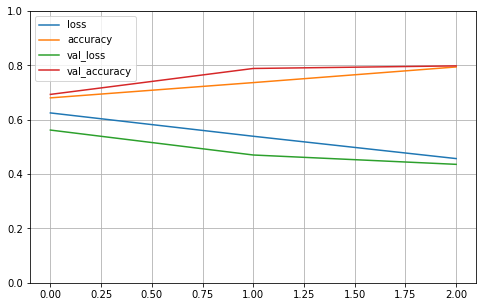

Train set ones/size 1757 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 194 / 629
Range of scores: 0.0038553304 to 0.9756079
Score threshold 0.5
Prediction set ones/size 119 / 629


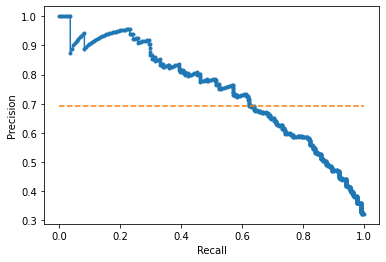

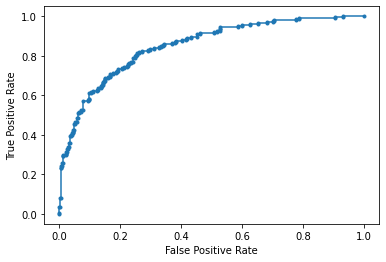

Accuracy: 79.81% Precision: 78.15% Recall: 47.94%
F1: 59.42% AUPRC: 74.28% AUROC: 85.06%
2023-02-14 14:26:47.336530
Fold 2
FIT
2023-02-14 14:26:56.996559
PREDICT
2023-02-14 14:27:04.433421


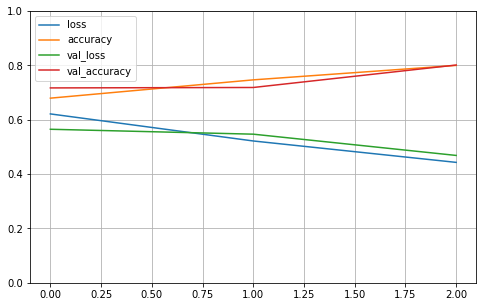

Train set ones/size 1795 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 203 / 629
Range of scores: 0.001289413 to 0.9901826
Score threshold 0.5
Prediction set ones/size 108 / 629


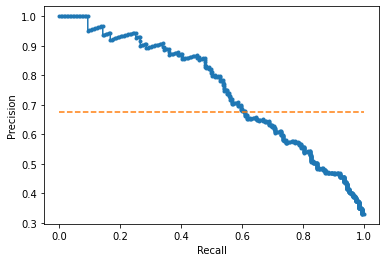

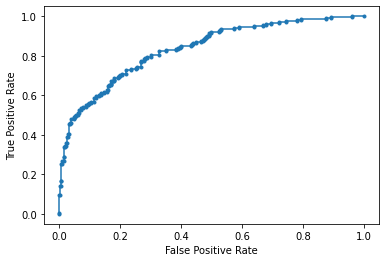

Accuracy: 80.13% Precision: 86.11% Recall: 45.81%
F1: 59.81% AUPRC: 75.03% AUROC: 83.49%
2023-02-14 14:27:05.191712
Fold 3
FIT
2023-02-14 14:27:13.207835
PREDICT
2023-02-14 14:27:20.895830


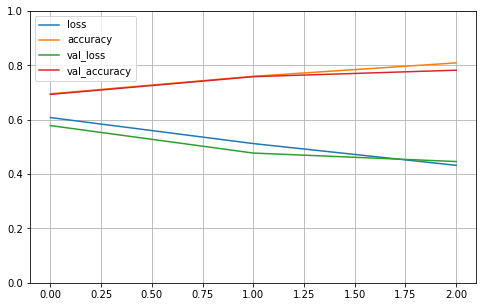

Train set ones/size 1712 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 202 / 629
Range of scores: 0.0032404913 to 0.98778963
Score threshold 0.5
Prediction set ones/size 167 / 629


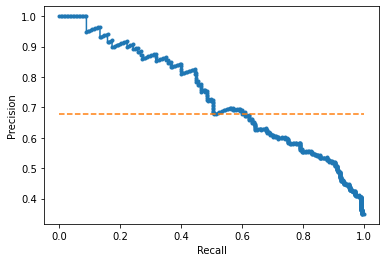

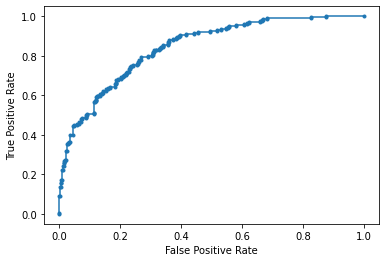

Accuracy: 78.22% Precision: 69.46% Recall: 57.43%
F1: 62.87% AUPRC: 73.62% AUROC: 84.29%
2023-02-14 14:27:21.608973
Fold 4
FIT
2023-02-14 14:27:31.567266
PREDICT
2023-02-14 14:27:43.039325


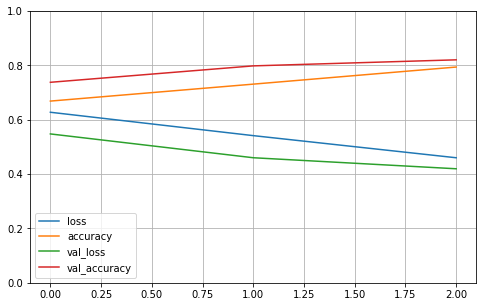

Train set ones/size 1820 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 183 / 629
Range of scores: 0.002394675 to 0.994659
Score threshold 0.5
Prediction set ones/size 150 / 629


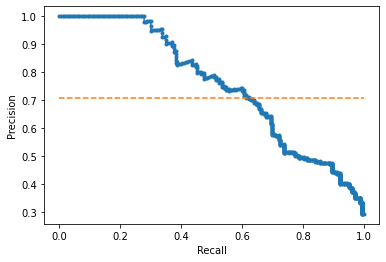

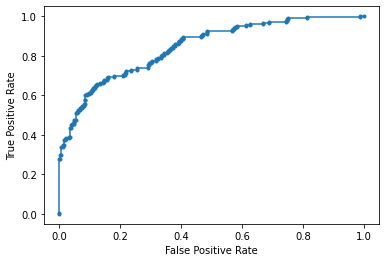

Accuracy: 82.03% Precision: 73.33% Recall: 60.11%
F1: 66.07% AUPRC: 75.42% AUROC: 84.48%
2023-02-14 14:27:44.055208
Fold 5
FIT
2023-02-14 14:27:53.317945
PREDICT
2023-02-14 14:28:01.251005


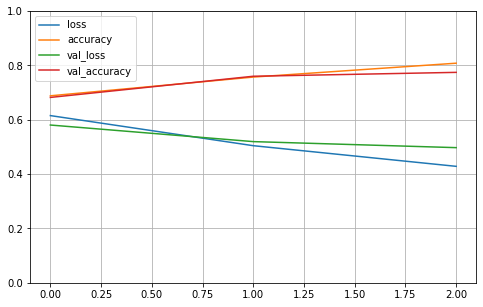

Train set ones/size 1746 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 205 / 629
Range of scores: 0.0006846426 to 0.98888373
Score threshold 0.5
Prediction set ones/size 121 / 629


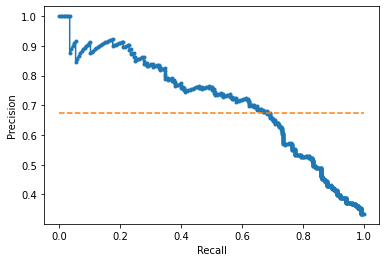

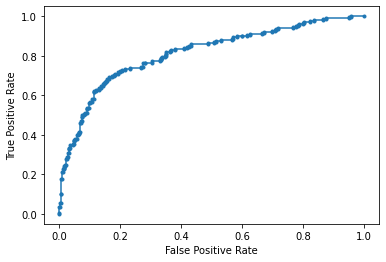

Accuracy: 77.42% Precision: 76.03% Recall: 44.88%
F1: 56.44% AUPRC: 71.24% AUROC: 81.35%
2023-02-14 14:28:01.968670
Fold 6
FIT
2023-02-14 14:28:12.315686
PREDICT
2023-02-14 14:28:23.773997


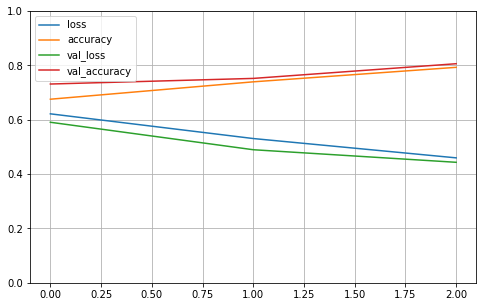

Train set ones/size 3908 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 430 / 629
Range of scores: 0.0070859636 to 0.9930824
Score threshold 0.5
Prediction set ones/size 476 / 629


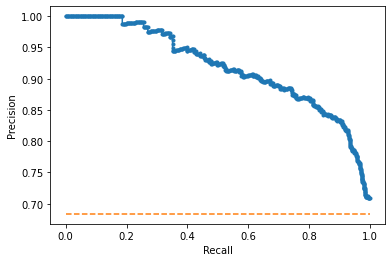

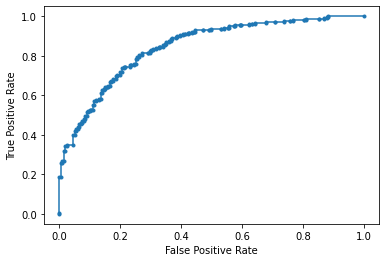

Accuracy: 80.60% Precision: 82.35% Recall: 91.16%
F1: 86.53% AUPRC: 91.89% AUROC: 84.49%
2023-02-14 14:28:24.536028
Fold 7
FIT
2023-02-14 14:28:34.629062
PREDICT
2023-02-14 14:28:41.912303


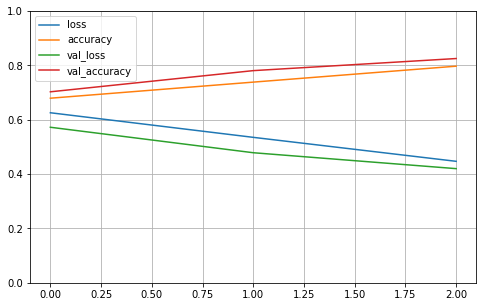

Train set ones/size 1795 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 203 / 629
Range of scores: 0.005928919 to 0.99601233
Score threshold 0.5
Prediction set ones/size 159 / 629


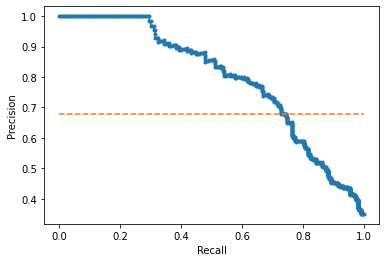

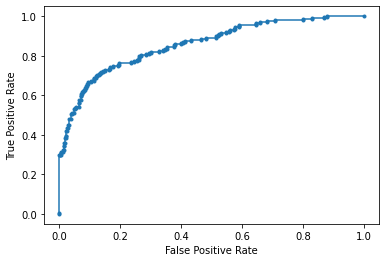

Accuracy: 82.51% Precision: 79.25% Recall: 62.07%
F1: 69.61% AUPRC: 79.69% AUROC: 85.82%
2023-02-14 14:28:42.667169
Fold 8
FIT
2023-02-14 14:28:53.743023
PREDICT
2023-02-14 14:29:05.185145


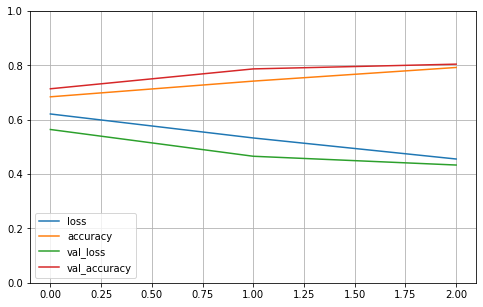

Train set ones/size 1762 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 189 / 629
Range of scores: 0.0031534443 to 0.984286
Score threshold 0.5
Prediction set ones/size 110 / 629


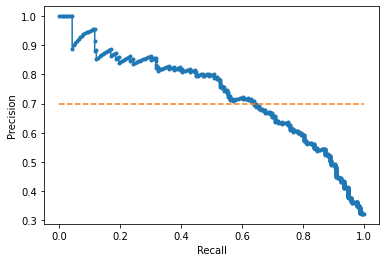

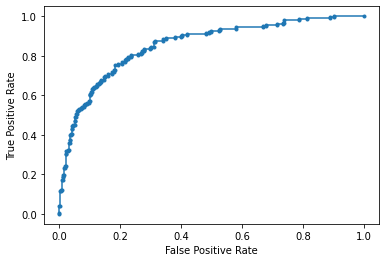

Accuracy: 80.45% Precision: 80.00% Recall: 46.56%
F1: 58.86% AUPRC: 73.27% AUROC: 85.40%
2023-02-14 14:29:05.943505
Fold 9
FIT
2023-02-14 14:29:17.257288
PREDICT
2023-02-14 14:29:28.705082


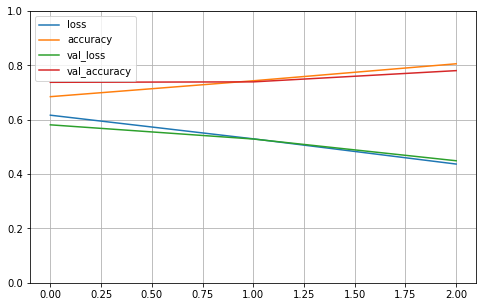

Train set ones/size 1734 / 5660
Compute valiation accuracy
Valid sizes (629, 4997) (629,)
Valid set ones/size 197 / 629
Range of scores: 0.002960141 to 0.9882125
Score threshold 0.5
Prediction set ones/size 111 / 629


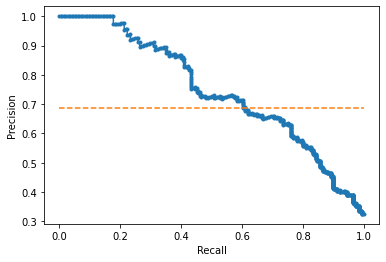

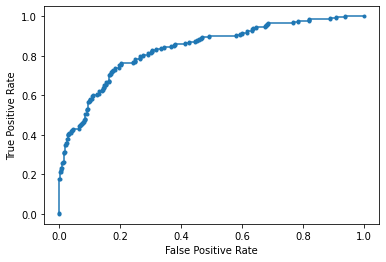

Accuracy: 78.06% Precision: 76.58% Recall: 43.15%
F1: 55.19% AUPRC: 74.68% AUROC: 83.52%
2023-02-14 14:29:29.444348
Fold 10
FIT
2023-02-14 14:29:37.651188
PREDICT
2023-02-14 14:29:49.534932


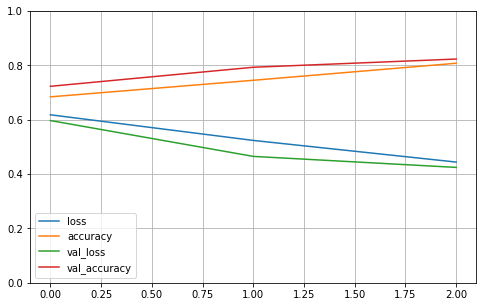

Train set ones/size 1748 / 5661
Compute valiation accuracy
Valid sizes (628, 4997) (628,)
Valid set ones/size 183 / 628
Range of scores: 0.0010995336 to 0.99453366
Score threshold 0.5
Prediction set ones/size 152 / 628


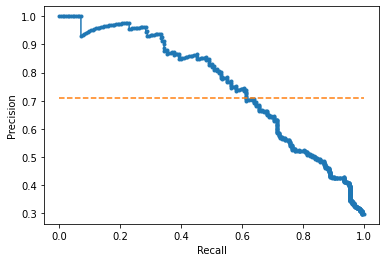

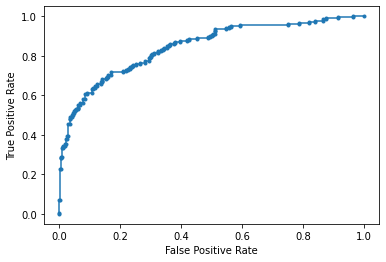

Accuracy: 82.32% Precision: 73.68% Recall: 61.20%
F1: 66.87% AUPRC: 75.37% AUROC: 84.63%
2023-02-14 14:29:50.277789

Completed cross validation 10 folds 3 epochs
 accuracy mean 80.16% +/- 1.82
 precision mean 77.49% +/- 4.80
 recall mean 56.03% +/- 14.40
 F1 mean 64.17% +/- 9.14
 AUPRC mean 76.45% +/- 5.83
 AUROC mean 84.25% +/- 1.26
Finished cell Line 13 K562

2023-02-14 14:29:51.694675
Start cell Line 14 IMR.90
Number of RCI values loaded 390
Num RCI: 390
Load sequence...
Cross validation...
2023-02-14 14:29:56.121084
splitting
Fold 1
FIT
2023-02-14 14:29:57.841641
PREDICT
2023-02-14 14:30:04.019401


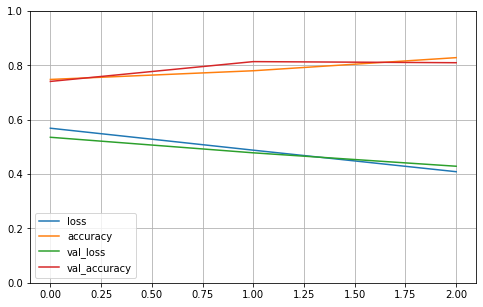

Train set ones/size 1695 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 183 / 247
Range of scores: 0.05988937 to 0.9871759
Score threshold 0.5
Prediction set ones/size 186 / 247


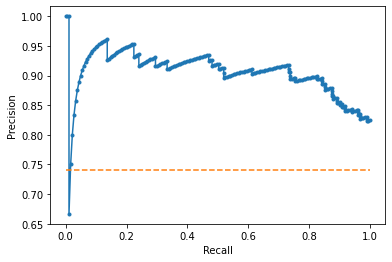

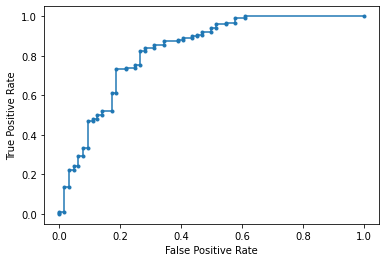

Accuracy: 80.97% Precision: 86.56% Recall: 87.98%
F1: 87.26% AUPRC: 90.55% AUROC: 82.74%
2023-02-14 14:30:05.021434
Fold 2
FIT
2023-02-14 14:30:08.168823
PREDICT
2023-02-14 14:30:14.310555


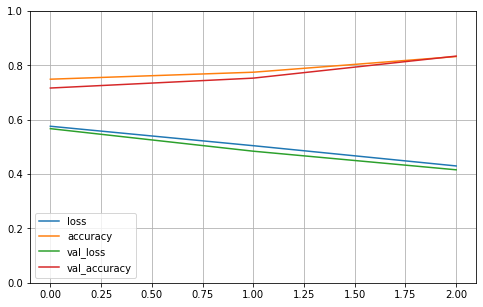

Train set ones/size 1703 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 177 / 247
Range of scores: 0.05349681 to 0.992242
Score threshold 0.5
Prediction set ones/size 196 / 247


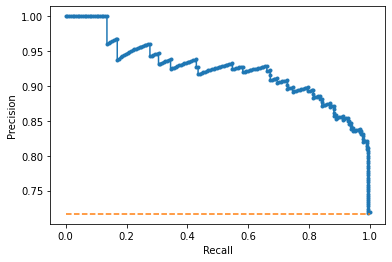

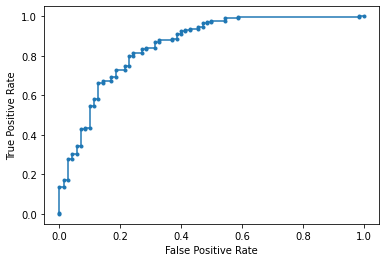

Accuracy: 83.40% Precision: 84.69% Recall: 93.79%
F1: 89.01% AUPRC: 92.35% AUROC: 85.34%
2023-02-14 14:30:15.007911
Fold 3
FIT
2023-02-14 14:30:20.142465
PREDICT
2023-02-14 14:30:23.993847


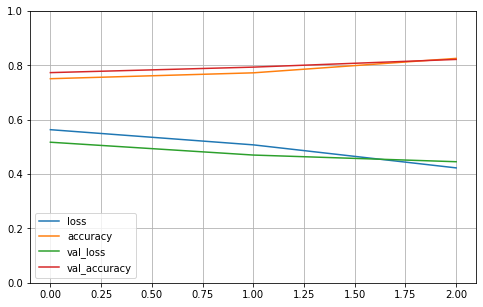

Train set ones/size 1686 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 191 / 247
Range of scores: 0.025731668 to 0.99701476
Score threshold 0.5
Prediction set ones/size 215 / 247


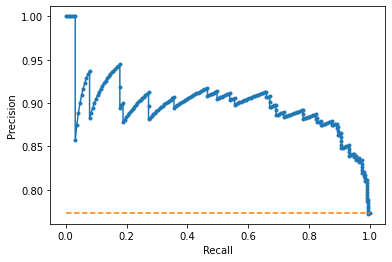

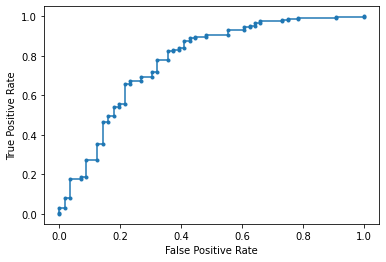

Accuracy: 82.19% Precision: 84.19% Recall: 94.76%
F1: 89.16% AUPRC: 89.68% AUROC: 77.39%
2023-02-14 14:30:24.672151
Fold 4
FIT
2023-02-14 14:30:27.689279
PREDICT
2023-02-14 14:30:31.926248


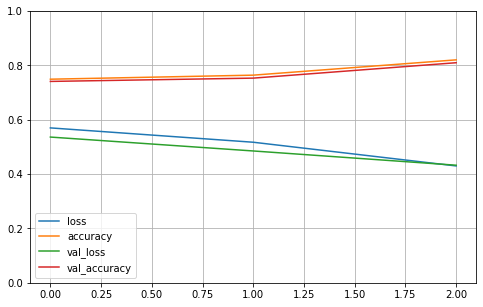

Train set ones/size 525 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 64 / 247
Range of scores: 0.0105507625 to 0.9809584
Score threshold 0.5
Prediction set ones/size 55 / 247


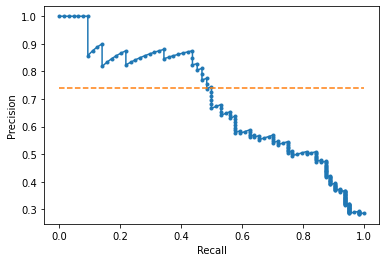

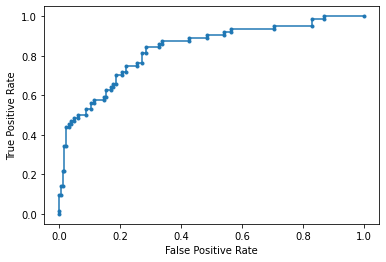

Accuracy: 80.97% Precision: 65.45% Recall: 56.25%
F1: 60.50% AUPRC: 69.10% AUROC: 83.48%
2023-02-14 14:30:32.965319
Fold 5
FIT
2023-02-14 14:30:36.019930
PREDICT
2023-02-14 14:30:39.882855


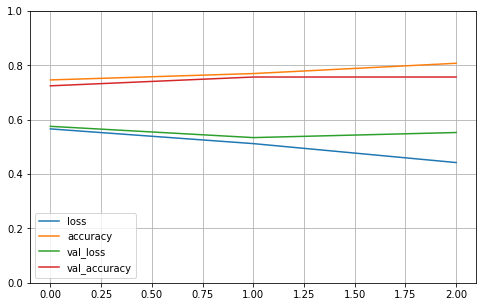

Train set ones/size 524 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 65 / 247
Range of scores: 0.024844911 to 0.9628093
Score threshold 0.5
Prediction set ones/size 63 / 247


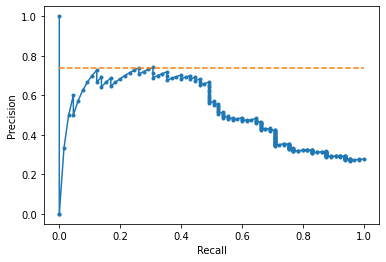

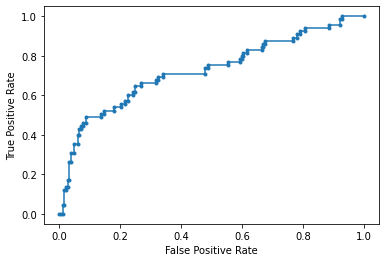

Accuracy: 75.71% Precision: 53.97% Recall: 52.31%
F1: 53.12% AUPRC: 51.61% AUROC: 72.54%
2023-02-14 14:30:40.571095
Fold 6
FIT
2023-02-14 14:30:46.013155
PREDICT
2023-02-14 14:30:52.159836


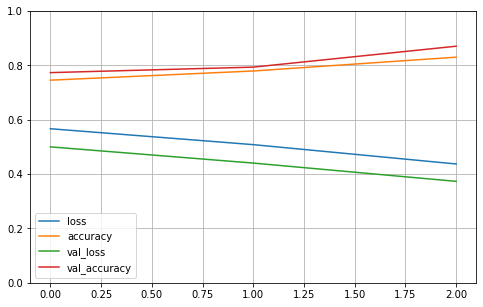

Train set ones/size 533 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 57 / 247
Range of scores: 0.01800504 to 0.9302479
Score threshold 0.5
Prediction set ones/size 33 / 247


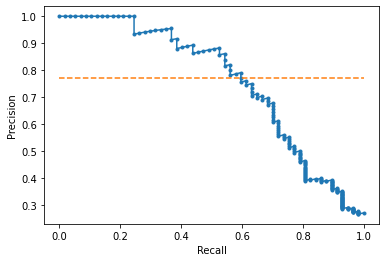

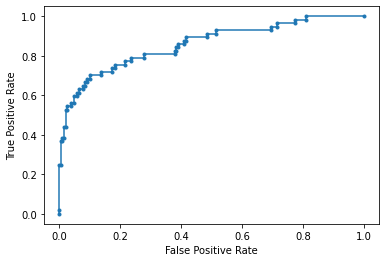

Accuracy: 87.04% Precision: 87.88% Recall: 50.88%
F1: 64.44% AUPRC: 75.55% AUROC: 85.91%
2023-02-14 14:30:52.852749
Fold 7
FIT
2023-02-14 14:30:58.150813
PREDICT
2023-02-14 14:31:01.978515


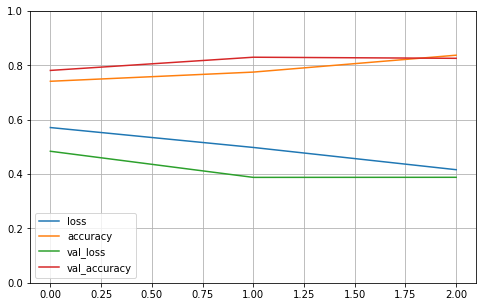

Train set ones/size 1685 / 2220
Compute valiation accuracy
Valid sizes (247, 4997) (247,)
Valid set ones/size 193 / 247
Range of scores: 0.033927012 to 0.98663414
Score threshold 0.5
Prediction set ones/size 184 / 247


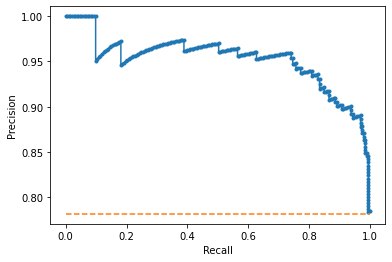

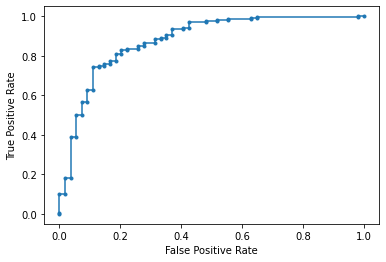

Accuracy: 82.59% Precision: 90.76% Recall: 86.53%
F1: 88.59% AUPRC: 95.23% AUROC: 87.80%
2023-02-14 14:31:02.663589
Fold 8
FIT
2023-02-14 14:31:05.711454
PREDICT
2023-02-14 14:31:09.754806


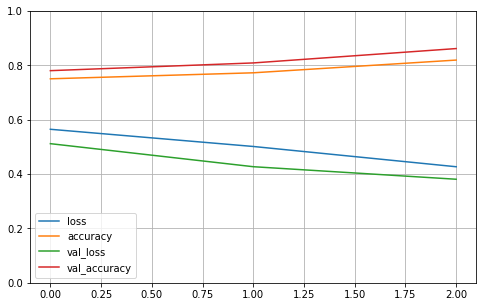

Train set ones/size 1686 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 192 / 246
Range of scores: 0.08571285 to 0.9981888
Score threshold 0.5
Prediction set ones/size 218 / 246


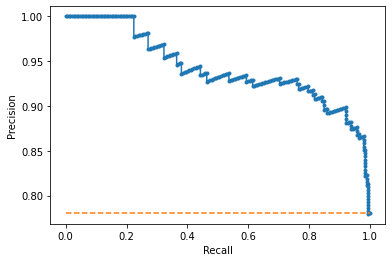

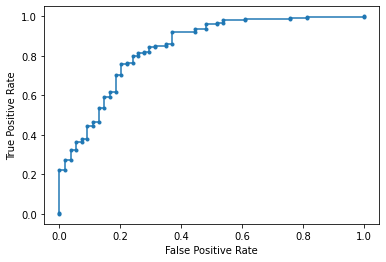

Accuracy: 86.18% Precision: 86.24% Recall: 97.92%
F1: 91.71% AUPRC: 94.23% AUROC: 84.11%
2023-02-14 14:31:10.655895
Fold 9
FIT
2023-02-14 14:31:13.719029
PREDICT
2023-02-14 14:31:17.549940


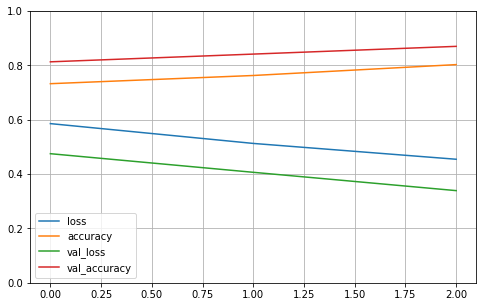

Train set ones/size 543 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 46 / 246
Range of scores: 0.005510039 to 0.90361124
Score threshold 0.5
Prediction set ones/size 26 / 246


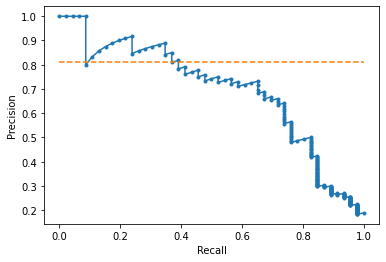

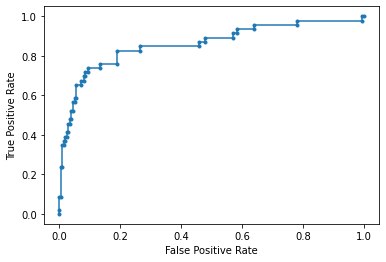

Accuracy: 86.99% Precision: 76.92% Recall: 43.48%
F1: 55.56% AUPRC: 69.44% AUROC: 86.01%
2023-02-14 14:31:18.220709
Fold 10
FIT
2023-02-14 14:31:21.239576
PREDICT
2023-02-14 14:31:25.910479


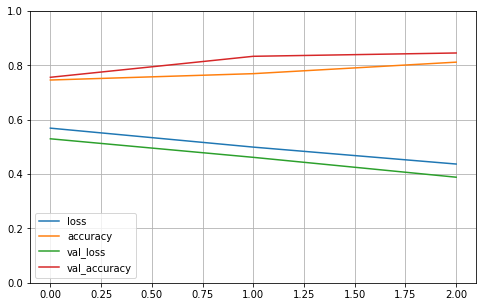

Train set ones/size 528 / 2221
Compute valiation accuracy
Valid sizes (246, 4997) (246,)
Valid set ones/size 59 / 246
Range of scores: 0.00362672 to 0.92512226
Score threshold 0.5
Prediction set ones/size 29 / 246


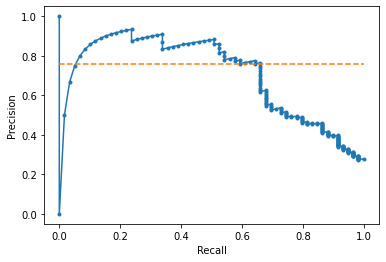

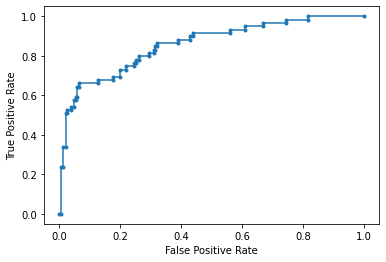

Accuracy: 84.55% Precision: 86.21% Recall: 42.37%
F1: 56.82% AUPRC: 69.63% AUROC: 85.79%
2023-02-14 14:31:26.553907

Completed cross validation 10 folds 3 epochs
 accuracy mean 83.06% +/- 3.45
 precision mean 80.29% +/- 11.72
 recall mean 70.63% +/- 23.30
 F1 mean 73.62% +/- 16.67
 AUPRC mean 79.73% +/- 14.74
 AUROC mean 83.11% +/- 4.67
Finished cell Line 14 IMR.90

2023-02-14 14:31:27.863574


In [10]:
for CELL_LINE in range(NUM_LINES):
    print(datetime.now())
    print('Start cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE
    gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
    print('Num RCI:', len(gene_to_rci.keys()))
    print('Load sequence...')
    filepath = DATA_DIR+SEQUENCE_FILE
    allids,allseq = loader.load_sequence(filepath)
    loader = None  # drop K-mer cache to save RAM

    print("Cross validation...")
    cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
    cvdo.set_sequences(allids,allseq)
    cvdo.set_rci_map(gene_to_rci)
    cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
    cv_accuracy, cv_precision, cv_recall, cv_f1, cv_auprc, cv_auroc = cvdo.do_cross_validation()   
    cvdo = None
    print("Completed cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
    print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy,ddof=1)))
    print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision,ddof=1)))
    print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall,ddof=1)))
    print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1,ddof=1)))
    print(" AUPRC mean %.2f%% +/- %.2f" % (np.mean(cv_auprc), np.std(cv_auprc,ddof=1)))
    print(" AUROC mean %.2f%% +/- %.2f" % (np.mean(cv_auroc), np.std(cv_auroc,ddof=1)))
    print('Finished cell Line',CELL_LINE,all_cell_lines[CELL_LINE])
    print()
print(datetime.now())